# Starbucks Capstone Challenge

### Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  



## Problem Statement / Metrics

The business case that I chose to solve is to build a model that predicts whether a customer will respond to an offer based on the customers demographics and the offers attributes.

### Strategy 
1. Clean and combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. 
2. Build the machin learning models and assess the accuracy and F1-score of the models that assumes all offers were successful.  Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of a model performance. For this situation, evaluating a models' precision and recall provides better insight to its performance. F1-score metric is a good measure as it's a weighted average of the precision and recall metrics. 
3. Compare the performance of random forest, gradient boosting and catboost models. 
4. Refine the parameters of the model that has the highest accuracy and F1-score.

In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
from sklearn import metrics
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploation and Wrangling

### Portfolio - contains offer ids and meta data about each offer (duration, type, etc.)

In [93]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [94]:
portfolio.shape

(10, 6)

In [95]:
# Check for null values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [96]:
# Number of the unique offers
portfolio.id.nunique()

10

In [97]:
# Offers by type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

#### DATA WRANGLING STEPS
1. Change column ordering
1. Change the name of the 'id' column to 'offerid'
1. Generate One-Hot encoded columns from 'offertype' column (and replace original)
1. Generate One-Hot encoded columns from 'channels' column [with multiple labels] (and replace original)

In [3]:
# Change column ordering
portfolio = portfolio[["id", "difficulty", "reward", "duration", "offer_type", "channels"]]

# Change the name of the 'id' column to 'offerid'
portfolio.rename(columns={"id": "offerid"}, inplace = True)

# One-Hot encode the 'offertype' column
offertype_df = pd.get_dummies(portfolio['offer_type'])

# One-Hot encode the 'channels' columns
multi_onehot = MultiLabelBinarizer()
multi_onehot.fit(portfolio['channels'])
channels_df = pd.DataFrame(multi_onehot.transform(portfolio['channels']), columns=multi_onehot.classes_)

# Add the new columns to the root dataset
portfolio = pd.concat([portfolio, offertype_df, channels_df], axis=1)

# Drop the "offertype" & "channels" column
portfolio = portfolio.drop(columns=['offer_type', 'channels'])

In [4]:
portfolio.head(10)

,offerid,difficulty,reward,duration,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,3,7,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,2,10,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,2,7,0,1,0,1,1,0,1


In [103]:
portfolio.shape

(10, 11)

In [104]:
portfolio.describe()

,difficulty,reward,duration,bogo,discount,informational,email,mobile,social,web
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,7.700000,4.200000,6.500000,0.400000,0.400000,0.200000,1.0,0.900000,0.600000,0.800000
std,5.831905,3.583915,2.321398,0.516398,0.516398,0.421637,0.0,0.316228,0.516398,0.421637
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,5.000000,2.000000,5.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000
50%,8.500000,4.000000,7.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000
75%,10.000000,5.000000,7.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000
max,20.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


### Profile - demographic data for each customer

In [105]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [106]:
profile.shape

(17000, 5)

In [107]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


#### max(age) 118 does not look correct

<AxesSubplot:>

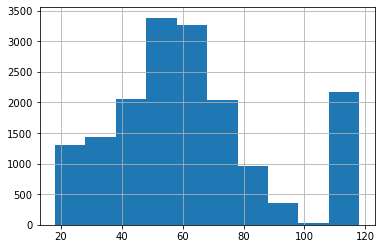

In [108]:
# Lets check what is the age distribution

profile.age.hist()

In [109]:
#check count of age=118 value and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


<AxesSubplot:>

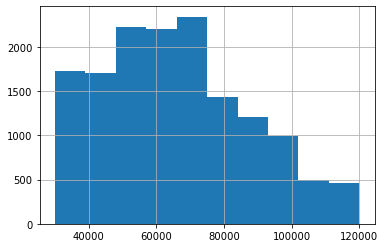

In [110]:
#check distributions of income
profile.income.hist()

<AxesSubplot:>

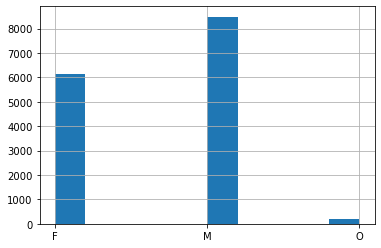

In [111]:
#check gender distributions
profile.gender.hist()

#### DATA WRANGLING STEPS
1. Change column ordering
1. Change the name of the 'id' column to 'customerid'
1. Convert missing value encoded as 118 to N/A in the "age" column
1. Remove customers with N/A income data, N/A gender data and unspecified gender
1. Transform the 'became_member_on' column to a datetime object
1. Perform Encoding on the "gender" column

In [5]:
# Change column ordering
profile = profile[["id", "age", "gender", "income", "became_member_on"]]

# Change the name of the 'id' column to 'customerid'
profile.rename(columns={"id": "customerid"}, inplace = True)

# Convert missing value encoded as 118 to N/A in the "age" column
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

# drop all missing values
profile = profile[profile['gender'] != 'O'] # Remove customers with unspecified gender
profile.dropna(inplace=True)
profile = profile.reset_index(drop=True)

# the number of days since the user is a member of starbucks
profile['membership_days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
profile['membership_days'] = profile['membership_days'].dt.days
profile = profile.drop(columns=['became_member_on'])

# Perform Encoding on the "gender" column
profile["gender"] = profile["gender"].map({'M': 1, 'F': 0})

In [6]:
profile.head()

,customerid,age,gender,income,membership_days
0,0610b486422d4921ae7d2bf64640c50b,55.0,0,112000.0,1565
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,0,100000.0,1632
2,e2127556f4f64592b11af22de27a7932,68.0,1,70000.0,1280
3,389bc3fa690240e798340f5a15918d5c,65.0,1,53000.0,1356
4,2eeac8d8feae4a8cad5a6af0499a211d,58.0,1,51000.0,1446


In [114]:
profile.shape

(14613, 5)

In [115]:
profile.describe()

,age,gender,income,membership_days
count,14613.000000,14613.000000,14613.000000,14613.000000
mean,54.393417,0.580579,65435.707931,1711.991035
std,17.400201,0.493481,21633.524110,419.681797
min,18.000000,0.000000,30000.000000,1189.000000
25%,42.000000,0.000000,49000.000000,1397.000000
50%,55.000000,1.000000,64000.000000,1547.000000
75%,66.000000,1.000000,80000.000000,1987.000000
max,101.000000,1.000000,120000.000000,3012.000000


### Transcript - records for transactions, offers received, offers viewed, and offers completed

In [116]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [117]:
transcript.shape

(306534, 4)

In [118]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

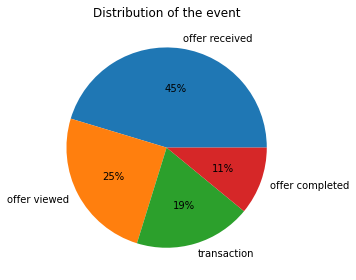

In [119]:
#check event distribution
plt.pie((transcript.event).value_counts(),labels=transcript['event'].unique(),autopct='%0.0f%%' )
plt.title('Distribution of the event')
plt.tight_layout()
plt.show(); 

In [120]:
# Exploration of the transcript records of one user
transcript[transcript['person']=='aa4862eba776480b8bb9c68455b8c2e1']

,person,event,value,time
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
20284,aa4862eba776480b8bb9c68455b8c2e1,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},18
53183,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},168
65845,aa4862eba776480b8bb9c68455b8c2e1,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},168
83400,aa4862eba776480b8bb9c68455b8c2e1,transaction,{'amount': 12.33},210
83401,aa4862eba776480b8bb9c68455b8c2e1,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,210
110836,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},336
123541,aa4862eba776480b8bb9c68455b8c2e1,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},336
150604,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408
174355,aa4862eba776480b8bb9c68455b8c2e1,transaction,{'amount': 15.95},426


#### DATA WRANGLING STEPS
1. Change the name of the 'person' column to 'customerid'
1. Remove customer id's that are not in the customer profile DataFrame
1. Extract the offerid from the value column into a separate column
1. Only keep the following events: offer viewed, offer completed
1. Change column ordering

In [7]:
# Change the name of the 'person' column to 'customerid'
transcript.rename(columns={"person": "customerid"}, inplace = True)

# Remove customer id's that are not in the customer profile DataFrame
transcript = transcript[transcript['customerid'].isin(profile['customerid'])]

# Extract the offerid from the value column into a separate column
transcript['offerid'] = transcript['value'].apply(lambda elem: list(elem.values())[0])
transcript = transcript.drop(columns=['value'])

# Only keep the following events: offer viewed, offer completed
transcript = transcript[(transcript['event'] == "offer viewed") | (transcript['event'] == "offer completed")]

# Change column ordering
transcript = transcript[["customerid", "offerid", "event", "time"]]

transcript = transcript.reset_index(drop=True)

In [8]:
transcript.head(10)

,customerid,offerid,event,time
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,0
1,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed,0
2,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,offer viewed,0
3,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,offer viewed,0
4,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,offer viewed,0
5,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,offer completed,0
6,8c7df0c393db488aac3e58b06a7ea5f9,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,0
7,e528ceb341964128aaf58a59733ec2af,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,0
8,262ad0fb526a4d53b572007da60cce24,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,0
9,f8aedd0cbea0419c806842b4265b82e5,ae264e3637204a6fb9bb56bc8210ddfd,offer viewed,0


Now what we want to do is to create a column named as response. For a particular customer, if a particular offer was viewed and then the offer was completed, the value in the response column for that particular offer should be one. If a particular offer was only viewed and not completed, then the value in the response column for that particular offer should be zero. This will signify the response of an individual towards different offfers. Note that the sequence of viewing the offer and then completing the offer should be maintained. 

In [9]:
transcript = transcript.groupby('customerid')

In [10]:
cleaned_transaction = []
for customer in tqdm(list(transcript.groups)): 
    customer_data = transcript.get_group(customer).drop_duplicates(subset=["offerid","event"])
    for value in customer_data["offerid"].value_counts().items():
        if(value[1] == 1):
            offer_complete_cond = customer_data["event"][list(customer_data.loc[customer_data['offerid']==value[0]].index)[0]] == "offer completed"
            if(offer_complete_cond == True):
                pass
            else:
                cleaned_transaction.append([customer, value[0], 0])
        else:
            event1 = customer_data["event"][list(customer_data.loc[customer_data['offerid']==value[0]].index)[0]]
            event2 = customer_data["event"][list(customer_data.loc[customer_data['offerid']==value[0]].index)[1]]
            if((event1 == 'offer viewed') & (event2 == 'offer completed')):
                cleaned_transaction.append([customer, value[0], 1])
            else:
                cleaned_transaction.append([customer, value[0], 0])

100%|███████████████████████████████████████████████████████████████████████████| 14534/14534 [02:08<00:00, 112.87it/s]


In [11]:
transcript = pd.DataFrame(cleaned_transaction, columns =['customerid', 'offerid', 'response'])
transcript.head(10)

,customerid,offerid,response
0,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
5,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1
6,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,0
7,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
8,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1
9,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1


In [12]:
transcript.shape

(41835, 3)

### COMBINED DATASET

Starbucks Dataset = Profile + Portfolio + Transcript

Note: Removing the customerid and the offerid column since we already gathered all the relevant information

In [13]:
starbucks_dataset = pd.merge(pd.merge(profile, transcript, on='customerid'), portfolio, on='offerid')
starbucks_dataset = starbucks_dataset.drop(columns=['customerid', 'offerid'])
# Change column ordering
starbucks_dataset = starbucks_dataset[['age', 'gender', 'income', 'membership_days',
                                       'difficulty', 'reward', 'duration', 'bogo', 'discount',
                                       'informational', 'email', 'mobile', 'social', 'web', 'response']] 
starbucks_dataset[["age", "income"]] = starbucks_dataset[["age", "income"]].astype(int)
starbucks_dataset.head()

,age,gender,income,membership_days,difficulty,reward,duration,bogo,discount,informational,email,mobile,social,web,response
0,75,0,100000,1632,10,10,7,1,0,0,1,1,1,0,1
1,61,0,57000,1507,10,10,7,1,0,0,1,1,1,0,0
2,26,1,46000,2813,10,10,7,1,0,0,1,1,1,0,0
3,49,1,52000,2540,10,10,7,1,0,0,1,1,1,0,1
4,61,0,40000,1275,10,10,7,1,0,0,1,1,1,0,0


In [14]:
starbucks_dataset.shape

(41835, 15)

## Fitting Machine Learning Model

In [15]:
starbucks_dataset_ml = starbucks_dataset[(starbucks_dataset["bogo"] == 1) | (starbucks_dataset["discount"] == 1)]

In [16]:
X = starbucks_dataset_ml[['age', 'gender', 'income', 'membership_days',
                            'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web']].values
y = starbucks_dataset_ml['response'].values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (27143, 11) (27143,)
Test set: (6786, 11) (6786,)


### Define model performance evaluation function

In [18]:
def evaluate_model_performance(clf,
                               X_train,
                               y_train):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        clf: Model object
        
        X_train: Training data matrix

        y_train: Expected model output vector
    
    OUTPUT:
        clf_accuracy: Model accuracy
        
        clf_f1_score: Model F1-score"""
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

## 1. Random Forest Classifier

In [19]:
#Create a Gaussian Classifier
rf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

In [21]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6566460359563808
F1 Score: 0.7124166872377192


In [22]:
rf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [150, 200, 250, 300]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 30,
                               cv = 3,
                               verbose = 2,
                               n_jobs = 3)

rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=3,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [150, 200, 250, 300]},
                   verbose=2)

In [23]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6566460359563808
F1 Score: 0.7124166872377192


### Evalaute Random Forest Model Performance

In [24]:
rf_random.best_estimator_

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300)

In [25]:
evaluate_model_performance(rf_random.best_estimator_,
                           X_train,
                           y_train)

RandomForestClassifier model accuracy: 0.842
RandomForestClassifier model f1-score: 0.868


(0.8415797811590465, 0.8675129405965)

In [26]:
rf = RandomForestClassifier(n_estimators = 300, min_samples_split = 10, min_samples_leaf = 4, random_state = 4)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [27]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6735926908340701
F1 Score: 0.7297791875076247


### Vizualizing Important Features

In [28]:
feature_imp = pd.Series(rf.feature_importances_,index=['age', 'gender', 'income', 'membership_days',
                       'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web']).sort_values(ascending=False)
feature_imp

membership_days    0.423791
income             0.239403
age                0.215227
reward             0.046473
gender             0.026479
duration           0.019831
difficulty         0.011545
social             0.008723
web                0.007260
mobile             0.001269
email              0.000000
dtype: float64

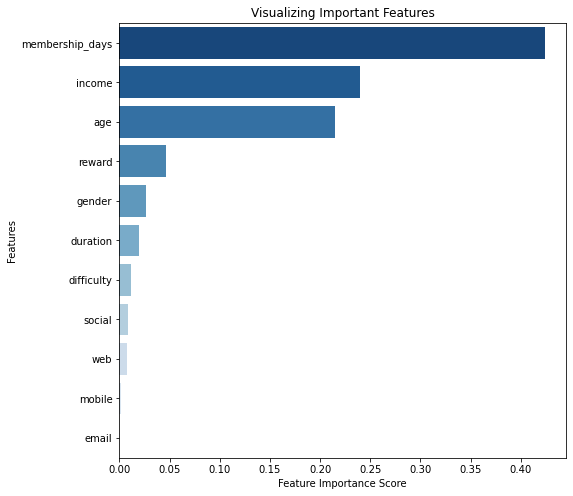

In [29]:
palette = sns.color_palette("Blues_r", feature_imp.shape[0])
plt.figure(figsize=(8, 8))

sns.barplot(x=feature_imp, y=feature_imp.index, palette=palette)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [30]:
feature_imp.head(n=10)

membership_days    0.423791
income             0.239403
age                0.215227
reward             0.046473
gender             0.026479
duration           0.019831
difficulty         0.011545
social             0.008723
web                0.007260
mobile             0.001269
dtype: float64

## 2. Gradient Boosting Classifier

In [59]:
gb_clf = GradientBoostingClassifier()

# Create the random grid
random_grid = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_samples_split}

gb_random = RandomizedSearchCV(estimator = gb_clf,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   n_jobs = 3)

gb_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=3,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'loss': ['deviance', 'exponential'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 30, 50, 100, 150,
                                                         200, 250, 300]},
                   verbose=2)

### Evaluate Gradient Boosting Model Performance

In [60]:
gb_random.best_estimator_

GradientBoostingClassifier(loss='exponential', min_samples_leaf=4,
                           min_samples_split=10, n_estimators=300)

In [61]:
evaluate_model_performance(gb_random.best_estimator_,
                           X_train,
                           y_train)

GradientBoostingClassifier model accuracy: 0.694
GradientBoostingClassifier model f1-score: 0.745


(0.6938437166120178, 0.7451232977548767)

## 3. CatBoost Classifier 

CatBoost is an algorithm for gradient boosting on decision trees. 
Catboost build one of the most accurate model on whatever dataset you feed it with — requiring minimal data prep.
It is a readymade classifier in scikit-learn’s conventions terms.
Though I have applied it on the cleaned and transformed dataset using one-hot encoding etc, Catboost would deal with the categorical features automatically and is scalable in nature.

In [35]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [36]:
from catboost import CatBoostClassifier

cb_clf = CatBoostClassifier(
    iterations=50,
    random_seed=42,
    learning_rate=0.5, 
    custom_loss=['AUC', 'Accuracy']
)

cb_clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False,
        plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [64]:
print('CatBoost model is fitted: ' + str(cb_clf.is_fitted()))
print('CatBoost model parameters:')
print(cb_clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 50, 'learning_rate': 0.5, 'random_seed': 42, 'custom_loss': ['AUC', 'Accuracy']}


In [65]:
y_pred = cb_clf.predict(X_test)

In [66]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6842027704096669
F1 Score: 0.742396922707056


In [45]:
import numpy as np
from scipy.stats import randint
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

#Instantiate CatBoostClassifier
cbc = CatBoostClassifier()

# Creating the hyperparameter grid
param_dist = { 'learning_rate': np.linspace(0,0.2,5),
               'max_depth': randint(3, 10)}
               
#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbc , param_dist, scoring='accuracy', cv =5)

#Fit the model
rscv.fit(X_train, y_train)

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

0:	learn: 0.6767951	total: 17.2ms	remaining: 17.2s
1:	learn: 0.6630644	total: 33.4ms	remaining: 16.7s
2:	learn: 0.6511752	total: 51ms	remaining: 17s
3:	learn: 0.6418531	total: 65.8ms	remaining: 16.4s
4:	learn: 0.6338269	total: 83.1ms	remaining: 16.5s
5:	learn: 0.6274172	total: 99.7ms	remaining: 16.5s
6:	learn: 0.6222087	total: 115ms	remaining: 16.4s
7:	learn: 0.6181677	total: 131ms	remaining: 16.3s
8:	learn: 0.6145550	total: 149ms	remaining: 16.4s
9:	learn: 0.6117786	total: 165ms	remaining: 16.3s
10:	learn: 0.6089605	total: 177ms	remaining: 15.9s
11:	learn: 0.6061651	total: 194ms	remaining: 15.9s
12:	learn: 0.6043694	total: 207ms	remaining: 15.7s
13:	learn: 0.6030695	total: 215ms	remaining: 15.2s
14:	learn: 0.6016605	total: 227ms	remaining: 14.9s
15:	learn: 0.5999354	total: 244ms	remaining: 15s
16:	learn: 0.5987762	total: 262ms	remaining: 15.1s
17:	learn: 0.5976436	total: 278ms	remaining: 15.2s
18:	learn: 0.5962551	total: 296ms	remaining: 15.3s
19:	learn: 0.5956912	total: 311ms	remaini

161:	learn: 0.5578484	total: 2.35s	remaining: 12.2s
162:	learn: 0.5576962	total: 2.37s	remaining: 12.1s
163:	learn: 0.5574737	total: 2.37s	remaining: 12.1s
164:	learn: 0.5571439	total: 2.38s	remaining: 12.1s
165:	learn: 0.5570409	total: 2.4s	remaining: 12.1s
166:	learn: 0.5568509	total: 2.42s	remaining: 12.1s
167:	learn: 0.5566105	total: 2.44s	remaining: 12.1s
168:	learn: 0.5563768	total: 2.45s	remaining: 12.1s
169:	learn: 0.5561376	total: 2.47s	remaining: 12s
170:	learn: 0.5558070	total: 2.48s	remaining: 12s
171:	learn: 0.5555696	total: 2.5s	remaining: 12s
172:	learn: 0.5553656	total: 2.52s	remaining: 12s
173:	learn: 0.5550651	total: 2.53s	remaining: 12s
174:	learn: 0.5549549	total: 2.54s	remaining: 12s
175:	learn: 0.5547906	total: 2.56s	remaining: 12s
176:	learn: 0.5545719	total: 2.57s	remaining: 12s
177:	learn: 0.5543840	total: 2.59s	remaining: 12s
178:	learn: 0.5541657	total: 2.6s	remaining: 11.9s
179:	learn: 0.5539866	total: 2.62s	remaining: 11.9s
180:	learn: 0.5537567	total: 2.64

324:	learn: 0.5239866	total: 4.73s	remaining: 9.83s
325:	learn: 0.5238344	total: 4.74s	remaining: 9.81s
326:	learn: 0.5236824	total: 4.75s	remaining: 9.78s
327:	learn: 0.5234892	total: 4.76s	remaining: 9.76s
328:	learn: 0.5232914	total: 4.78s	remaining: 9.74s
329:	learn: 0.5231207	total: 4.79s	remaining: 9.73s
330:	learn: 0.5228958	total: 4.8s	remaining: 9.71s
331:	learn: 0.5227046	total: 4.82s	remaining: 9.69s
332:	learn: 0.5225520	total: 4.83s	remaining: 9.67s
333:	learn: 0.5223425	total: 4.84s	remaining: 9.64s
334:	learn: 0.5221845	total: 4.84s	remaining: 9.62s
335:	learn: 0.5220355	total: 4.86s	remaining: 9.6s
336:	learn: 0.5219063	total: 4.87s	remaining: 9.59s
337:	learn: 0.5216985	total: 4.88s	remaining: 9.57s
338:	learn: 0.5215510	total: 4.9s	remaining: 9.55s
339:	learn: 0.5214208	total: 4.91s	remaining: 9.54s
340:	learn: 0.5212405	total: 4.93s	remaining: 9.53s
341:	learn: 0.5210631	total: 4.95s	remaining: 9.52s
342:	learn: 0.5208351	total: 4.96s	remaining: 9.5s
343:	learn: 0.52

491:	learn: 0.4965702	total: 7.11s	remaining: 7.34s
492:	learn: 0.4964297	total: 7.12s	remaining: 7.32s
493:	learn: 0.4962553	total: 7.13s	remaining: 7.3s
494:	learn: 0.4961363	total: 7.14s	remaining: 7.29s
495:	learn: 0.4960328	total: 7.16s	remaining: 7.27s
496:	learn: 0.4958834	total: 7.17s	remaining: 7.26s
497:	learn: 0.4957478	total: 7.19s	remaining: 7.25s
498:	learn: 0.4955769	total: 7.21s	remaining: 7.23s
499:	learn: 0.4954540	total: 7.22s	remaining: 7.22s
500:	learn: 0.4952755	total: 7.24s	remaining: 7.21s
501:	learn: 0.4951812	total: 7.25s	remaining: 7.2s
502:	learn: 0.4950115	total: 7.27s	remaining: 7.18s
503:	learn: 0.4948944	total: 7.29s	remaining: 7.17s
504:	learn: 0.4947196	total: 7.3s	remaining: 7.16s
505:	learn: 0.4945704	total: 7.32s	remaining: 7.14s
506:	learn: 0.4944354	total: 7.33s	remaining: 7.13s
507:	learn: 0.4943338	total: 7.35s	remaining: 7.11s
508:	learn: 0.4940776	total: 7.36s	remaining: 7.1s
509:	learn: 0.4939763	total: 7.38s	remaining: 7.09s
510:	learn: 0.49

663:	learn: 0.4714511	total: 9.64s	remaining: 4.88s
664:	learn: 0.4713233	total: 9.65s	remaining: 4.86s
665:	learn: 0.4712692	total: 9.66s	remaining: 4.84s
666:	learn: 0.4712005	total: 9.68s	remaining: 4.83s
667:	learn: 0.4709907	total: 9.69s	remaining: 4.82s
668:	learn: 0.4708441	total: 9.71s	remaining: 4.8s
669:	learn: 0.4707383	total: 9.72s	remaining: 4.79s
670:	learn: 0.4705156	total: 9.74s	remaining: 4.78s
671:	learn: 0.4704126	total: 9.75s	remaining: 4.76s
672:	learn: 0.4703006	total: 9.77s	remaining: 4.75s
673:	learn: 0.4700481	total: 9.79s	remaining: 4.73s
674:	learn: 0.4698793	total: 9.8s	remaining: 4.72s
675:	learn: 0.4697792	total: 9.81s	remaining: 4.7s
676:	learn: 0.4696996	total: 9.83s	remaining: 4.69s
677:	learn: 0.4695438	total: 9.84s	remaining: 4.67s
678:	learn: 0.4693165	total: 9.86s	remaining: 4.66s
679:	learn: 0.4691605	total: 9.87s	remaining: 4.64s
680:	learn: 0.4689988	total: 9.88s	remaining: 4.63s
681:	learn: 0.4689122	total: 9.9s	remaining: 4.61s
682:	learn: 0.46

829:	learn: 0.4505205	total: 12s	remaining: 2.45s
830:	learn: 0.4503564	total: 12s	remaining: 2.44s
831:	learn: 0.4502957	total: 12s	remaining: 2.42s
832:	learn: 0.4502333	total: 12s	remaining: 2.41s
833:	learn: 0.4501249	total: 12s	remaining: 2.39s
834:	learn: 0.4500286	total: 12s	remaining: 2.38s
835:	learn: 0.4499436	total: 12.1s	remaining: 2.36s
836:	learn: 0.4498442	total: 12.1s	remaining: 2.35s
837:	learn: 0.4497622	total: 12.1s	remaining: 2.33s
838:	learn: 0.4496969	total: 12.1s	remaining: 2.32s
839:	learn: 0.4495553	total: 12.1s	remaining: 2.31s
840:	learn: 0.4494304	total: 12.1s	remaining: 2.29s
841:	learn: 0.4492658	total: 12.1s	remaining: 2.28s
842:	learn: 0.4492174	total: 12.1s	remaining: 2.26s
843:	learn: 0.4490223	total: 12.2s	remaining: 2.25s
844:	learn: 0.4489219	total: 12.2s	remaining: 2.23s
845:	learn: 0.4488182	total: 12.2s	remaining: 2.22s
846:	learn: 0.4487088	total: 12.2s	remaining: 2.2s
847:	learn: 0.4485902	total: 12.2s	remaining: 2.19s
848:	learn: 0.4484676	tot

990:	learn: 0.4314932	total: 14.1s	remaining: 128ms
991:	learn: 0.4313839	total: 14.1s	remaining: 114ms
992:	learn: 0.4312899	total: 14.1s	remaining: 99.6ms
993:	learn: 0.4311756	total: 14.1s	remaining: 85.4ms
994:	learn: 0.4310102	total: 14.2s	remaining: 71.2ms
995:	learn: 0.4309354	total: 14.2s	remaining: 56.9ms
996:	learn: 0.4307917	total: 14.2s	remaining: 42.7ms
997:	learn: 0.4307220	total: 14.2s	remaining: 28.5ms
998:	learn: 0.4305751	total: 14.2s	remaining: 14.2ms
999:	learn: 0.4304952	total: 14.2s	remaining: 0us
0:	learn: 0.6768030	total: 24.7ms	remaining: 24.7s
1:	learn: 0.6627641	total: 44.9ms	remaining: 22.4s
2:	learn: 0.6507646	total: 60.1ms	remaining: 20s
3:	learn: 0.6410345	total: 78.3ms	remaining: 19.5s
4:	learn: 0.6321386	total: 92.2ms	remaining: 18.3s
5:	learn: 0.6257884	total: 110ms	remaining: 18.3s
6:	learn: 0.6201013	total: 127ms	remaining: 18s
7:	learn: 0.6157450	total: 141ms	remaining: 17.4s
8:	learn: 0.6129406	total: 156ms	remaining: 17.2s
9:	learn: 0.6093308	tota

157:	learn: 0.5585020	total: 2.37s	remaining: 12.6s
158:	learn: 0.5583906	total: 2.38s	remaining: 12.6s
159:	learn: 0.5581289	total: 2.38s	remaining: 12.5s
160:	learn: 0.5577948	total: 2.4s	remaining: 12.5s
161:	learn: 0.5575387	total: 2.42s	remaining: 12.5s
162:	learn: 0.5572930	total: 2.43s	remaining: 12.5s
163:	learn: 0.5570141	total: 2.45s	remaining: 12.5s
164:	learn: 0.5568271	total: 2.46s	remaining: 12.5s
165:	learn: 0.5566898	total: 2.48s	remaining: 12.5s
166:	learn: 0.5564933	total: 2.49s	remaining: 12.4s
167:	learn: 0.5562704	total: 2.51s	remaining: 12.4s
168:	learn: 0.5561151	total: 2.52s	remaining: 12.4s
169:	learn: 0.5558371	total: 2.53s	remaining: 12.4s
170:	learn: 0.5556091	total: 2.54s	remaining: 12.3s
171:	learn: 0.5553777	total: 2.55s	remaining: 12.3s
172:	learn: 0.5550772	total: 2.56s	remaining: 12.2s
173:	learn: 0.5548639	total: 2.57s	remaining: 12.2s
174:	learn: 0.5546098	total: 2.58s	remaining: 12.1s
175:	learn: 0.5544158	total: 2.58s	remaining: 12.1s
176:	learn: 0

317:	learn: 0.5251518	total: 4.68s	remaining: 10s
318:	learn: 0.5249455	total: 4.69s	remaining: 10s
319:	learn: 0.5248495	total: 4.7s	remaining: 10s
320:	learn: 0.5245463	total: 4.72s	remaining: 9.99s
321:	learn: 0.5242909	total: 4.74s	remaining: 9.98s
322:	learn: 0.5241235	total: 4.75s	remaining: 9.96s
323:	learn: 0.5239633	total: 4.77s	remaining: 9.95s
324:	learn: 0.5238281	total: 4.79s	remaining: 9.94s
325:	learn: 0.5236225	total: 4.8s	remaining: 9.93s
326:	learn: 0.5233784	total: 4.82s	remaining: 9.92s
327:	learn: 0.5232126	total: 4.83s	remaining: 9.91s
328:	learn: 0.5229811	total: 4.85s	remaining: 9.9s
329:	learn: 0.5228768	total: 4.87s	remaining: 9.88s
330:	learn: 0.5227655	total: 4.88s	remaining: 9.87s
331:	learn: 0.5225879	total: 4.9s	remaining: 9.85s
332:	learn: 0.5224281	total: 4.91s	remaining: 9.84s
333:	learn: 0.5222884	total: 4.93s	remaining: 9.83s
334:	learn: 0.5221424	total: 4.94s	remaining: 9.81s
335:	learn: 0.5220034	total: 4.96s	remaining: 9.8s
336:	learn: 0.5218477	t

476:	learn: 0.4989585	total: 6.84s	remaining: 7.5s
477:	learn: 0.4986141	total: 6.85s	remaining: 7.48s
478:	learn: 0.4984953	total: 6.86s	remaining: 7.46s
479:	learn: 0.4983172	total: 6.88s	remaining: 7.45s
480:	learn: 0.4981923	total: 6.89s	remaining: 7.43s
481:	learn: 0.4980907	total: 6.91s	remaining: 7.42s
482:	learn: 0.4979296	total: 6.92s	remaining: 7.41s
483:	learn: 0.4977906	total: 6.94s	remaining: 7.39s
484:	learn: 0.4975615	total: 6.95s	remaining: 7.38s
485:	learn: 0.4973753	total: 6.97s	remaining: 7.37s
486:	learn: 0.4972965	total: 6.99s	remaining: 7.36s
487:	learn: 0.4971497	total: 7s	remaining: 7.35s
488:	learn: 0.4970053	total: 7.02s	remaining: 7.33s
489:	learn: 0.4968362	total: 7.03s	remaining: 7.32s
490:	learn: 0.4967037	total: 7.05s	remaining: 7.31s
491:	learn: 0.4965525	total: 7.06s	remaining: 7.29s
492:	learn: 0.4963661	total: 7.07s	remaining: 7.28s
493:	learn: 0.4962199	total: 7.09s	remaining: 7.26s
494:	learn: 0.4961184	total: 7.11s	remaining: 7.25s
495:	learn: 0.49

636:	learn: 0.4753845	total: 9.23s	remaining: 5.26s
637:	learn: 0.4752467	total: 9.24s	remaining: 5.24s
638:	learn: 0.4751393	total: 9.24s	remaining: 5.22s
639:	learn: 0.4750052	total: 9.25s	remaining: 5.2s
640:	learn: 0.4748778	total: 9.26s	remaining: 5.19s
641:	learn: 0.4747568	total: 9.28s	remaining: 5.17s
642:	learn: 0.4746045	total: 9.29s	remaining: 5.16s
643:	learn: 0.4745175	total: 9.3s	remaining: 5.14s
644:	learn: 0.4744706	total: 9.32s	remaining: 5.13s
645:	learn: 0.4743355	total: 9.34s	remaining: 5.12s
646:	learn: 0.4741480	total: 9.35s	remaining: 5.1s
647:	learn: 0.4739330	total: 9.37s	remaining: 5.09s
648:	learn: 0.4737785	total: 9.38s	remaining: 5.07s
649:	learn: 0.4734840	total: 9.4s	remaining: 5.06s
650:	learn: 0.4733437	total: 9.42s	remaining: 5.05s
651:	learn: 0.4732448	total: 9.43s	remaining: 5.03s
652:	learn: 0.4731001	total: 9.44s	remaining: 5.02s
653:	learn: 0.4729678	total: 9.46s	remaining: 5s
654:	learn: 0.4728425	total: 9.47s	remaining: 4.99s
655:	learn: 0.47276

801:	learn: 0.4546157	total: 11.5s	remaining: 2.84s
802:	learn: 0.4544492	total: 11.5s	remaining: 2.82s
803:	learn: 0.4543244	total: 11.5s	remaining: 2.81s
804:	learn: 0.4542228	total: 11.5s	remaining: 2.79s
805:	learn: 0.4541426	total: 11.6s	remaining: 2.78s
806:	learn: 0.4539707	total: 11.6s	remaining: 2.77s
807:	learn: 0.4538422	total: 11.6s	remaining: 2.75s
808:	learn: 0.4537494	total: 11.6s	remaining: 2.74s
809:	learn: 0.4536006	total: 11.6s	remaining: 2.73s
810:	learn: 0.4534076	total: 11.6s	remaining: 2.71s
811:	learn: 0.4533011	total: 11.7s	remaining: 2.7s
812:	learn: 0.4531925	total: 11.7s	remaining: 2.69s
813:	learn: 0.4530643	total: 11.7s	remaining: 2.67s
814:	learn: 0.4529663	total: 11.7s	remaining: 2.66s
815:	learn: 0.4529034	total: 11.7s	remaining: 2.64s
816:	learn: 0.4528005	total: 11.7s	remaining: 2.63s
817:	learn: 0.4526352	total: 11.7s	remaining: 2.61s
818:	learn: 0.4525489	total: 11.8s	remaining: 2.6s
819:	learn: 0.4523787	total: 11.8s	remaining: 2.59s
820:	learn: 0.

968:	learn: 0.4351697	total: 14.1s	remaining: 450ms
969:	learn: 0.4350528	total: 14.1s	remaining: 435ms
970:	learn: 0.4349486	total: 14.1s	remaining: 420ms
971:	learn: 0.4348839	total: 14.1s	remaining: 406ms
972:	learn: 0.4346738	total: 14.1s	remaining: 392ms
973:	learn: 0.4345761	total: 14.1s	remaining: 377ms
974:	learn: 0.4344854	total: 14.1s	remaining: 363ms
975:	learn: 0.4344348	total: 14.2s	remaining: 348ms
976:	learn: 0.4343061	total: 14.2s	remaining: 334ms
977:	learn: 0.4341680	total: 14.2s	remaining: 319ms
978:	learn: 0.4340744	total: 14.2s	remaining: 305ms
979:	learn: 0.4339439	total: 14.2s	remaining: 290ms
980:	learn: 0.4338424	total: 14.2s	remaining: 276ms
981:	learn: 0.4337123	total: 14.3s	remaining: 261ms
982:	learn: 0.4336505	total: 14.3s	remaining: 247ms
983:	learn: 0.4335668	total: 14.3s	remaining: 232ms
984:	learn: 0.4334691	total: 14.3s	remaining: 218ms
985:	learn: 0.4334343	total: 14.3s	remaining: 203ms
986:	learn: 0.4332946	total: 14.3s	remaining: 189ms
987:	learn: 

130:	learn: 0.5653325	total: 2.02s	remaining: 13.4s
131:	learn: 0.5649893	total: 2.03s	remaining: 13.4s
132:	learn: 0.5645937	total: 2.04s	remaining: 13.3s
133:	learn: 0.5643483	total: 2.06s	remaining: 13.3s
134:	learn: 0.5640160	total: 2.08s	remaining: 13.3s
135:	learn: 0.5638392	total: 2.1s	remaining: 13.3s
136:	learn: 0.5635899	total: 2.11s	remaining: 13.3s
137:	learn: 0.5633366	total: 2.13s	remaining: 13.3s
138:	learn: 0.5631160	total: 2.15s	remaining: 13.3s
139:	learn: 0.5628238	total: 2.17s	remaining: 13.3s
140:	learn: 0.5626187	total: 2.18s	remaining: 13.3s
141:	learn: 0.5625144	total: 2.2s	remaining: 13.3s
142:	learn: 0.5623044	total: 2.21s	remaining: 13.3s
143:	learn: 0.5620838	total: 2.22s	remaining: 13.2s
144:	learn: 0.5617686	total: 2.24s	remaining: 13.2s
145:	learn: 0.5613592	total: 2.26s	remaining: 13.2s
146:	learn: 0.5611747	total: 2.28s	remaining: 13.2s
147:	learn: 0.5609284	total: 2.29s	remaining: 13.2s
148:	learn: 0.5607465	total: 2.31s	remaining: 13.2s
149:	learn: 0.

290:	learn: 0.5301945	total: 4.58s	remaining: 11.2s
291:	learn: 0.5300535	total: 4.59s	remaining: 11.1s
292:	learn: 0.5298558	total: 4.6s	remaining: 11.1s
293:	learn: 0.5297309	total: 4.62s	remaining: 11.1s
294:	learn: 0.5295721	total: 4.64s	remaining: 11.1s
295:	learn: 0.5293847	total: 4.65s	remaining: 11.1s
296:	learn: 0.5291897	total: 4.67s	remaining: 11.1s
297:	learn: 0.5289475	total: 4.69s	remaining: 11s
298:	learn: 0.5287297	total: 4.7s	remaining: 11s
299:	learn: 0.5285485	total: 4.72s	remaining: 11s
300:	learn: 0.5284027	total: 4.74s	remaining: 11s
301:	learn: 0.5282390	total: 4.75s	remaining: 11s
302:	learn: 0.5280221	total: 4.77s	remaining: 11s
303:	learn: 0.5278484	total: 4.79s	remaining: 11s
304:	learn: 0.5277403	total: 4.8s	remaining: 10.9s
305:	learn: 0.5275573	total: 4.81s	remaining: 10.9s
306:	learn: 0.5274006	total: 4.83s	remaining: 10.9s
307:	learn: 0.5272165	total: 4.84s	remaining: 10.9s
308:	learn: 0.5270106	total: 4.86s	remaining: 10.9s
309:	learn: 0.5268055	total: 

453:	learn: 0.5023802	total: 7.18s	remaining: 8.64s
454:	learn: 0.5021603	total: 7.19s	remaining: 8.62s
455:	learn: 0.5020091	total: 7.2s	remaining: 8.59s
456:	learn: 0.5018367	total: 7.22s	remaining: 8.58s
457:	learn: 0.5016458	total: 7.24s	remaining: 8.56s
458:	learn: 0.5014365	total: 7.25s	remaining: 8.55s
459:	learn: 0.5013186	total: 7.27s	remaining: 8.53s
460:	learn: 0.5011397	total: 7.29s	remaining: 8.52s
461:	learn: 0.5009679	total: 7.3s	remaining: 8.51s
462:	learn: 0.5007304	total: 7.32s	remaining: 8.49s
463:	learn: 0.5005084	total: 7.34s	remaining: 8.48s
464:	learn: 0.5003957	total: 7.36s	remaining: 8.46s
465:	learn: 0.5002387	total: 7.37s	remaining: 8.45s
466:	learn: 0.5000313	total: 7.38s	remaining: 8.43s
467:	learn: 0.4998760	total: 7.4s	remaining: 8.41s
468:	learn: 0.4997070	total: 7.42s	remaining: 8.4s
469:	learn: 0.4995664	total: 7.43s	remaining: 8.38s
470:	learn: 0.4994308	total: 7.45s	remaining: 8.37s
471:	learn: 0.4992983	total: 7.46s	remaining: 8.35s
472:	learn: 0.49

616:	learn: 0.4784485	total: 9.71s	remaining: 6.02s
617:	learn: 0.4783993	total: 9.71s	remaining: 6s
618:	learn: 0.4783033	total: 9.72s	remaining: 5.99s
619:	learn: 0.4781519	total: 9.74s	remaining: 5.97s
620:	learn: 0.4780012	total: 9.76s	remaining: 5.96s
621:	learn: 0.4778184	total: 9.78s	remaining: 5.94s
622:	learn: 0.4777120	total: 9.79s	remaining: 5.92s
623:	learn: 0.4776003	total: 9.81s	remaining: 5.91s
624:	learn: 0.4774846	total: 9.82s	remaining: 5.89s
625:	learn: 0.4774526	total: 9.84s	remaining: 5.88s
626:	learn: 0.4772748	total: 9.86s	remaining: 5.86s
627:	learn: 0.4771315	total: 9.87s	remaining: 5.85s
628:	learn: 0.4770138	total: 9.89s	remaining: 5.83s
629:	learn: 0.4768732	total: 9.9s	remaining: 5.82s
630:	learn: 0.4767618	total: 9.91s	remaining: 5.8s
631:	learn: 0.4766043	total: 9.93s	remaining: 5.78s
632:	learn: 0.4765265	total: 9.94s	remaining: 5.76s
633:	learn: 0.4764438	total: 9.96s	remaining: 5.75s
634:	learn: 0.4763618	total: 9.98s	remaining: 5.73s
635:	learn: 0.476

787:	learn: 0.4557389	total: 12.5s	remaining: 3.35s
788:	learn: 0.4556557	total: 12.5s	remaining: 3.33s
789:	learn: 0.4554987	total: 12.5s	remaining: 3.32s
790:	learn: 0.4553471	total: 12.5s	remaining: 3.3s
791:	learn: 0.4552096	total: 12.5s	remaining: 3.29s
792:	learn: 0.4550468	total: 12.5s	remaining: 3.27s
793:	learn: 0.4548924	total: 12.5s	remaining: 3.25s
794:	learn: 0.4547547	total: 12.6s	remaining: 3.24s
795:	learn: 0.4545960	total: 12.6s	remaining: 3.22s
796:	learn: 0.4544907	total: 12.6s	remaining: 3.21s
797:	learn: 0.4544374	total: 12.6s	remaining: 3.19s
798:	learn: 0.4542831	total: 12.6s	remaining: 3.18s
799:	learn: 0.4541213	total: 12.6s	remaining: 3.16s
800:	learn: 0.4539946	total: 12.7s	remaining: 3.14s
801:	learn: 0.4537952	total: 12.7s	remaining: 3.13s
802:	learn: 0.4536614	total: 12.7s	remaining: 3.11s
803:	learn: 0.4534996	total: 12.7s	remaining: 3.1s
804:	learn: 0.4533475	total: 12.7s	remaining: 3.08s
805:	learn: 0.4532329	total: 12.7s	remaining: 3.06s
806:	learn: 0.

955:	learn: 0.4353647	total: 15s	remaining: 692ms
956:	learn: 0.4352478	total: 15s	remaining: 676ms
957:	learn: 0.4350511	total: 15.1s	remaining: 660ms
958:	learn: 0.4349566	total: 15.1s	remaining: 644ms
959:	learn: 0.4348943	total: 15.1s	remaining: 628ms
960:	learn: 0.4347607	total: 15.1s	remaining: 613ms
961:	learn: 0.4346643	total: 15.1s	remaining: 597ms
962:	learn: 0.4345881	total: 15.1s	remaining: 581ms
963:	learn: 0.4344477	total: 15.1s	remaining: 566ms
964:	learn: 0.4343308	total: 15.2s	remaining: 550ms
965:	learn: 0.4342302	total: 15.2s	remaining: 534ms
966:	learn: 0.4340900	total: 15.2s	remaining: 519ms
967:	learn: 0.4339933	total: 15.2s	remaining: 503ms
968:	learn: 0.4339021	total: 15.2s	remaining: 487ms
969:	learn: 0.4337851	total: 15.2s	remaining: 471ms
970:	learn: 0.4336637	total: 15.3s	remaining: 456ms
971:	learn: 0.4335646	total: 15.3s	remaining: 440ms
972:	learn: 0.4334683	total: 15.3s	remaining: 424ms
973:	learn: 0.4332849	total: 15.3s	remaining: 408ms
974:	learn: 0.43

124:	learn: 0.5684625	total: 1.99s	remaining: 13.9s
125:	learn: 0.5682359	total: 2s	remaining: 13.9s
126:	learn: 0.5680802	total: 2.01s	remaining: 13.8s
127:	learn: 0.5677614	total: 2.02s	remaining: 13.8s
128:	learn: 0.5675740	total: 2.04s	remaining: 13.8s
129:	learn: 0.5673419	total: 2.06s	remaining: 13.8s
130:	learn: 0.5670809	total: 2.07s	remaining: 13.8s
131:	learn: 0.5668523	total: 2.09s	remaining: 13.7s
132:	learn: 0.5665160	total: 2.1s	remaining: 13.7s
133:	learn: 0.5662505	total: 2.12s	remaining: 13.7s
134:	learn: 0.5660141	total: 2.14s	remaining: 13.7s
135:	learn: 0.5657740	total: 2.16s	remaining: 13.7s
136:	learn: 0.5655236	total: 2.17s	remaining: 13.7s
137:	learn: 0.5653457	total: 2.19s	remaining: 13.7s
138:	learn: 0.5651431	total: 2.2s	remaining: 13.6s
139:	learn: 0.5650410	total: 2.22s	remaining: 13.6s
140:	learn: 0.5647908	total: 2.23s	remaining: 13.6s
141:	learn: 0.5645018	total: 2.25s	remaining: 13.6s
142:	learn: 0.5643014	total: 2.27s	remaining: 13.6s
143:	learn: 0.564

283:	learn: 0.5339129	total: 4.52s	remaining: 11.4s
284:	learn: 0.5336998	total: 4.53s	remaining: 11.4s
285:	learn: 0.5335061	total: 4.55s	remaining: 11.4s
286:	learn: 0.5333089	total: 4.56s	remaining: 11.3s
287:	learn: 0.5330966	total: 4.58s	remaining: 11.3s
288:	learn: 0.5328826	total: 4.6s	remaining: 11.3s
289:	learn: 0.5326667	total: 4.62s	remaining: 11.3s
290:	learn: 0.5325188	total: 4.63s	remaining: 11.3s
291:	learn: 0.5323072	total: 4.65s	remaining: 11.3s
292:	learn: 0.5320440	total: 4.67s	remaining: 11.3s
293:	learn: 0.5318377	total: 4.68s	remaining: 11.2s
294:	learn: 0.5316333	total: 4.7s	remaining: 11.2s
295:	learn: 0.5314356	total: 4.71s	remaining: 11.2s
296:	learn: 0.5312988	total: 4.72s	remaining: 11.2s
297:	learn: 0.5310606	total: 4.74s	remaining: 11.2s
298:	learn: 0.5308827	total: 4.76s	remaining: 11.2s
299:	learn: 0.5307173	total: 4.78s	remaining: 11.1s
300:	learn: 0.5304984	total: 4.79s	remaining: 11.1s
301:	learn: 0.5303265	total: 4.81s	remaining: 11.1s
302:	learn: 0.

445:	learn: 0.5050324	total: 7.08s	remaining: 8.8s
446:	learn: 0.5048753	total: 7.09s	remaining: 8.78s
447:	learn: 0.5047711	total: 7.11s	remaining: 8.76s
448:	learn: 0.5045769	total: 7.12s	remaining: 8.74s
449:	learn: 0.5043432	total: 7.14s	remaining: 8.72s
450:	learn: 0.5042078	total: 7.15s	remaining: 8.71s
451:	learn: 0.5040324	total: 7.17s	remaining: 8.69s
452:	learn: 0.5038515	total: 7.19s	remaining: 8.68s
453:	learn: 0.5037307	total: 7.2s	remaining: 8.66s
454:	learn: 0.5035541	total: 7.22s	remaining: 8.65s
455:	learn: 0.5033163	total: 7.24s	remaining: 8.63s
456:	learn: 0.5031902	total: 7.25s	remaining: 8.62s
457:	learn: 0.5030846	total: 7.27s	remaining: 8.6s
458:	learn: 0.5028744	total: 7.28s	remaining: 8.59s
459:	learn: 0.5026722	total: 7.3s	remaining: 8.57s
460:	learn: 0.5025505	total: 7.31s	remaining: 8.55s
461:	learn: 0.5023413	total: 7.33s	remaining: 8.54s
462:	learn: 0.5020462	total: 7.35s	remaining: 8.52s
463:	learn: 0.5019235	total: 7.37s	remaining: 8.51s
464:	learn: 0.50

609:	learn: 0.4806932	total: 9.65s	remaining: 6.17s
610:	learn: 0.4804782	total: 9.66s	remaining: 6.15s
611:	learn: 0.4803407	total: 9.67s	remaining: 6.13s
612:	learn: 0.4801418	total: 9.69s	remaining: 6.12s
613:	learn: 0.4800427	total: 9.71s	remaining: 6.1s
614:	learn: 0.4797830	total: 9.72s	remaining: 6.09s
615:	learn: 0.4796274	total: 9.74s	remaining: 6.07s
616:	learn: 0.4795091	total: 9.76s	remaining: 6.06s
617:	learn: 0.4793913	total: 9.77s	remaining: 6.04s
618:	learn: 0.4792257	total: 9.78s	remaining: 6.02s
619:	learn: 0.4790788	total: 9.8s	remaining: 6s
620:	learn: 0.4789488	total: 9.81s	remaining: 5.99s
621:	learn: 0.4788499	total: 9.83s	remaining: 5.97s
622:	learn: 0.4787704	total: 9.84s	remaining: 5.96s
623:	learn: 0.4786106	total: 9.86s	remaining: 5.94s
624:	learn: 0.4784518	total: 9.87s	remaining: 5.92s
625:	learn: 0.4783457	total: 9.89s	remaining: 5.91s
626:	learn: 0.4781983	total: 9.9s	remaining: 5.89s
627:	learn: 0.4780810	total: 9.92s	remaining: 5.88s
628:	learn: 0.4779

774:	learn: 0.4584100	total: 12.2s	remaining: 3.55s
775:	learn: 0.4583056	total: 12.2s	remaining: 3.53s
776:	learn: 0.4581612	total: 12.2s	remaining: 3.51s
777:	learn: 0.4580424	total: 12.3s	remaining: 3.5s
778:	learn: 0.4578783	total: 12.3s	remaining: 3.48s
779:	learn: 0.4578129	total: 12.3s	remaining: 3.46s
780:	learn: 0.4576908	total: 12.3s	remaining: 3.45s
781:	learn: 0.4575770	total: 12.3s	remaining: 3.43s
782:	learn: 0.4574766	total: 12.3s	remaining: 3.42s
783:	learn: 0.4573778	total: 12.4s	remaining: 3.4s
784:	learn: 0.4572570	total: 12.4s	remaining: 3.39s
785:	learn: 0.4570865	total: 12.4s	remaining: 3.37s
786:	learn: 0.4569405	total: 12.4s	remaining: 3.36s
787:	learn: 0.4567486	total: 12.4s	remaining: 3.34s
788:	learn: 0.4566248	total: 12.4s	remaining: 3.32s
789:	learn: 0.4565170	total: 12.4s	remaining: 3.31s
790:	learn: 0.4563226	total: 12.5s	remaining: 3.29s
791:	learn: 0.4562371	total: 12.5s	remaining: 3.28s
792:	learn: 0.4561704	total: 12.5s	remaining: 3.26s
793:	learn: 0.

941:	learn: 0.4378545	total: 14.8s	remaining: 912ms
942:	learn: 0.4377061	total: 14.8s	remaining: 896ms
943:	learn: 0.4376550	total: 14.8s	remaining: 880ms
944:	learn: 0.4375745	total: 14.8s	remaining: 864ms
945:	learn: 0.4374511	total: 14.9s	remaining: 848ms
946:	learn: 0.4373329	total: 14.9s	remaining: 833ms
947:	learn: 0.4372508	total: 14.9s	remaining: 817ms
948:	learn: 0.4371572	total: 14.9s	remaining: 801ms
949:	learn: 0.4369830	total: 14.9s	remaining: 786ms
950:	learn: 0.4368406	total: 14.9s	remaining: 770ms
951:	learn: 0.4367815	total: 15s	remaining: 755ms
952:	learn: 0.4366928	total: 15s	remaining: 739ms
953:	learn: 0.4366123	total: 15s	remaining: 723ms
954:	learn: 0.4365089	total: 15s	remaining: 707ms
955:	learn: 0.4364589	total: 15s	remaining: 691ms
956:	learn: 0.4363800	total: 15s	remaining: 676ms
957:	learn: 0.4362895	total: 15.1s	remaining: 660ms
958:	learn: 0.4361959	total: 15.1s	remaining: 644ms
959:	learn: 0.4361022	total: 15.1s	remaining: 629ms
960:	learn: 0.4359584	to

112:	learn: 0.5710003	total: 1.82s	remaining: 14.3s
113:	learn: 0.5707515	total: 1.83s	remaining: 14.3s
114:	learn: 0.5705605	total: 1.85s	remaining: 14.2s
115:	learn: 0.5702863	total: 1.86s	remaining: 14.2s
116:	learn: 0.5700476	total: 1.88s	remaining: 14.2s
117:	learn: 0.5697251	total: 1.9s	remaining: 14.2s
118:	learn: 0.5695056	total: 1.91s	remaining: 14.2s
119:	learn: 0.5692225	total: 1.93s	remaining: 14.2s
120:	learn: 0.5689696	total: 1.95s	remaining: 14.1s
121:	learn: 0.5688097	total: 1.96s	remaining: 14.1s
122:	learn: 0.5685249	total: 1.98s	remaining: 14.1s
123:	learn: 0.5683098	total: 2s	remaining: 14.1s
124:	learn: 0.5681085	total: 2.01s	remaining: 14.1s
125:	learn: 0.5676718	total: 2.02s	remaining: 14s
126:	learn: 0.5673889	total: 2.04s	remaining: 14s
127:	learn: 0.5670730	total: 2.06s	remaining: 14s
128:	learn: 0.5667278	total: 2.08s	remaining: 14s
129:	learn: 0.5664613	total: 2.09s	remaining: 14s
130:	learn: 0.5662536	total: 2.11s	remaining: 14s
131:	learn: 0.5658990	total:

284:	learn: 0.5323353	total: 4.62s	remaining: 11.6s
285:	learn: 0.5321438	total: 4.63s	remaining: 11.6s
286:	learn: 0.5320311	total: 4.64s	remaining: 11.5s
287:	learn: 0.5318301	total: 4.66s	remaining: 11.5s
288:	learn: 0.5317228	total: 4.67s	remaining: 11.5s
289:	learn: 0.5315558	total: 4.69s	remaining: 11.5s
290:	learn: 0.5313431	total: 4.71s	remaining: 11.5s
291:	learn: 0.5311403	total: 4.72s	remaining: 11.5s
292:	learn: 0.5308553	total: 4.74s	remaining: 11.4s
293:	learn: 0.5305983	total: 4.76s	remaining: 11.4s
294:	learn: 0.5303892	total: 4.77s	remaining: 11.4s
295:	learn: 0.5302342	total: 4.79s	remaining: 11.4s
296:	learn: 0.5300125	total: 4.8s	remaining: 11.4s
297:	learn: 0.5298732	total: 4.81s	remaining: 11.3s
298:	learn: 0.5296603	total: 4.83s	remaining: 11.3s
299:	learn: 0.5293487	total: 4.85s	remaining: 11.3s
300:	learn: 0.5291255	total: 4.87s	remaining: 11.3s
301:	learn: 0.5288582	total: 4.88s	remaining: 11.3s
302:	learn: 0.5286853	total: 4.9s	remaining: 11.3s
303:	learn: 0.

445:	learn: 0.5043925	total: 7.17s	remaining: 8.91s
446:	learn: 0.5041896	total: 7.18s	remaining: 8.88s
447:	learn: 0.5040230	total: 7.19s	remaining: 8.86s
448:	learn: 0.5038912	total: 7.2s	remaining: 8.84s
449:	learn: 0.5037952	total: 7.21s	remaining: 8.81s
450:	learn: 0.5036961	total: 7.23s	remaining: 8.8s
451:	learn: 0.5034770	total: 7.24s	remaining: 8.78s
452:	learn: 0.5032673	total: 7.26s	remaining: 8.77s
453:	learn: 0.5030156	total: 7.28s	remaining: 8.75s
454:	learn: 0.5028574	total: 7.29s	remaining: 8.74s
455:	learn: 0.5026406	total: 7.31s	remaining: 8.72s
456:	learn: 0.5024748	total: 7.33s	remaining: 8.71s
457:	learn: 0.5022713	total: 7.35s	remaining: 8.7s
458:	learn: 0.5020621	total: 7.36s	remaining: 8.68s
459:	learn: 0.5018432	total: 7.37s	remaining: 8.66s
460:	learn: 0.5016538	total: 7.39s	remaining: 8.64s
461:	learn: 0.5014381	total: 7.41s	remaining: 8.62s
462:	learn: 0.5012164	total: 7.42s	remaining: 8.61s
463:	learn: 0.5010557	total: 7.44s	remaining: 8.59s
464:	learn: 0.5

610:	learn: 0.4792894	total: 9.84s	remaining: 6.27s
611:	learn: 0.4791845	total: 9.86s	remaining: 6.25s
612:	learn: 0.4790708	total: 9.87s	remaining: 6.23s
613:	learn: 0.4789558	total: 9.88s	remaining: 6.21s
614:	learn: 0.4788155	total: 9.9s	remaining: 6.2s
615:	learn: 0.4786848	total: 9.91s	remaining: 6.18s
616:	learn: 0.4785441	total: 9.93s	remaining: 6.17s
617:	learn: 0.4784705	total: 9.95s	remaining: 6.15s
618:	learn: 0.4783837	total: 9.96s	remaining: 6.13s
619:	learn: 0.4782124	total: 9.98s	remaining: 6.12s
620:	learn: 0.4780608	total: 10s	remaining: 6.1s
621:	learn: 0.4778662	total: 10s	remaining: 6.08s
622:	learn: 0.4776695	total: 10s	remaining: 6.07s
623:	learn: 0.4775484	total: 10s	remaining: 6.05s
624:	learn: 0.4774251	total: 10.1s	remaining: 6.03s
625:	learn: 0.4772965	total: 10.1s	remaining: 6.02s
626:	learn: 0.4771455	total: 10.1s	remaining: 6s
627:	learn: 0.4770166	total: 10.1s	remaining: 5.98s
628:	learn: 0.4769237	total: 10.1s	remaining: 5.97s
629:	learn: 0.4768355	tota

774:	learn: 0.4573444	total: 12.4s	remaining: 3.6s
775:	learn: 0.4572566	total: 12.4s	remaining: 3.58s
776:	learn: 0.4571708	total: 12.4s	remaining: 3.56s
777:	learn: 0.4569811	total: 12.4s	remaining: 3.54s
778:	learn: 0.4568589	total: 12.4s	remaining: 3.53s
779:	learn: 0.4566363	total: 12.5s	remaining: 3.51s
780:	learn: 0.4564931	total: 12.5s	remaining: 3.5s
781:	learn: 0.4563576	total: 12.5s	remaining: 3.48s
782:	learn: 0.4562578	total: 12.5s	remaining: 3.47s
783:	learn: 0.4561725	total: 12.5s	remaining: 3.45s
784:	learn: 0.4559932	total: 12.5s	remaining: 3.43s
785:	learn: 0.4558178	total: 12.6s	remaining: 3.42s
786:	learn: 0.4556387	total: 12.6s	remaining: 3.4s
787:	learn: 0.4555007	total: 12.6s	remaining: 3.39s
788:	learn: 0.4552887	total: 12.6s	remaining: 3.37s
789:	learn: 0.4552125	total: 12.6s	remaining: 3.35s
790:	learn: 0.4551433	total: 12.6s	remaining: 3.34s
791:	learn: 0.4550068	total: 12.7s	remaining: 3.32s
792:	learn: 0.4548953	total: 12.7s	remaining: 3.31s
793:	learn: 0.4

935:	learn: 0.4373380	total: 14.9s	remaining: 1.02s
936:	learn: 0.4372289	total: 15s	remaining: 1s
937:	learn: 0.4370868	total: 15s	remaining: 989ms
938:	learn: 0.4369562	total: 15s	remaining: 973ms
939:	learn: 0.4368049	total: 15s	remaining: 957ms
940:	learn: 0.4367173	total: 15s	remaining: 941ms
941:	learn: 0.4365489	total: 15s	remaining: 925ms
942:	learn: 0.4364243	total: 15s	remaining: 909ms
943:	learn: 0.4362954	total: 15.1s	remaining: 894ms
944:	learn: 0.4362017	total: 15.1s	remaining: 878ms
945:	learn: 0.4360237	total: 15.1s	remaining: 862ms
946:	learn: 0.4359477	total: 15.1s	remaining: 846ms
947:	learn: 0.4357842	total: 15.1s	remaining: 830ms
948:	learn: 0.4356942	total: 15.1s	remaining: 814ms
949:	learn: 0.4356213	total: 15.2s	remaining: 798ms
950:	learn: 0.4355338	total: 15.2s	remaining: 782ms
951:	learn: 0.4353215	total: 15.2s	remaining: 766ms
952:	learn: 0.4352278	total: 15.2s	remaining: 750ms
953:	learn: 0.4350893	total: 15.2s	remaining: 734ms
954:	learn: 0.4349987	total: 

101:	learn: 0.5804048	total: 974ms	remaining: 8.58s
102:	learn: 0.5802631	total: 981ms	remaining: 8.54s
103:	learn: 0.5801142	total: 987ms	remaining: 8.5s
104:	learn: 0.5800057	total: 993ms	remaining: 8.46s
105:	learn: 0.5799402	total: 999ms	remaining: 8.43s
106:	learn: 0.5797772	total: 1.01s	remaining: 8.43s
107:	learn: 0.5796203	total: 1.02s	remaining: 8.42s
108:	learn: 0.5795026	total: 1.03s	remaining: 8.39s
109:	learn: 0.5793621	total: 1.03s	remaining: 8.37s
110:	learn: 0.5792069	total: 1.04s	remaining: 8.36s
111:	learn: 0.5791496	total: 1.05s	remaining: 8.36s
112:	learn: 0.5790070	total: 1.06s	remaining: 8.36s
113:	learn: 0.5788125	total: 1.07s	remaining: 8.35s
114:	learn: 0.5786158	total: 1.08s	remaining: 8.33s
115:	learn: 0.5784197	total: 1.09s	remaining: 8.33s
116:	learn: 0.5783264	total: 1.1s	remaining: 8.33s
117:	learn: 0.5781573	total: 1.11s	remaining: 8.32s
118:	learn: 0.5780495	total: 1.12s	remaining: 8.32s
119:	learn: 0.5778947	total: 1.13s	remaining: 8.32s
120:	learn: 0.

277:	learn: 0.5591835	total: 2.69s	remaining: 6.98s
278:	learn: 0.5590672	total: 2.69s	remaining: 6.96s
279:	learn: 0.5589410	total: 2.7s	remaining: 6.94s
280:	learn: 0.5588561	total: 2.71s	remaining: 6.92s
281:	learn: 0.5587739	total: 2.71s	remaining: 6.91s
282:	learn: 0.5586498	total: 2.72s	remaining: 6.89s
283:	learn: 0.5585929	total: 2.73s	remaining: 6.89s
284:	learn: 0.5584560	total: 2.74s	remaining: 6.88s
285:	learn: 0.5583734	total: 2.75s	remaining: 6.87s
286:	learn: 0.5582747	total: 2.76s	remaining: 6.86s
287:	learn: 0.5582017	total: 2.77s	remaining: 6.85s
288:	learn: 0.5581240	total: 2.78s	remaining: 6.85s
289:	learn: 0.5579965	total: 2.79s	remaining: 6.84s
290:	learn: 0.5579439	total: 2.81s	remaining: 6.84s
291:	learn: 0.5578349	total: 2.82s	remaining: 6.83s
292:	learn: 0.5577676	total: 2.83s	remaining: 6.82s
293:	learn: 0.5576249	total: 2.83s	remaining: 6.81s
294:	learn: 0.5575581	total: 2.85s	remaining: 6.8s
295:	learn: 0.5574406	total: 2.85s	remaining: 6.79s
296:	learn: 0.

441:	learn: 0.5445874	total: 4.35s	remaining: 5.49s
442:	learn: 0.5445105	total: 4.36s	remaining: 5.48s
443:	learn: 0.5444428	total: 4.36s	remaining: 5.46s
444:	learn: 0.5444167	total: 4.37s	remaining: 5.45s
445:	learn: 0.5443584	total: 4.38s	remaining: 5.44s
446:	learn: 0.5443208	total: 4.39s	remaining: 5.43s
447:	learn: 0.5441672	total: 4.4s	remaining: 5.42s
448:	learn: 0.5440921	total: 4.41s	remaining: 5.41s
449:	learn: 0.5440304	total: 4.42s	remaining: 5.41s
450:	learn: 0.5439859	total: 4.43s	remaining: 5.4s
451:	learn: 0.5439240	total: 4.44s	remaining: 5.39s
452:	learn: 0.5438679	total: 4.46s	remaining: 5.38s
453:	learn: 0.5437581	total: 4.46s	remaining: 5.37s
454:	learn: 0.5436832	total: 4.47s	remaining: 5.35s
455:	learn: 0.5435625	total: 4.48s	remaining: 5.34s
456:	learn: 0.5434598	total: 4.49s	remaining: 5.34s
457:	learn: 0.5433762	total: 4.5s	remaining: 5.33s
458:	learn: 0.5433059	total: 4.51s	remaining: 5.32s
459:	learn: 0.5431778	total: 4.53s	remaining: 5.31s
460:	learn: 0.5

614:	learn: 0.5319944	total: 6.04s	remaining: 3.78s
615:	learn: 0.5319484	total: 6.05s	remaining: 3.77s
616:	learn: 0.5319129	total: 6.05s	remaining: 3.76s
617:	learn: 0.5318483	total: 6.06s	remaining: 3.74s
618:	learn: 0.5317952	total: 6.06s	remaining: 3.73s
619:	learn: 0.5316656	total: 6.07s	remaining: 3.72s
620:	learn: 0.5315679	total: 6.08s	remaining: 3.71s
621:	learn: 0.5314978	total: 6.09s	remaining: 3.7s
622:	learn: 0.5314458	total: 6.1s	remaining: 3.69s
623:	learn: 0.5314145	total: 6.11s	remaining: 3.68s
624:	learn: 0.5313571	total: 6.12s	remaining: 3.67s
625:	learn: 0.5312223	total: 6.13s	remaining: 3.66s
626:	learn: 0.5311075	total: 6.14s	remaining: 3.65s
627:	learn: 0.5310841	total: 6.15s	remaining: 3.65s
628:	learn: 0.5310118	total: 6.16s	remaining: 3.64s
629:	learn: 0.5309012	total: 6.17s	remaining: 3.63s
630:	learn: 0.5308221	total: 6.19s	remaining: 3.62s
631:	learn: 0.5307912	total: 6.2s	remaining: 3.61s
632:	learn: 0.5307073	total: 6.21s	remaining: 3.6s
633:	learn: 0.53

787:	learn: 0.5205470	total: 7.73s	remaining: 2.08s
788:	learn: 0.5205110	total: 7.74s	remaining: 2.07s
789:	learn: 0.5204851	total: 7.74s	remaining: 2.06s
790:	learn: 0.5204226	total: 7.75s	remaining: 2.05s
791:	learn: 0.5203375	total: 7.76s	remaining: 2.04s
792:	learn: 0.5202043	total: 7.77s	remaining: 2.03s
793:	learn: 0.5201475	total: 7.78s	remaining: 2.02s
794:	learn: 0.5200680	total: 7.79s	remaining: 2.01s
795:	learn: 0.5200394	total: 7.8s	remaining: 2s
796:	learn: 0.5199379	total: 7.81s	remaining: 1.99s
797:	learn: 0.5198976	total: 7.82s	remaining: 1.98s
798:	learn: 0.5198024	total: 7.83s	remaining: 1.97s
799:	learn: 0.5197000	total: 7.84s	remaining: 1.96s
800:	learn: 0.5196553	total: 7.85s	remaining: 1.95s
801:	learn: 0.5196110	total: 7.86s	remaining: 1.94s
802:	learn: 0.5195607	total: 7.87s	remaining: 1.93s
803:	learn: 0.5195363	total: 7.88s	remaining: 1.92s
804:	learn: 0.5195195	total: 7.89s	remaining: 1.91s
805:	learn: 0.5194828	total: 7.9s	remaining: 1.9s
806:	learn: 0.5194

963:	learn: 0.5106643	total: 9.44s	remaining: 353ms
964:	learn: 0.5105992	total: 9.45s	remaining: 343ms
965:	learn: 0.5105325	total: 9.46s	remaining: 333ms
966:	learn: 0.5104853	total: 9.46s	remaining: 323ms
967:	learn: 0.5104000	total: 9.47s	remaining: 313ms
968:	learn: 0.5103014	total: 9.48s	remaining: 303ms
969:	learn: 0.5102685	total: 9.49s	remaining: 294ms
970:	learn: 0.5102431	total: 9.5s	remaining: 284ms
971:	learn: 0.5101785	total: 9.51s	remaining: 274ms
972:	learn: 0.5100711	total: 9.52s	remaining: 264ms
973:	learn: 0.5100290	total: 9.54s	remaining: 255ms
974:	learn: 0.5099370	total: 9.54s	remaining: 245ms
975:	learn: 0.5099260	total: 9.55s	remaining: 235ms
976:	learn: 0.5098448	total: 9.57s	remaining: 225ms
977:	learn: 0.5097714	total: 9.58s	remaining: 215ms
978:	learn: 0.5097202	total: 9.59s	remaining: 206ms
979:	learn: 0.5096813	total: 9.6s	remaining: 196ms
980:	learn: 0.5095496	total: 9.61s	remaining: 186ms
981:	learn: 0.5095077	total: 9.62s	remaining: 176ms
982:	learn: 0.

135:	learn: 0.5763245	total: 1.3s	remaining: 8.26s
136:	learn: 0.5761994	total: 1.31s	remaining: 8.24s
137:	learn: 0.5760829	total: 1.31s	remaining: 8.21s
138:	learn: 0.5759594	total: 1.32s	remaining: 8.18s
139:	learn: 0.5757751	total: 1.33s	remaining: 8.17s
140:	learn: 0.5757162	total: 1.34s	remaining: 8.17s
141:	learn: 0.5755904	total: 1.35s	remaining: 8.17s
142:	learn: 0.5754791	total: 1.36s	remaining: 8.17s
143:	learn: 0.5753290	total: 1.37s	remaining: 8.16s
144:	learn: 0.5751374	total: 1.38s	remaining: 8.17s
145:	learn: 0.5748736	total: 1.4s	remaining: 8.17s
146:	learn: 0.5747447	total: 1.41s	remaining: 8.16s
147:	learn: 0.5746532	total: 1.42s	remaining: 8.16s
148:	learn: 0.5744714	total: 1.43s	remaining: 8.15s
149:	learn: 0.5743368	total: 1.44s	remaining: 8.14s
150:	learn: 0.5742096	total: 1.45s	remaining: 8.14s
151:	learn: 0.5740752	total: 1.46s	remaining: 8.14s
152:	learn: 0.5738915	total: 1.47s	remaining: 8.14s
153:	learn: 0.5737889	total: 1.48s	remaining: 8.13s
154:	learn: 0.

301:	learn: 0.5577581	total: 2.97s	remaining: 6.86s
302:	learn: 0.5576771	total: 2.97s	remaining: 6.84s
303:	learn: 0.5576177	total: 2.98s	remaining: 6.82s
304:	learn: 0.5575901	total: 2.98s	remaining: 6.8s
305:	learn: 0.5574969	total: 2.99s	remaining: 6.79s
306:	learn: 0.5574472	total: 3s	remaining: 6.78s
307:	learn: 0.5573715	total: 3.01s	remaining: 6.77s
308:	learn: 0.5572700	total: 3.02s	remaining: 6.76s
309:	learn: 0.5571876	total: 3.04s	remaining: 6.75s
310:	learn: 0.5571098	total: 3.04s	remaining: 6.74s
311:	learn: 0.5570214	total: 3.06s	remaining: 6.74s
312:	learn: 0.5569110	total: 3.07s	remaining: 6.73s
313:	learn: 0.5568226	total: 3.08s	remaining: 6.72s
314:	learn: 0.5567682	total: 3.08s	remaining: 6.71s
315:	learn: 0.5567526	total: 3.1s	remaining: 6.7s
316:	learn: 0.5565252	total: 3.11s	remaining: 6.7s
317:	learn: 0.5564146	total: 3.12s	remaining: 6.69s
318:	learn: 0.5563316	total: 3.13s	remaining: 6.68s
319:	learn: 0.5561633	total: 3.14s	remaining: 6.67s
320:	learn: 0.55606

474:	learn: 0.5432780	total: 4.66s	remaining: 5.15s
475:	learn: 0.5432294	total: 4.67s	remaining: 5.14s
476:	learn: 0.5431848	total: 4.67s	remaining: 5.12s
477:	learn: 0.5430572	total: 4.68s	remaining: 5.11s
478:	learn: 0.5428403	total: 4.69s	remaining: 5.1s
479:	learn: 0.5427248	total: 4.7s	remaining: 5.09s
480:	learn: 0.5426604	total: 4.71s	remaining: 5.08s
481:	learn: 0.5425909	total: 4.72s	remaining: 5.07s
482:	learn: 0.5425505	total: 4.73s	remaining: 5.06s
483:	learn: 0.5425200	total: 4.74s	remaining: 5.05s
484:	learn: 0.5424398	total: 4.75s	remaining: 5.04s
485:	learn: 0.5423779	total: 4.76s	remaining: 5.04s
486:	learn: 0.5423450	total: 4.77s	remaining: 5.03s
487:	learn: 0.5422828	total: 4.78s	remaining: 5.02s
488:	learn: 0.5420655	total: 4.79s	remaining: 5s
489:	learn: 0.5419826	total: 4.79s	remaining: 4.99s
490:	learn: 0.5418934	total: 4.8s	remaining: 4.98s
491:	learn: 0.5418146	total: 4.82s	remaining: 4.97s
492:	learn: 0.5417537	total: 4.83s	remaining: 4.96s
493:	learn: 0.5416

633:	learn: 0.5315900	total: 6.19s	remaining: 3.58s
634:	learn: 0.5315434	total: 6.2s	remaining: 3.56s
635:	learn: 0.5315171	total: 6.21s	remaining: 3.55s
636:	learn: 0.5314371	total: 6.21s	remaining: 3.54s
637:	learn: 0.5313976	total: 6.22s	remaining: 3.53s
638:	learn: 0.5313268	total: 6.23s	remaining: 3.52s
639:	learn: 0.5312312	total: 6.24s	remaining: 3.51s
640:	learn: 0.5311708	total: 6.25s	remaining: 3.5s
641:	learn: 0.5311174	total: 6.26s	remaining: 3.49s
642:	learn: 0.5310542	total: 6.27s	remaining: 3.48s
643:	learn: 0.5310254	total: 6.28s	remaining: 3.47s
644:	learn: 0.5309530	total: 6.29s	remaining: 3.46s
645:	learn: 0.5309199	total: 6.3s	remaining: 3.45s
646:	learn: 0.5307802	total: 6.31s	remaining: 3.44s
647:	learn: 0.5307397	total: 6.33s	remaining: 3.44s
648:	learn: 0.5307002	total: 6.33s	remaining: 3.43s
649:	learn: 0.5306810	total: 6.35s	remaining: 3.42s
650:	learn: 0.5306228	total: 6.36s	remaining: 3.41s
651:	learn: 0.5305574	total: 6.37s	remaining: 3.4s
652:	learn: 0.53

808:	learn: 0.5205671	total: 7.9s	remaining: 1.86s
809:	learn: 0.5204567	total: 7.9s	remaining: 1.85s
810:	learn: 0.5204353	total: 7.91s	remaining: 1.84s
811:	learn: 0.5203747	total: 7.91s	remaining: 1.83s
812:	learn: 0.5203311	total: 7.92s	remaining: 1.82s
813:	learn: 0.5202827	total: 7.93s	remaining: 1.81s
814:	learn: 0.5202350	total: 7.94s	remaining: 1.8s
815:	learn: 0.5202150	total: 7.95s	remaining: 1.79s
816:	learn: 0.5202026	total: 7.96s	remaining: 1.78s
817:	learn: 0.5201517	total: 7.97s	remaining: 1.77s
818:	learn: 0.5200572	total: 7.98s	remaining: 1.76s
819:	learn: 0.5200225	total: 7.99s	remaining: 1.75s
820:	learn: 0.5199934	total: 8s	remaining: 1.74s
821:	learn: 0.5199512	total: 8.01s	remaining: 1.74s
822:	learn: 0.5199084	total: 8.02s	remaining: 1.73s
823:	learn: 0.5198250	total: 8.04s	remaining: 1.72s
824:	learn: 0.5197981	total: 8.04s	remaining: 1.71s
825:	learn: 0.5197409	total: 8.06s	remaining: 1.7s
826:	learn: 0.5196779	total: 8.07s	remaining: 1.69s
827:	learn: 0.51961

977:	learn: 0.5102658	total: 9.57s	remaining: 215ms
978:	learn: 0.5101871	total: 9.57s	remaining: 205ms
979:	learn: 0.5101191	total: 9.58s	remaining: 196ms
980:	learn: 0.5100567	total: 9.59s	remaining: 186ms
981:	learn: 0.5099671	total: 9.59s	remaining: 176ms
982:	learn: 0.5099588	total: 9.6s	remaining: 166ms
983:	learn: 0.5099028	total: 9.61s	remaining: 156ms
984:	learn: 0.5097754	total: 9.62s	remaining: 146ms
985:	learn: 0.5096670	total: 9.63s	remaining: 137ms
986:	learn: 0.5095942	total: 9.64s	remaining: 127ms
987:	learn: 0.5095383	total: 9.65s	remaining: 117ms
988:	learn: 0.5093982	total: 9.66s	remaining: 107ms
989:	learn: 0.5093125	total: 9.67s	remaining: 97.7ms
990:	learn: 0.5092778	total: 9.68s	remaining: 87.9ms
991:	learn: 0.5092437	total: 9.69s	remaining: 78.1ms
992:	learn: 0.5092009	total: 9.7s	remaining: 68.4ms
993:	learn: 0.5091569	total: 9.71s	remaining: 58.6ms
994:	learn: 0.5091045	total: 9.72s	remaining: 48.8ms
995:	learn: 0.5090491	total: 9.73s	remaining: 39.1ms
996:	le

139:	learn: 0.5759997	total: 1.35s	remaining: 8.31s
140:	learn: 0.5759530	total: 1.36s	remaining: 8.29s
141:	learn: 0.5758606	total: 1.37s	remaining: 8.25s
142:	learn: 0.5756828	total: 1.37s	remaining: 8.22s
143:	learn: 0.5755314	total: 1.38s	remaining: 8.2s
144:	learn: 0.5753675	total: 1.39s	remaining: 8.19s
145:	learn: 0.5751987	total: 1.4s	remaining: 8.18s
146:	learn: 0.5750548	total: 1.41s	remaining: 8.18s
147:	learn: 0.5748581	total: 1.42s	remaining: 8.18s
148:	learn: 0.5747101	total: 1.43s	remaining: 8.17s
149:	learn: 0.5746200	total: 1.44s	remaining: 8.17s
150:	learn: 0.5745037	total: 1.45s	remaining: 8.16s
151:	learn: 0.5742894	total: 1.46s	remaining: 8.16s
152:	learn: 0.5741603	total: 1.47s	remaining: 8.14s
153:	learn: 0.5740521	total: 1.48s	remaining: 8.14s
154:	learn: 0.5738884	total: 1.49s	remaining: 8.13s
155:	learn: 0.5736666	total: 1.5s	remaining: 8.12s
156:	learn: 0.5735437	total: 1.51s	remaining: 8.12s
157:	learn: 0.5734104	total: 1.52s	remaining: 8.12s
158:	learn: 0.5

312:	learn: 0.5569132	total: 3.04s	remaining: 6.66s
313:	learn: 0.5567917	total: 3.04s	remaining: 6.65s
314:	learn: 0.5566791	total: 3.05s	remaining: 6.63s
315:	learn: 0.5565292	total: 3.06s	remaining: 6.61s
316:	learn: 0.5564570	total: 3.06s	remaining: 6.59s
317:	learn: 0.5563467	total: 3.07s	remaining: 6.59s
318:	learn: 0.5562072	total: 3.08s	remaining: 6.58s
319:	learn: 0.5560686	total: 3.09s	remaining: 6.57s
320:	learn: 0.5559783	total: 3.1s	remaining: 6.57s
321:	learn: 0.5559510	total: 3.11s	remaining: 6.56s
322:	learn: 0.5558843	total: 3.12s	remaining: 6.55s
323:	learn: 0.5558211	total: 3.13s	remaining: 6.54s
324:	learn: 0.5557595	total: 3.15s	remaining: 6.53s
325:	learn: 0.5556885	total: 3.16s	remaining: 6.53s
326:	learn: 0.5556114	total: 3.17s	remaining: 6.52s
327:	learn: 0.5555027	total: 3.18s	remaining: 6.51s
328:	learn: 0.5553553	total: 3.19s	remaining: 6.5s
329:	learn: 0.5552916	total: 3.2s	remaining: 6.49s
330:	learn: 0.5552462	total: 3.21s	remaining: 6.49s
331:	learn: 0.5

502:	learn: 0.5407886	total: 4.74s	remaining: 4.68s
503:	learn: 0.5407091	total: 4.75s	remaining: 4.67s
504:	learn: 0.5406590	total: 4.75s	remaining: 4.66s
505:	learn: 0.5405902	total: 4.76s	remaining: 4.64s
506:	learn: 0.5405383	total: 4.76s	remaining: 4.63s
507:	learn: 0.5404398	total: 4.77s	remaining: 4.62s
508:	learn: 0.5403353	total: 4.77s	remaining: 4.6s
509:	learn: 0.5401372	total: 4.78s	remaining: 4.59s
510:	learn: 0.5400457	total: 4.78s	remaining: 4.57s
511:	learn: 0.5399854	total: 4.78s	remaining: 4.56s
512:	learn: 0.5399349	total: 4.79s	remaining: 4.55s
513:	learn: 0.5398771	total: 4.79s	remaining: 4.53s
514:	learn: 0.5397253	total: 4.8s	remaining: 4.52s
515:	learn: 0.5396499	total: 4.81s	remaining: 4.51s
516:	learn: 0.5395440	total: 4.81s	remaining: 4.5s
517:	learn: 0.5394623	total: 4.82s	remaining: 4.48s
518:	learn: 0.5393935	total: 4.83s	remaining: 4.47s
519:	learn: 0.5393241	total: 4.84s	remaining: 4.47s
520:	learn: 0.5392813	total: 4.85s	remaining: 4.46s
521:	learn: 0.5

669:	learn: 0.5287554	total: 6.24s	remaining: 3.07s
670:	learn: 0.5286863	total: 6.25s	remaining: 3.06s
671:	learn: 0.5286094	total: 6.25s	remaining: 3.05s
672:	learn: 0.5285497	total: 6.26s	remaining: 3.04s
673:	learn: 0.5284947	total: 6.27s	remaining: 3.03s
674:	learn: 0.5284455	total: 6.28s	remaining: 3.02s
675:	learn: 0.5283875	total: 6.29s	remaining: 3.02s
676:	learn: 0.5282961	total: 6.3s	remaining: 3.01s
677:	learn: 0.5282197	total: 6.31s	remaining: 3s
678:	learn: 0.5281891	total: 6.32s	remaining: 2.99s
679:	learn: 0.5281576	total: 6.33s	remaining: 2.98s
680:	learn: 0.5280997	total: 6.34s	remaining: 2.97s
681:	learn: 0.5280418	total: 6.35s	remaining: 2.96s
682:	learn: 0.5279382	total: 6.37s	remaining: 2.95s
683:	learn: 0.5278736	total: 6.38s	remaining: 2.94s
684:	learn: 0.5277799	total: 6.39s	remaining: 2.94s
685:	learn: 0.5277247	total: 6.4s	remaining: 2.93s
686:	learn: 0.5276844	total: 6.42s	remaining: 2.92s
687:	learn: 0.5276384	total: 6.43s	remaining: 2.92s
688:	learn: 0.527

840:	learn: 0.5173491	total: 7.9s	remaining: 1.49s
841:	learn: 0.5172730	total: 7.91s	remaining: 1.48s
842:	learn: 0.5172062	total: 7.91s	remaining: 1.47s
843:	learn: 0.5171640	total: 7.92s	remaining: 1.46s
844:	learn: 0.5171254	total: 7.93s	remaining: 1.45s
845:	learn: 0.5170818	total: 7.94s	remaining: 1.44s
846:	learn: 0.5170230	total: 7.95s	remaining: 1.44s
847:	learn: 0.5169705	total: 7.96s	remaining: 1.43s
848:	learn: 0.5169203	total: 7.97s	remaining: 1.42s
849:	learn: 0.5168342	total: 7.98s	remaining: 1.41s
850:	learn: 0.5167402	total: 7.99s	remaining: 1.4s
851:	learn: 0.5167041	total: 8s	remaining: 1.39s
852:	learn: 0.5166468	total: 8.01s	remaining: 1.38s
853:	learn: 0.5165999	total: 8.02s	remaining: 1.37s
854:	learn: 0.5165016	total: 8.03s	remaining: 1.36s
855:	learn: 0.5164660	total: 8.04s	remaining: 1.35s
856:	learn: 0.5164094	total: 8.05s	remaining: 1.34s
857:	learn: 0.5163190	total: 8.06s	remaining: 1.33s
858:	learn: 0.5162212	total: 8.07s	remaining: 1.32s
859:	learn: 0.516

0:	learn: 0.6670964	total: 12ms	remaining: 11.9s
1:	learn: 0.6484782	total: 21.1ms	remaining: 10.5s
2:	learn: 0.6354077	total: 30.4ms	remaining: 10.1s
3:	learn: 0.6264879	total: 38.6ms	remaining: 9.61s
4:	learn: 0.6202053	total: 47.4ms	remaining: 9.42s
5:	learn: 0.6160343	total: 55.9ms	remaining: 9.26s
6:	learn: 0.6128027	total: 65.2ms	remaining: 9.25s
7:	learn: 0.6103628	total: 74.7ms	remaining: 9.26s
8:	learn: 0.6084094	total: 83.7ms	remaining: 9.21s
9:	learn: 0.6071802	total: 94.5ms	remaining: 9.36s
10:	learn: 0.6056842	total: 104ms	remaining: 9.34s
11:	learn: 0.6046313	total: 113ms	remaining: 9.29s
12:	learn: 0.6032849	total: 123ms	remaining: 9.33s
13:	learn: 0.6024617	total: 133ms	remaining: 9.39s
14:	learn: 0.6014837	total: 143ms	remaining: 9.37s
15:	learn: 0.6009945	total: 151ms	remaining: 9.3s
16:	learn: 0.6001004	total: 161ms	remaining: 9.33s
17:	learn: 0.5998906	total: 169ms	remaining: 9.22s
18:	learn: 0.5994876	total: 178ms	remaining: 9.19s
19:	learn: 0.5988848	total: 186ms	

164:	learn: 0.5745168	total: 1.56s	remaining: 7.89s
165:	learn: 0.5743448	total: 1.57s	remaining: 7.87s
166:	learn: 0.5741987	total: 1.57s	remaining: 7.84s
167:	learn: 0.5741075	total: 1.58s	remaining: 7.82s
168:	learn: 0.5740317	total: 1.59s	remaining: 7.8s
169:	learn: 0.5739425	total: 1.6s	remaining: 7.79s
170:	learn: 0.5738135	total: 1.61s	remaining: 7.79s
171:	learn: 0.5736789	total: 1.61s	remaining: 7.77s
172:	learn: 0.5735577	total: 1.62s	remaining: 7.76s
173:	learn: 0.5735233	total: 1.63s	remaining: 7.76s
174:	learn: 0.5733202	total: 1.65s	remaining: 7.76s
175:	learn: 0.5732074	total: 1.66s	remaining: 7.76s
176:	learn: 0.5730695	total: 1.67s	remaining: 7.75s
177:	learn: 0.5728744	total: 1.68s	remaining: 7.75s
178:	learn: 0.5727748	total: 1.69s	remaining: 7.75s
179:	learn: 0.5726608	total: 1.7s	remaining: 7.74s
180:	learn: 0.5726257	total: 1.71s	remaining: 7.74s
181:	learn: 0.5725223	total: 1.72s	remaining: 7.72s
182:	learn: 0.5724218	total: 1.73s	remaining: 7.72s
183:	learn: 0.5

340:	learn: 0.5562959	total: 3.28s	remaining: 6.34s
341:	learn: 0.5562065	total: 3.29s	remaining: 6.33s
342:	learn: 0.5561635	total: 3.29s	remaining: 6.31s
343:	learn: 0.5560256	total: 3.3s	remaining: 6.29s
344:	learn: 0.5559448	total: 3.31s	remaining: 6.28s
345:	learn: 0.5558068	total: 3.31s	remaining: 6.26s
346:	learn: 0.5557480	total: 3.32s	remaining: 6.25s
347:	learn: 0.5557096	total: 3.33s	remaining: 6.24s
348:	learn: 0.5555691	total: 3.34s	remaining: 6.24s
349:	learn: 0.5555301	total: 3.35s	remaining: 6.23s
350:	learn: 0.5554589	total: 3.36s	remaining: 6.22s
351:	learn: 0.5553415	total: 3.38s	remaining: 6.21s
352:	learn: 0.5553013	total: 3.38s	remaining: 6.21s
353:	learn: 0.5551538	total: 3.4s	remaining: 6.2s
354:	learn: 0.5550655	total: 3.41s	remaining: 6.19s
355:	learn: 0.5549756	total: 3.42s	remaining: 6.18s
356:	learn: 0.5548768	total: 3.43s	remaining: 6.17s
357:	learn: 0.5547654	total: 3.44s	remaining: 6.17s
358:	learn: 0.5546023	total: 3.45s	remaining: 6.15s
359:	learn: 0.5

510:	learn: 0.5426814	total: 5.02s	remaining: 4.8s
511:	learn: 0.5426271	total: 5.03s	remaining: 4.79s
512:	learn: 0.5425590	total: 5.03s	remaining: 4.78s
513:	learn: 0.5425196	total: 5.04s	remaining: 4.76s
514:	learn: 0.5424906	total: 5.04s	remaining: 4.75s
515:	learn: 0.5424389	total: 5.05s	remaining: 4.74s
516:	learn: 0.5423732	total: 5.07s	remaining: 4.73s
517:	learn: 0.5422463	total: 5.08s	remaining: 4.72s
518:	learn: 0.5421606	total: 5.09s	remaining: 4.71s
519:	learn: 0.5420312	total: 5.1s	remaining: 4.71s
520:	learn: 0.5419528	total: 5.11s	remaining: 4.7s
521:	learn: 0.5418245	total: 5.12s	remaining: 4.69s
522:	learn: 0.5417706	total: 5.13s	remaining: 4.68s
523:	learn: 0.5417320	total: 5.14s	remaining: 4.67s
524:	learn: 0.5416465	total: 5.15s	remaining: 4.66s
525:	learn: 0.5415539	total: 5.16s	remaining: 4.65s
526:	learn: 0.5414987	total: 5.17s	remaining: 4.64s
527:	learn: 0.5414209	total: 5.18s	remaining: 4.63s
528:	learn: 0.5413141	total: 5.19s	remaining: 4.62s
529:	learn: 0.5

686:	learn: 0.5300800	total: 6.75s	remaining: 3.08s
687:	learn: 0.5300092	total: 6.76s	remaining: 3.06s
688:	learn: 0.5298621	total: 6.76s	remaining: 3.05s
689:	learn: 0.5297919	total: 6.77s	remaining: 3.04s
690:	learn: 0.5296978	total: 6.78s	remaining: 3.03s
691:	learn: 0.5296391	total: 6.79s	remaining: 3.02s
692:	learn: 0.5295447	total: 6.8s	remaining: 3.01s
693:	learn: 0.5294779	total: 6.81s	remaining: 3s
694:	learn: 0.5294153	total: 6.82s	remaining: 2.99s
695:	learn: 0.5292854	total: 6.83s	remaining: 2.98s
696:	learn: 0.5292156	total: 6.84s	remaining: 2.97s
697:	learn: 0.5291236	total: 6.85s	remaining: 2.96s
698:	learn: 0.5290110	total: 6.86s	remaining: 2.95s
699:	learn: 0.5289091	total: 6.87s	remaining: 2.94s
700:	learn: 0.5288279	total: 6.88s	remaining: 2.94s
701:	learn: 0.5287625	total: 6.89s	remaining: 2.92s
702:	learn: 0.5286763	total: 6.9s	remaining: 2.92s
703:	learn: 0.5285982	total: 6.91s	remaining: 2.91s
704:	learn: 0.5285062	total: 6.92s	remaining: 2.9s
705:	learn: 0.5284

864:	learn: 0.5189342	total: 8.44s	remaining: 1.32s
865:	learn: 0.5188953	total: 8.45s	remaining: 1.31s
866:	learn: 0.5188586	total: 8.46s	remaining: 1.3s
867:	learn: 0.5188019	total: 8.46s	remaining: 1.29s
868:	learn: 0.5187238	total: 8.47s	remaining: 1.28s
869:	learn: 0.5187064	total: 8.47s	remaining: 1.27s
870:	learn: 0.5186279	total: 8.48s	remaining: 1.26s
871:	learn: 0.5184676	total: 8.49s	remaining: 1.25s
872:	learn: 0.5184201	total: 8.51s	remaining: 1.24s
873:	learn: 0.5183439	total: 8.52s	remaining: 1.23s
874:	learn: 0.5183049	total: 8.53s	remaining: 1.22s
875:	learn: 0.5182227	total: 8.54s	remaining: 1.21s
876:	learn: 0.5181510	total: 8.55s	remaining: 1.2s
877:	learn: 0.5181246	total: 8.56s	remaining: 1.19s
878:	learn: 0.5180799	total: 8.57s	remaining: 1.18s
879:	learn: 0.5180056	total: 8.58s	remaining: 1.17s
880:	learn: 0.5179682	total: 8.59s	remaining: 1.16s
881:	learn: 0.5178927	total: 8.6s	remaining: 1.15s
882:	learn: 0.5178365	total: 8.61s	remaining: 1.14s
883:	learn: 0.5

41:	learn: 0.5920650	total: 394ms	remaining: 8.99s
42:	learn: 0.5918722	total: 401ms	remaining: 8.93s
43:	learn: 0.5917536	total: 408ms	remaining: 8.86s
44:	learn: 0.5914701	total: 413ms	remaining: 8.77s
45:	learn: 0.5913853	total: 419ms	remaining: 8.7s
46:	learn: 0.5912235	total: 430ms	remaining: 8.72s
47:	learn: 0.5911327	total: 441ms	remaining: 8.74s
48:	learn: 0.5910005	total: 450ms	remaining: 8.74s
49:	learn: 0.5908153	total: 460ms	remaining: 8.74s
50:	learn: 0.5906028	total: 470ms	remaining: 8.74s
51:	learn: 0.5904652	total: 480ms	remaining: 8.76s
52:	learn: 0.5902087	total: 491ms	remaining: 8.77s
53:	learn: 0.5901221	total: 500ms	remaining: 8.75s
54:	learn: 0.5900081	total: 509ms	remaining: 8.74s
55:	learn: 0.5899405	total: 519ms	remaining: 8.74s
56:	learn: 0.5896234	total: 527ms	remaining: 8.72s
57:	learn: 0.5895019	total: 537ms	remaining: 8.73s
58:	learn: 0.5892254	total: 548ms	remaining: 8.74s
59:	learn: 0.5889930	total: 558ms	remaining: 8.75s
60:	learn: 0.5888028	total: 569m

205:	learn: 0.5679272	total: 1.95s	remaining: 7.53s
206:	learn: 0.5677768	total: 1.96s	remaining: 7.51s
207:	learn: 0.5676439	total: 1.97s	remaining: 7.49s
208:	learn: 0.5675286	total: 1.97s	remaining: 7.47s
209:	learn: 0.5673754	total: 1.98s	remaining: 7.45s
210:	learn: 0.5672811	total: 1.99s	remaining: 7.44s
211:	learn: 0.5671674	total: 2s	remaining: 7.43s
212:	learn: 0.5670398	total: 2.01s	remaining: 7.43s
213:	learn: 0.5669425	total: 2.02s	remaining: 7.42s
214:	learn: 0.5668255	total: 2.03s	remaining: 7.42s
215:	learn: 0.5667272	total: 2.04s	remaining: 7.41s
216:	learn: 0.5665677	total: 2.05s	remaining: 7.41s
217:	learn: 0.5664003	total: 2.06s	remaining: 7.4s
218:	learn: 0.5663266	total: 2.07s	remaining: 7.39s
219:	learn: 0.5662250	total: 2.08s	remaining: 7.39s
220:	learn: 0.5661442	total: 2.09s	remaining: 7.38s
221:	learn: 0.5660196	total: 2.1s	remaining: 7.38s
222:	learn: 0.5659069	total: 2.12s	remaining: 7.37s
223:	learn: 0.5657986	total: 2.13s	remaining: 7.37s
224:	learn: 0.565

377:	learn: 0.5506013	total: 3.63s	remaining: 5.98s
378:	learn: 0.5505133	total: 3.64s	remaining: 5.96s
379:	learn: 0.5503642	total: 3.65s	remaining: 5.95s
380:	learn: 0.5502950	total: 3.65s	remaining: 5.93s
381:	learn: 0.5502135	total: 3.66s	remaining: 5.92s
382:	learn: 0.5501216	total: 3.67s	remaining: 5.91s
383:	learn: 0.5500069	total: 3.68s	remaining: 5.91s
384:	learn: 0.5499072	total: 3.69s	remaining: 5.89s
385:	learn: 0.5498304	total: 3.7s	remaining: 5.88s
386:	learn: 0.5497521	total: 3.71s	remaining: 5.88s
387:	learn: 0.5496704	total: 3.72s	remaining: 5.87s
388:	learn: 0.5495427	total: 3.73s	remaining: 5.86s
389:	learn: 0.5494944	total: 3.74s	remaining: 5.85s
390:	learn: 0.5493349	total: 3.75s	remaining: 5.84s
391:	learn: 0.5491757	total: 3.76s	remaining: 5.83s
392:	learn: 0.5490770	total: 3.77s	remaining: 5.83s
393:	learn: 0.5489487	total: 3.78s	remaining: 5.82s
394:	learn: 0.5488762	total: 3.79s	remaining: 5.81s
395:	learn: 0.5488152	total: 3.8s	remaining: 5.8s
396:	learn: 0.5

547:	learn: 0.5360114	total: 5.32s	remaining: 4.39s
548:	learn: 0.5358651	total: 5.33s	remaining: 4.38s
549:	learn: 0.5358094	total: 5.33s	remaining: 4.36s
550:	learn: 0.5357487	total: 5.34s	remaining: 4.35s
551:	learn: 0.5356889	total: 5.34s	remaining: 4.34s
552:	learn: 0.5356659	total: 5.35s	remaining: 4.33s
553:	learn: 0.5356197	total: 5.36s	remaining: 4.32s
554:	learn: 0.5354879	total: 5.37s	remaining: 4.31s
555:	learn: 0.5353702	total: 5.38s	remaining: 4.3s
556:	learn: 0.5352643	total: 5.39s	remaining: 4.29s
557:	learn: 0.5351799	total: 5.41s	remaining: 4.28s
558:	learn: 0.5351406	total: 5.42s	remaining: 4.27s
559:	learn: 0.5350970	total: 5.43s	remaining: 4.26s
560:	learn: 0.5350058	total: 5.44s	remaining: 4.25s
561:	learn: 0.5349607	total: 5.45s	remaining: 4.25s
562:	learn: 0.5348763	total: 5.46s	remaining: 4.24s
563:	learn: 0.5348237	total: 5.47s	remaining: 4.23s
564:	learn: 0.5347228	total: 5.48s	remaining: 4.22s
565:	learn: 0.5346085	total: 5.49s	remaining: 4.21s
566:	learn: 0

723:	learn: 0.5243871	total: 7.04s	remaining: 2.68s
724:	learn: 0.5243123	total: 7.05s	remaining: 2.67s
725:	learn: 0.5242629	total: 7.05s	remaining: 2.66s
726:	learn: 0.5241710	total: 7.06s	remaining: 2.65s
727:	learn: 0.5240955	total: 7.07s	remaining: 2.64s
728:	learn: 0.5240178	total: 7.08s	remaining: 2.63s
729:	learn: 0.5239211	total: 7.09s	remaining: 2.62s
730:	learn: 0.5238963	total: 7.1s	remaining: 2.61s
731:	learn: 0.5238159	total: 7.11s	remaining: 2.6s
732:	learn: 0.5237528	total: 7.12s	remaining: 2.59s
733:	learn: 0.5237089	total: 7.13s	remaining: 2.58s
734:	learn: 0.5236553	total: 7.14s	remaining: 2.57s
735:	learn: 0.5235512	total: 7.15s	remaining: 2.56s
736:	learn: 0.5235145	total: 7.16s	remaining: 2.55s
737:	learn: 0.5234059	total: 7.17s	remaining: 2.54s
738:	learn: 0.5233518	total: 7.18s	remaining: 2.54s
739:	learn: 0.5232974	total: 7.19s	remaining: 2.53s
740:	learn: 0.5232425	total: 7.2s	remaining: 2.52s
741:	learn: 0.5232161	total: 7.21s	remaining: 2.51s
742:	learn: 0.5

900:	learn: 0.5124059	total: 8.74s	remaining: 961ms
901:	learn: 0.5123982	total: 8.75s	remaining: 951ms
902:	learn: 0.5123065	total: 8.76s	remaining: 941ms
903:	learn: 0.5122680	total: 8.76s	remaining: 931ms
904:	learn: 0.5121967	total: 8.77s	remaining: 920ms
905:	learn: 0.5121552	total: 8.78s	remaining: 911ms
906:	learn: 0.5121181	total: 8.79s	remaining: 901ms
907:	learn: 0.5120276	total: 8.8s	remaining: 892ms
908:	learn: 0.5119509	total: 8.81s	remaining: 882ms
909:	learn: 0.5118839	total: 8.82s	remaining: 872ms
910:	learn: 0.5118538	total: 8.83s	remaining: 862ms
911:	learn: 0.5118260	total: 8.84s	remaining: 853ms
912:	learn: 0.5118027	total: 8.85s	remaining: 843ms
913:	learn: 0.5117777	total: 8.86s	remaining: 834ms
914:	learn: 0.5116882	total: 8.87s	remaining: 824ms
915:	learn: 0.5116467	total: 8.88s	remaining: 814ms
916:	learn: 0.5115992	total: 8.89s	remaining: 805ms
917:	learn: 0.5115563	total: 8.9s	remaining: 795ms
918:	learn: 0.5115276	total: 8.91s	remaining: 785ms
919:	learn: 0.

63:	learn: 0.5756200	total: 811ms	remaining: 11.9s
64:	learn: 0.5753620	total: 820ms	remaining: 11.8s
65:	learn: 0.5751178	total: 828ms	remaining: 11.7s
66:	learn: 0.5747386	total: 837ms	remaining: 11.7s
67:	learn: 0.5744747	total: 851ms	remaining: 11.7s
68:	learn: 0.5740928	total: 865ms	remaining: 11.7s
69:	learn: 0.5735764	total: 879ms	remaining: 11.7s
70:	learn: 0.5732630	total: 893ms	remaining: 11.7s
71:	learn: 0.5729023	total: 906ms	remaining: 11.7s
72:	learn: 0.5725692	total: 919ms	remaining: 11.7s
73:	learn: 0.5720231	total: 933ms	remaining: 11.7s
74:	learn: 0.5715995	total: 945ms	remaining: 11.7s
75:	learn: 0.5713195	total: 958ms	remaining: 11.6s
76:	learn: 0.5708493	total: 971ms	remaining: 11.6s
77:	learn: 0.5705046	total: 985ms	remaining: 11.6s
78:	learn: 0.5700779	total: 999ms	remaining: 11.6s
79:	learn: 0.5697337	total: 1.01s	remaining: 11.6s
80:	learn: 0.5691654	total: 1.02s	remaining: 11.6s
81:	learn: 0.5687918	total: 1.03s	remaining: 11.6s
82:	learn: 0.5685249	total: 1.0

229:	learn: 0.5291340	total: 2.93s	remaining: 9.82s
230:	learn: 0.5289674	total: 2.94s	remaining: 9.79s
231:	learn: 0.5288072	total: 2.95s	remaining: 9.76s
232:	learn: 0.5286618	total: 2.96s	remaining: 9.74s
233:	learn: 0.5283190	total: 2.97s	remaining: 9.73s
234:	learn: 0.5280933	total: 2.98s	remaining: 9.72s
235:	learn: 0.5277640	total: 3s	remaining: 9.71s
236:	learn: 0.5276345	total: 3.01s	remaining: 9.7s
237:	learn: 0.5274224	total: 3.03s	remaining: 9.69s
238:	learn: 0.5272420	total: 3.04s	remaining: 9.68s
239:	learn: 0.5270744	total: 3.05s	remaining: 9.67s
240:	learn: 0.5268954	total: 3.07s	remaining: 9.66s
241:	learn: 0.5267295	total: 3.08s	remaining: 9.63s
242:	learn: 0.5265321	total: 3.09s	remaining: 9.62s
243:	learn: 0.5262787	total: 3.1s	remaining: 9.61s
244:	learn: 0.5260857	total: 3.12s	remaining: 9.6s
245:	learn: 0.5257730	total: 3.13s	remaining: 9.59s
246:	learn: 0.5255833	total: 3.14s	remaining: 9.56s
247:	learn: 0.5254318	total: 3.15s	remaining: 9.54s
248:	learn: 0.5253

398:	learn: 0.4946801	total: 5.07s	remaining: 7.63s
399:	learn: 0.4945406	total: 5.08s	remaining: 7.61s
400:	learn: 0.4943463	total: 5.08s	remaining: 7.59s
401:	learn: 0.4942330	total: 5.09s	remaining: 7.57s
402:	learn: 0.4940315	total: 5.1s	remaining: 7.56s
403:	learn: 0.4937362	total: 5.11s	remaining: 7.54s
404:	learn: 0.4935298	total: 5.13s	remaining: 7.53s
405:	learn: 0.4933871	total: 5.14s	remaining: 7.52s
406:	learn: 0.4930596	total: 5.15s	remaining: 7.51s
407:	learn: 0.4928225	total: 5.17s	remaining: 7.5s
408:	learn: 0.4927627	total: 5.18s	remaining: 7.49s
409:	learn: 0.4925133	total: 5.19s	remaining: 7.47s
410:	learn: 0.4923971	total: 5.21s	remaining: 7.46s
411:	learn: 0.4921404	total: 5.22s	remaining: 7.45s
412:	learn: 0.4919196	total: 5.24s	remaining: 7.44s
413:	learn: 0.4917593	total: 5.25s	remaining: 7.43s
414:	learn: 0.4915791	total: 5.26s	remaining: 7.41s
415:	learn: 0.4913507	total: 5.27s	remaining: 7.4s
416:	learn: 0.4911476	total: 5.28s	remaining: 7.38s
417:	learn: 0.4

567:	learn: 0.4668703	total: 7.18s	remaining: 5.46s
568:	learn: 0.4667472	total: 7.19s	remaining: 5.45s
569:	learn: 0.4665361	total: 7.2s	remaining: 5.43s
570:	learn: 0.4663544	total: 7.21s	remaining: 5.42s
571:	learn: 0.4661774	total: 7.22s	remaining: 5.4s
572:	learn: 0.4659013	total: 7.24s	remaining: 5.39s
573:	learn: 0.4656537	total: 7.25s	remaining: 5.38s
574:	learn: 0.4653346	total: 7.26s	remaining: 5.37s
575:	learn: 0.4651749	total: 7.28s	remaining: 5.36s
576:	learn: 0.4650712	total: 7.29s	remaining: 5.34s
577:	learn: 0.4649543	total: 7.3s	remaining: 5.33s
578:	learn: 0.4647800	total: 7.32s	remaining: 5.32s
579:	learn: 0.4646481	total: 7.33s	remaining: 5.31s
580:	learn: 0.4644729	total: 7.34s	remaining: 5.29s
581:	learn: 0.4642902	total: 7.36s	remaining: 5.28s
582:	learn: 0.4641355	total: 7.37s	remaining: 5.27s
583:	learn: 0.4640262	total: 7.38s	remaining: 5.25s
584:	learn: 0.4638803	total: 7.38s	remaining: 5.24s
585:	learn: 0.4637100	total: 7.4s	remaining: 5.23s
586:	learn: 0.46

736:	learn: 0.4409838	total: 9.3s	remaining: 3.32s
737:	learn: 0.4407761	total: 9.31s	remaining: 3.31s
738:	learn: 0.4406562	total: 9.32s	remaining: 3.29s
739:	learn: 0.4405421	total: 9.33s	remaining: 3.28s
740:	learn: 0.4404578	total: 9.34s	remaining: 3.27s
741:	learn: 0.4404353	total: 9.35s	remaining: 3.25s
742:	learn: 0.4402938	total: 9.37s	remaining: 3.24s
743:	learn: 0.4400923	total: 9.38s	remaining: 3.23s
744:	learn: 0.4399942	total: 9.39s	remaining: 3.21s
745:	learn: 0.4398759	total: 9.41s	remaining: 3.2s
746:	learn: 0.4396794	total: 9.42s	remaining: 3.19s
747:	learn: 0.4395724	total: 9.43s	remaining: 3.18s
748:	learn: 0.4395194	total: 9.45s	remaining: 3.17s
749:	learn: 0.4393498	total: 9.46s	remaining: 3.15s
750:	learn: 0.4390893	total: 9.47s	remaining: 3.14s
751:	learn: 0.4388971	total: 9.49s	remaining: 3.13s
752:	learn: 0.4387871	total: 9.5s	remaining: 3.12s
753:	learn: 0.4386663	total: 9.5s	remaining: 3.1s
754:	learn: 0.4385208	total: 9.51s	remaining: 3.09s
755:	learn: 0.438

906:	learn: 0.4192605	total: 11.4s	remaining: 1.17s
907:	learn: 0.4191942	total: 11.4s	remaining: 1.16s
908:	learn: 0.4190773	total: 11.4s	remaining: 1.14s
909:	learn: 0.4189789	total: 11.4s	remaining: 1.13s
910:	learn: 0.4188342	total: 11.4s	remaining: 1.12s
911:	learn: 0.4185513	total: 11.5s	remaining: 1.1s
912:	learn: 0.4184526	total: 11.5s	remaining: 1.09s
913:	learn: 0.4183285	total: 11.5s	remaining: 1.08s
914:	learn: 0.4182303	total: 11.5s	remaining: 1.07s
915:	learn: 0.4181809	total: 11.5s	remaining: 1.05s
916:	learn: 0.4180801	total: 11.5s	remaining: 1.04s
917:	learn: 0.4179464	total: 11.5s	remaining: 1.03s
918:	learn: 0.4177407	total: 11.6s	remaining: 1.02s
919:	learn: 0.4176456	total: 11.6s	remaining: 1s
920:	learn: 0.4174701	total: 11.6s	remaining: 993ms
921:	learn: 0.4173701	total: 11.6s	remaining: 981ms
922:	learn: 0.4172532	total: 11.6s	remaining: 968ms
923:	learn: 0.4171059	total: 11.6s	remaining: 956ms
924:	learn: 0.4170517	total: 11.6s	remaining: 943ms
925:	learn: 0.41

76:	learn: 0.5725450	total: 993ms	remaining: 11.9s
77:	learn: 0.5722134	total: 1s	remaining: 11.9s
78:	learn: 0.5718386	total: 1.01s	remaining: 11.8s
79:	learn: 0.5714941	total: 1.02s	remaining: 11.7s
80:	learn: 0.5711730	total: 1.03s	remaining: 11.7s
81:	learn: 0.5708626	total: 1.05s	remaining: 11.7s
82:	learn: 0.5704095	total: 1.06s	remaining: 11.7s
83:	learn: 0.5701662	total: 1.08s	remaining: 11.7s
84:	learn: 0.5697555	total: 1.09s	remaining: 11.7s
85:	learn: 0.5692874	total: 1.1s	remaining: 11.7s
86:	learn: 0.5687502	total: 1.12s	remaining: 11.7s
87:	learn: 0.5682828	total: 1.13s	remaining: 11.7s
88:	learn: 0.5679941	total: 1.14s	remaining: 11.7s
89:	learn: 0.5675130	total: 1.16s	remaining: 11.7s
90:	learn: 0.5672473	total: 1.17s	remaining: 11.7s
91:	learn: 0.5669168	total: 1.19s	remaining: 11.7s
92:	learn: 0.5666552	total: 1.2s	remaining: 11.7s
93:	learn: 0.5663476	total: 1.21s	remaining: 11.6s
94:	learn: 0.5661301	total: 1.22s	remaining: 11.6s
95:	learn: 0.5657707	total: 1.23s	re

241:	learn: 0.5258824	total: 3.08s	remaining: 9.66s
242:	learn: 0.5256953	total: 3.09s	remaining: 9.64s
243:	learn: 0.5256196	total: 3.1s	remaining: 9.61s
244:	learn: 0.5254013	total: 3.11s	remaining: 9.58s
245:	learn: 0.5251387	total: 3.12s	remaining: 9.57s
246:	learn: 0.5247346	total: 3.13s	remaining: 9.56s
247:	learn: 0.5244269	total: 3.15s	remaining: 9.55s
248:	learn: 0.5242085	total: 3.16s	remaining: 9.54s
249:	learn: 0.5238365	total: 3.18s	remaining: 9.53s
250:	learn: 0.5236778	total: 3.19s	remaining: 9.52s
251:	learn: 0.5233770	total: 3.2s	remaining: 9.51s
252:	learn: 0.5231777	total: 3.22s	remaining: 9.5s
253:	learn: 0.5228278	total: 3.23s	remaining: 9.49s
254:	learn: 0.5226107	total: 3.25s	remaining: 9.48s
255:	learn: 0.5223593	total: 3.26s	remaining: 9.47s
256:	learn: 0.5220812	total: 3.27s	remaining: 9.46s
257:	learn: 0.5217884	total: 3.28s	remaining: 9.44s
258:	learn: 0.5216440	total: 3.29s	remaining: 9.42s
259:	learn: 0.5214812	total: 3.31s	remaining: 9.41s
260:	learn: 0.5

412:	learn: 0.4912263	total: 5.35s	remaining: 7.61s
413:	learn: 0.4910946	total: 5.37s	remaining: 7.6s
414:	learn: 0.4908515	total: 5.38s	remaining: 7.58s
415:	learn: 0.4906527	total: 5.39s	remaining: 7.57s
416:	learn: 0.4904229	total: 5.41s	remaining: 7.56s
417:	learn: 0.4902653	total: 5.42s	remaining: 7.55s
418:	learn: 0.4901296	total: 5.43s	remaining: 7.53s
419:	learn: 0.4898225	total: 5.44s	remaining: 7.51s
420:	learn: 0.4896132	total: 5.44s	remaining: 7.49s
421:	learn: 0.4893212	total: 5.45s	remaining: 7.46s
422:	learn: 0.4891710	total: 5.45s	remaining: 7.44s
423:	learn: 0.4890599	total: 5.46s	remaining: 7.42s
424:	learn: 0.4888622	total: 5.47s	remaining: 7.41s
425:	learn: 0.4886488	total: 5.48s	remaining: 7.39s
426:	learn: 0.4884370	total: 5.49s	remaining: 7.37s
427:	learn: 0.4882727	total: 5.5s	remaining: 7.35s
428:	learn: 0.4880019	total: 5.51s	remaining: 7.33s
429:	learn: 0.4878485	total: 5.53s	remaining: 7.32s
430:	learn: 0.4876582	total: 5.54s	remaining: 7.31s
431:	learn: 0.

584:	learn: 0.4629718	total: 7.49s	remaining: 5.31s
585:	learn: 0.4627701	total: 7.5s	remaining: 5.3s
586:	learn: 0.4625099	total: 7.51s	remaining: 5.28s
587:	learn: 0.4624212	total: 7.52s	remaining: 5.27s
588:	learn: 0.4622824	total: 7.53s	remaining: 5.25s
589:	learn: 0.4621786	total: 7.54s	remaining: 5.24s
590:	learn: 0.4620630	total: 7.55s	remaining: 5.23s
591:	learn: 0.4618596	total: 7.57s	remaining: 5.21s
592:	learn: 0.4617860	total: 7.58s	remaining: 5.2s
593:	learn: 0.4616649	total: 7.59s	remaining: 5.19s
594:	learn: 0.4614602	total: 7.61s	remaining: 5.18s
595:	learn: 0.4613287	total: 7.62s	remaining: 5.16s
596:	learn: 0.4612212	total: 7.63s	remaining: 5.15s
597:	learn: 0.4611644	total: 7.64s	remaining: 5.14s
598:	learn: 0.4610636	total: 7.66s	remaining: 5.13s
599:	learn: 0.4609767	total: 7.67s	remaining: 5.11s
600:	learn: 0.4607729	total: 7.68s	remaining: 5.1s
601:	learn: 0.4607086	total: 7.69s	remaining: 5.08s
602:	learn: 0.4605876	total: 7.7s	remaining: 5.07s
603:	learn: 0.460

757:	learn: 0.4395369	total: 9.64s	remaining: 3.08s
758:	learn: 0.4391715	total: 9.65s	remaining: 3.06s
759:	learn: 0.4389782	total: 9.65s	remaining: 3.05s
760:	learn: 0.4387248	total: 9.66s	remaining: 3.03s
761:	learn: 0.4386039	total: 9.67s	remaining: 3.02s
762:	learn: 0.4384913	total: 9.69s	remaining: 3.01s
763:	learn: 0.4383555	total: 9.7s	remaining: 3s
764:	learn: 0.4383065	total: 9.71s	remaining: 2.98s
765:	learn: 0.4382115	total: 9.72s	remaining: 2.97s
766:	learn: 0.4381065	total: 9.73s	remaining: 2.96s
767:	learn: 0.4380310	total: 9.75s	remaining: 2.94s
768:	learn: 0.4379655	total: 9.76s	remaining: 2.93s
769:	learn: 0.4378745	total: 9.77s	remaining: 2.92s
770:	learn: 0.4378063	total: 9.78s	remaining: 2.91s
771:	learn: 0.4376770	total: 9.8s	remaining: 2.89s
772:	learn: 0.4376269	total: 9.81s	remaining: 2.88s
773:	learn: 0.4374230	total: 9.82s	remaining: 2.87s
774:	learn: 0.4371397	total: 9.84s	remaining: 2.85s
775:	learn: 0.4370675	total: 9.85s	remaining: 2.84s
776:	learn: 0.436

929:	learn: 0.4176372	total: 11.8s	remaining: 885ms
930:	learn: 0.4174877	total: 11.8s	remaining: 872ms
931:	learn: 0.4173045	total: 11.8s	remaining: 859ms
932:	learn: 0.4171278	total: 11.8s	remaining: 846ms
933:	learn: 0.4170004	total: 11.8s	remaining: 833ms
934:	learn: 0.4168783	total: 11.8s	remaining: 821ms
935:	learn: 0.4167180	total: 11.8s	remaining: 808ms
936:	learn: 0.4166778	total: 11.8s	remaining: 796ms
937:	learn: 0.4166037	total: 11.8s	remaining: 783ms
938:	learn: 0.4164620	total: 11.9s	remaining: 771ms
939:	learn: 0.4163829	total: 11.9s	remaining: 758ms
940:	learn: 0.4163162	total: 11.9s	remaining: 745ms
941:	learn: 0.4161408	total: 11.9s	remaining: 733ms
942:	learn: 0.4159549	total: 11.9s	remaining: 720ms
943:	learn: 0.4158408	total: 11.9s	remaining: 708ms
944:	learn: 0.4157272	total: 11.9s	remaining: 695ms
945:	learn: 0.4155486	total: 12s	remaining: 682ms
946:	learn: 0.4154104	total: 12s	remaining: 670ms
947:	learn: 0.4152792	total: 12s	remaining: 657ms
948:	learn: 0.4151

94:	learn: 0.5654377	total: 1.18s	remaining: 11.3s
95:	learn: 0.5651083	total: 1.19s	remaining: 11.2s
96:	learn: 0.5648992	total: 1.2s	remaining: 11.2s
97:	learn: 0.5645749	total: 1.21s	remaining: 11.1s
98:	learn: 0.5641625	total: 1.22s	remaining: 11.1s
99:	learn: 0.5637372	total: 1.24s	remaining: 11.1s
100:	learn: 0.5634077	total: 1.25s	remaining: 11.1s
101:	learn: 0.5630505	total: 1.26s	remaining: 11.1s
102:	learn: 0.5626881	total: 1.28s	remaining: 11.1s
103:	learn: 0.5622255	total: 1.29s	remaining: 11.1s
104:	learn: 0.5620700	total: 1.3s	remaining: 11.1s
105:	learn: 0.5617188	total: 1.32s	remaining: 11.1s
106:	learn: 0.5614714	total: 1.33s	remaining: 11.1s
107:	learn: 0.5613662	total: 1.34s	remaining: 11.1s
108:	learn: 0.5610371	total: 1.36s	remaining: 11.1s
109:	learn: 0.5607523	total: 1.37s	remaining: 11.1s
110:	learn: 0.5605431	total: 1.38s	remaining: 11.1s
111:	learn: 0.5601075	total: 1.39s	remaining: 11s
112:	learn: 0.5598178	total: 1.4s	remaining: 11s
113:	learn: 0.5595511	tot

263:	learn: 0.5216309	total: 3.31s	remaining: 9.23s
264:	learn: 0.5213979	total: 3.32s	remaining: 9.2s
265:	learn: 0.5211469	total: 3.33s	remaining: 9.18s
266:	learn: 0.5208864	total: 3.33s	remaining: 9.15s
267:	learn: 0.5206552	total: 3.35s	remaining: 9.14s
268:	learn: 0.5205284	total: 3.36s	remaining: 9.13s
269:	learn: 0.5203247	total: 3.37s	remaining: 9.12s
270:	learn: 0.5201217	total: 3.39s	remaining: 9.11s
271:	learn: 0.5197718	total: 3.4s	remaining: 9.1s
272:	learn: 0.5195407	total: 3.41s	remaining: 9.08s
273:	learn: 0.5192728	total: 3.42s	remaining: 9.07s
274:	learn: 0.5190869	total: 3.44s	remaining: 9.06s
275:	learn: 0.5188956	total: 3.45s	remaining: 9.05s
276:	learn: 0.5187126	total: 3.46s	remaining: 9.04s
277:	learn: 0.5183976	total: 3.48s	remaining: 9.03s
278:	learn: 0.5181574	total: 3.49s	remaining: 9.02s
279:	learn: 0.5179451	total: 3.5s	remaining: 9.01s
280:	learn: 0.5176894	total: 3.52s	remaining: 9s
281:	learn: 0.5174990	total: 3.52s	remaining: 8.98s
282:	learn: 0.51727

434:	learn: 0.4875109	total: 5.45s	remaining: 7.08s
435:	learn: 0.4873151	total: 5.46s	remaining: 7.06s
436:	learn: 0.4871380	total: 5.46s	remaining: 7.04s
437:	learn: 0.4870404	total: 5.47s	remaining: 7.02s
438:	learn: 0.4869093	total: 5.48s	remaining: 7.01s
439:	learn: 0.4867419	total: 5.5s	remaining: 7s
440:	learn: 0.4865055	total: 5.51s	remaining: 6.99s
441:	learn: 0.4863377	total: 5.53s	remaining: 6.97s
442:	learn: 0.4861580	total: 5.54s	remaining: 6.96s
443:	learn: 0.4859862	total: 5.55s	remaining: 6.95s
444:	learn: 0.4857985	total: 5.57s	remaining: 6.94s
445:	learn: 0.4856414	total: 5.58s	remaining: 6.93s
446:	learn: 0.4854827	total: 5.59s	remaining: 6.92s
447:	learn: 0.4852478	total: 5.61s	remaining: 6.91s
448:	learn: 0.4850149	total: 5.62s	remaining: 6.89s
449:	learn: 0.4849057	total: 5.63s	remaining: 6.88s
450:	learn: 0.4846331	total: 5.64s	remaining: 6.86s
451:	learn: 0.4845225	total: 5.65s	remaining: 6.85s
452:	learn: 0.4842131	total: 5.66s	remaining: 6.84s
453:	learn: 0.48

601:	learn: 0.4592883	total: 7.56s	remaining: 5s
602:	learn: 0.4591642	total: 7.57s	remaining: 4.98s
603:	learn: 0.4590195	total: 7.57s	remaining: 4.96s
604:	learn: 0.4589362	total: 7.58s	remaining: 4.95s
605:	learn: 0.4587167	total: 7.59s	remaining: 4.93s
606:	learn: 0.4585621	total: 7.6s	remaining: 4.92s
607:	learn: 0.4584189	total: 7.62s	remaining: 4.91s
608:	learn: 0.4582558	total: 7.63s	remaining: 4.9s
609:	learn: 0.4581153	total: 7.64s	remaining: 4.88s
610:	learn: 0.4580352	total: 7.66s	remaining: 4.87s
611:	learn: 0.4579345	total: 7.67s	remaining: 4.86s
612:	learn: 0.4577472	total: 7.68s	remaining: 4.85s
613:	learn: 0.4575773	total: 7.69s	remaining: 4.84s
614:	learn: 0.4574197	total: 7.71s	remaining: 4.82s
615:	learn: 0.4573592	total: 7.72s	remaining: 4.81s
616:	learn: 0.4572362	total: 7.73s	remaining: 4.8s
617:	learn: 0.4570307	total: 7.74s	remaining: 4.79s
618:	learn: 0.4568362	total: 7.75s	remaining: 4.77s
619:	learn: 0.4566642	total: 7.76s	remaining: 4.76s
620:	learn: 0.4564

765:	learn: 0.4353207	total: 9.47s	remaining: 2.89s
766:	learn: 0.4352588	total: 9.48s	remaining: 2.88s
767:	learn: 0.4351527	total: 9.48s	remaining: 2.87s
768:	learn: 0.4349564	total: 9.49s	remaining: 2.85s
769:	learn: 0.4348755	total: 9.51s	remaining: 2.84s
770:	learn: 0.4346833	total: 9.52s	remaining: 2.83s
771:	learn: 0.4346279	total: 9.53s	remaining: 2.81s
772:	learn: 0.4344193	total: 9.54s	remaining: 2.8s
773:	learn: 0.4342414	total: 9.56s	remaining: 2.79s
774:	learn: 0.4341772	total: 9.57s	remaining: 2.78s
775:	learn: 0.4341130	total: 9.58s	remaining: 2.77s
776:	learn: 0.4339256	total: 9.6s	remaining: 2.75s
777:	learn: 0.4337649	total: 9.61s	remaining: 2.74s
778:	learn: 0.4335951	total: 9.62s	remaining: 2.73s
779:	learn: 0.4334954	total: 9.64s	remaining: 2.72s
780:	learn: 0.4333698	total: 9.65s	remaining: 2.71s
781:	learn: 0.4332897	total: 9.66s	remaining: 2.69s
782:	learn: 0.4331477	total: 9.67s	remaining: 2.68s
783:	learn: 0.4330255	total: 9.68s	remaining: 2.67s
784:	learn: 0.

938:	learn: 0.4136659	total: 11.6s	remaining: 755ms
939:	learn: 0.4135848	total: 11.6s	remaining: 742ms
940:	learn: 0.4134750	total: 11.6s	remaining: 730ms
941:	learn: 0.4133733	total: 11.6s	remaining: 717ms
942:	learn: 0.4132597	total: 11.7s	remaining: 705ms
943:	learn: 0.4130703	total: 11.7s	remaining: 692ms
944:	learn: 0.4128905	total: 11.7s	remaining: 680ms
945:	learn: 0.4128466	total: 11.7s	remaining: 668ms
946:	learn: 0.4127469	total: 11.7s	remaining: 655ms
947:	learn: 0.4126390	total: 11.7s	remaining: 643ms
948:	learn: 0.4125468	total: 11.7s	remaining: 631ms
949:	learn: 0.4124466	total: 11.8s	remaining: 619ms
950:	learn: 0.4122749	total: 11.8s	remaining: 606ms
951:	learn: 0.4121577	total: 11.8s	remaining: 594ms
952:	learn: 0.4121032	total: 11.8s	remaining: 582ms
953:	learn: 0.4119946	total: 11.8s	remaining: 569ms
954:	learn: 0.4118628	total: 11.8s	remaining: 557ms
955:	learn: 0.4117869	total: 11.8s	remaining: 544ms
956:	learn: 0.4115993	total: 11.8s	remaining: 532ms
957:	learn: 

110:	learn: 0.5617339	total: 1.4s	remaining: 11.2s
111:	learn: 0.5615237	total: 1.41s	remaining: 11.2s
112:	learn: 0.5613257	total: 1.42s	remaining: 11.1s
113:	learn: 0.5611886	total: 1.42s	remaining: 11.1s
114:	learn: 0.5608565	total: 1.43s	remaining: 11s
115:	learn: 0.5603874	total: 1.45s	remaining: 11s
116:	learn: 0.5601705	total: 1.46s	remaining: 11s
117:	learn: 0.5600094	total: 1.47s	remaining: 11s
118:	learn: 0.5595760	total: 1.49s	remaining: 11s
119:	learn: 0.5591769	total: 1.5s	remaining: 11s
120:	learn: 0.5589434	total: 1.51s	remaining: 11s
121:	learn: 0.5586807	total: 1.53s	remaining: 11s
122:	learn: 0.5583285	total: 1.54s	remaining: 11s
123:	learn: 0.5580760	total: 1.55s	remaining: 11s
124:	learn: 0.5579814	total: 1.57s	remaining: 11s
125:	learn: 0.5576013	total: 1.58s	remaining: 11s
126:	learn: 0.5573434	total: 1.59s	remaining: 11s
127:	learn: 0.5569319	total: 1.6s	remaining: 10.9s
128:	learn: 0.5566489	total: 1.61s	remaining: 10.9s
129:	learn: 0.5563341	total: 1.63s	remain

277:	learn: 0.5193923	total: 3.5s	remaining: 9.08s
278:	learn: 0.5191310	total: 3.5s	remaining: 9.06s
279:	learn: 0.5189200	total: 3.51s	remaining: 9.03s
280:	learn: 0.5187695	total: 3.52s	remaining: 9.01s
281:	learn: 0.5185686	total: 3.53s	remaining: 8.99s
282:	learn: 0.5182087	total: 3.55s	remaining: 8.99s
283:	learn: 0.5179798	total: 3.56s	remaining: 8.98s
284:	learn: 0.5178147	total: 3.57s	remaining: 8.97s
285:	learn: 0.5175994	total: 3.59s	remaining: 8.96s
286:	learn: 0.5173988	total: 3.6s	remaining: 8.95s
287:	learn: 0.5172192	total: 3.62s	remaining: 8.94s
288:	learn: 0.5169901	total: 3.63s	remaining: 8.93s
289:	learn: 0.5167931	total: 3.64s	remaining: 8.92s
290:	learn: 0.5166974	total: 3.65s	remaining: 8.9s
291:	learn: 0.5165281	total: 3.67s	remaining: 8.89s
292:	learn: 0.5163528	total: 3.68s	remaining: 8.88s
293:	learn: 0.5161703	total: 3.69s	remaining: 8.87s
294:	learn: 0.5160503	total: 3.7s	remaining: 8.84s
295:	learn: 0.5158721	total: 3.71s	remaining: 8.82s
296:	learn: 0.515

448:	learn: 0.4859698	total: 5.63s	remaining: 6.91s
449:	learn: 0.4858576	total: 5.64s	remaining: 6.89s
450:	learn: 0.4856811	total: 5.64s	remaining: 6.87s
451:	learn: 0.4855345	total: 5.65s	remaining: 6.85s
452:	learn: 0.4853994	total: 5.66s	remaining: 6.84s
453:	learn: 0.4852622	total: 5.68s	remaining: 6.83s
454:	learn: 0.4851144	total: 5.69s	remaining: 6.82s
455:	learn: 0.4849424	total: 5.7s	remaining: 6.8s
456:	learn: 0.4846707	total: 5.72s	remaining: 6.79s
457:	learn: 0.4845849	total: 5.73s	remaining: 6.78s
458:	learn: 0.4844498	total: 5.74s	remaining: 6.77s
459:	learn: 0.4842351	total: 5.76s	remaining: 6.76s
460:	learn: 0.4840456	total: 5.77s	remaining: 6.75s
461:	learn: 0.4838783	total: 5.78s	remaining: 6.74s
462:	learn: 0.4837326	total: 5.8s	remaining: 6.72s
463:	learn: 0.4835377	total: 5.81s	remaining: 6.71s
464:	learn: 0.4833459	total: 5.83s	remaining: 6.7s
465:	learn: 0.4830241	total: 5.83s	remaining: 6.69s
466:	learn: 0.4828306	total: 5.84s	remaining: 6.67s
467:	learn: 0.48

618:	learn: 0.4590332	total: 7.74s	remaining: 4.77s
619:	learn: 0.4588772	total: 7.75s	remaining: 4.75s
620:	learn: 0.4586575	total: 7.76s	remaining: 4.74s
621:	learn: 0.4584844	total: 7.77s	remaining: 4.72s
622:	learn: 0.4584280	total: 7.78s	remaining: 4.71s
623:	learn: 0.4583154	total: 7.79s	remaining: 4.7s
624:	learn: 0.4581647	total: 7.81s	remaining: 4.68s
625:	learn: 0.4579772	total: 7.82s	remaining: 4.67s
626:	learn: 0.4578169	total: 7.83s	remaining: 4.66s
627:	learn: 0.4577035	total: 7.85s	remaining: 4.65s
628:	learn: 0.4575202	total: 7.86s	remaining: 4.64s
629:	learn: 0.4572125	total: 7.88s	remaining: 4.63s
630:	learn: 0.4571729	total: 7.89s	remaining: 4.61s
631:	learn: 0.4570039	total: 7.9s	remaining: 4.6s
632:	learn: 0.4568699	total: 7.92s	remaining: 4.59s
633:	learn: 0.4566615	total: 7.93s	remaining: 4.58s
634:	learn: 0.4565171	total: 7.94s	remaining: 4.56s
635:	learn: 0.4562198	total: 7.95s	remaining: 4.55s
636:	learn: 0.4561236	total: 7.96s	remaining: 4.54s
637:	learn: 0.4

788:	learn: 0.4348999	total: 9.85s	remaining: 2.63s
789:	learn: 0.4347863	total: 9.86s	remaining: 2.62s
790:	learn: 0.4346585	total: 9.87s	remaining: 2.61s
791:	learn: 0.4345391	total: 9.87s	remaining: 2.59s
792:	learn: 0.4344139	total: 9.88s	remaining: 2.58s
793:	learn: 0.4343588	total: 9.9s	remaining: 2.57s
794:	learn: 0.4341694	total: 9.91s	remaining: 2.56s
795:	learn: 0.4341063	total: 9.93s	remaining: 2.54s
796:	learn: 0.4339225	total: 9.94s	remaining: 2.53s
797:	learn: 0.4336912	total: 9.95s	remaining: 2.52s
798:	learn: 0.4336353	total: 9.96s	remaining: 2.51s
799:	learn: 0.4335645	total: 9.98s	remaining: 2.49s
800:	learn: 0.4333820	total: 9.99s	remaining: 2.48s
801:	learn: 0.4332871	total: 10s	remaining: 2.47s
802:	learn: 0.4331132	total: 10s	remaining: 2.45s
803:	learn: 0.4330389	total: 10s	remaining: 2.44s
804:	learn: 0.4329659	total: 10s	remaining: 2.43s
805:	learn: 0.4328191	total: 10s	remaining: 2.42s
806:	learn: 0.4327142	total: 10.1s	remaining: 2.4s
807:	learn: 0.4325825	to

961:	learn: 0.4138936	total: 12s	remaining: 473ms
962:	learn: 0.4136462	total: 12s	remaining: 460ms
963:	learn: 0.4135395	total: 12s	remaining: 448ms
964:	learn: 0.4134244	total: 12s	remaining: 435ms
965:	learn: 0.4132554	total: 12s	remaining: 423ms
966:	learn: 0.4131584	total: 12s	remaining: 410ms
967:	learn: 0.4130798	total: 12s	remaining: 398ms
968:	learn: 0.4129143	total: 12.1s	remaining: 386ms
969:	learn: 0.4127874	total: 12.1s	remaining: 373ms
970:	learn: 0.4126712	total: 12.1s	remaining: 361ms
971:	learn: 0.4125579	total: 12.1s	remaining: 348ms
972:	learn: 0.4123743	total: 12.1s	remaining: 336ms
973:	learn: 0.4121610	total: 12.1s	remaining: 323ms
974:	learn: 0.4119911	total: 12.1s	remaining: 311ms
975:	learn: 0.4118258	total: 12.1s	remaining: 299ms
976:	learn: 0.4116852	total: 12.2s	remaining: 286ms
977:	learn: 0.4114791	total: 12.2s	remaining: 274ms
978:	learn: 0.4113640	total: 12.2s	remaining: 261ms
979:	learn: 0.4112329	total: 12.2s	remaining: 249ms
980:	learn: 0.4110737	tota

122:	learn: 0.5563406	total: 1.55s	remaining: 11s
123:	learn: 0.5559966	total: 1.56s	remaining: 11s
124:	learn: 0.5557320	total: 1.56s	remaining: 10.9s
125:	learn: 0.5555729	total: 1.57s	remaining: 10.9s
126:	learn: 0.5552254	total: 1.59s	remaining: 10.9s
127:	learn: 0.5549561	total: 1.6s	remaining: 10.9s
128:	learn: 0.5546515	total: 1.61s	remaining: 10.9s
129:	learn: 0.5543014	total: 1.63s	remaining: 10.9s
130:	learn: 0.5540778	total: 1.64s	remaining: 10.9s
131:	learn: 0.5539077	total: 1.65s	remaining: 10.9s
132:	learn: 0.5536489	total: 1.67s	remaining: 10.9s
133:	learn: 0.5533892	total: 1.68s	remaining: 10.9s
134:	learn: 0.5530616	total: 1.7s	remaining: 10.9s
135:	learn: 0.5527587	total: 1.71s	remaining: 10.9s
136:	learn: 0.5525646	total: 1.72s	remaining: 10.8s
137:	learn: 0.5522271	total: 1.73s	remaining: 10.8s
138:	learn: 0.5519420	total: 1.74s	remaining: 10.8s
139:	learn: 0.5515828	total: 1.75s	remaining: 10.7s
140:	learn: 0.5514368	total: 1.76s	remaining: 10.7s
141:	learn: 0.5512

290:	learn: 0.5143273	total: 3.68s	remaining: 8.97s
291:	learn: 0.5139575	total: 3.69s	remaining: 8.95s
292:	learn: 0.5137275	total: 3.7s	remaining: 8.92s
293:	learn: 0.5135807	total: 3.7s	remaining: 8.9s
294:	learn: 0.5133252	total: 3.72s	remaining: 8.88s
295:	learn: 0.5131692	total: 3.73s	remaining: 8.87s
296:	learn: 0.5128703	total: 3.75s	remaining: 8.86s
297:	learn: 0.5127278	total: 3.76s	remaining: 8.85s
298:	learn: 0.5124012	total: 3.77s	remaining: 8.84s
299:	learn: 0.5122120	total: 3.79s	remaining: 8.83s
300:	learn: 0.5119873	total: 3.8s	remaining: 8.82s
301:	learn: 0.5117913	total: 3.81s	remaining: 8.81s
302:	learn: 0.5115406	total: 3.83s	remaining: 8.8s
303:	learn: 0.5113675	total: 3.84s	remaining: 8.79s
304:	learn: 0.5111711	total: 3.85s	remaining: 8.78s
305:	learn: 0.5110013	total: 3.87s	remaining: 8.78s
306:	learn: 0.5108626	total: 3.88s	remaining: 8.76s
307:	learn: 0.5106644	total: 3.89s	remaining: 8.74s
308:	learn: 0.5105232	total: 3.9s	remaining: 8.72s
309:	learn: 0.5103

459:	learn: 0.4816882	total: 5.87s	remaining: 6.89s
460:	learn: 0.4815283	total: 5.88s	remaining: 6.88s
461:	learn: 0.4814208	total: 5.89s	remaining: 6.86s
462:	learn: 0.4811742	total: 5.9s	remaining: 6.84s
463:	learn: 0.4810064	total: 5.91s	remaining: 6.83s
464:	learn: 0.4809191	total: 5.92s	remaining: 6.81s
465:	learn: 0.4807223	total: 5.93s	remaining: 6.8s
466:	learn: 0.4806430	total: 5.95s	remaining: 6.79s
467:	learn: 0.4804198	total: 5.96s	remaining: 6.78s
468:	learn: 0.4803152	total: 5.97s	remaining: 6.76s
469:	learn: 0.4801419	total: 5.99s	remaining: 6.75s
470:	learn: 0.4798592	total: 6s	remaining: 6.74s
471:	learn: 0.4797373	total: 6.02s	remaining: 6.73s
472:	learn: 0.4796421	total: 6.03s	remaining: 6.72s
473:	learn: 0.4794244	total: 6.04s	remaining: 6.71s
474:	learn: 0.4791919	total: 6.06s	remaining: 6.7s
475:	learn: 0.4790401	total: 6.07s	remaining: 6.68s
476:	learn: 0.4789495	total: 6.08s	remaining: 6.67s
477:	learn: 0.4788408	total: 6.09s	remaining: 6.65s
478:	learn: 0.4785

631:	learn: 0.4537767	total: 8.12s	remaining: 4.73s
632:	learn: 0.4536276	total: 8.13s	remaining: 4.71s
633:	learn: 0.4535067	total: 8.14s	remaining: 4.7s
634:	learn: 0.4533677	total: 8.14s	remaining: 4.68s
635:	learn: 0.4532697	total: 8.15s	remaining: 4.67s
636:	learn: 0.4530246	total: 8.17s	remaining: 4.66s
637:	learn: 0.4528949	total: 8.18s	remaining: 4.64s
638:	learn: 0.4527974	total: 8.2s	remaining: 4.63s
639:	learn: 0.4526394	total: 8.21s	remaining: 4.62s
640:	learn: 0.4524824	total: 8.22s	remaining: 4.61s
641:	learn: 0.4522567	total: 8.24s	remaining: 4.59s
642:	learn: 0.4520895	total: 8.25s	remaining: 4.58s
643:	learn: 0.4518533	total: 8.26s	remaining: 4.57s
644:	learn: 0.4516264	total: 8.28s	remaining: 4.55s
645:	learn: 0.4515038	total: 8.29s	remaining: 4.54s
646:	learn: 0.4514227	total: 8.3s	remaining: 4.53s
647:	learn: 0.4513247	total: 8.32s	remaining: 4.52s
648:	learn: 0.4511575	total: 8.32s	remaining: 4.5s
649:	learn: 0.4510642	total: 8.33s	remaining: 4.49s
650:	learn: 0.45

793:	learn: 0.4314313	total: 10.2s	remaining: 2.65s
794:	learn: 0.4312409	total: 10.2s	remaining: 2.63s
795:	learn: 0.4311341	total: 10.2s	remaining: 2.62s
796:	learn: 0.4309329	total: 10.2s	remaining: 2.6s
797:	learn: 0.4307960	total: 10.2s	remaining: 2.59s
798:	learn: 0.4306260	total: 10.2s	remaining: 2.58s
799:	learn: 0.4305279	total: 10.3s	remaining: 2.56s
800:	learn: 0.4303833	total: 10.3s	remaining: 2.55s
801:	learn: 0.4303281	total: 10.3s	remaining: 2.54s
802:	learn: 0.4301254	total: 10.3s	remaining: 2.53s
803:	learn: 0.4299450	total: 10.3s	remaining: 2.51s
804:	learn: 0.4298565	total: 10.3s	remaining: 2.5s
805:	learn: 0.4297517	total: 10.3s	remaining: 2.49s
806:	learn: 0.4295905	total: 10.4s	remaining: 2.48s
807:	learn: 0.4295188	total: 10.4s	remaining: 2.46s
808:	learn: 0.4293658	total: 10.4s	remaining: 2.45s
809:	learn: 0.4292561	total: 10.4s	remaining: 2.44s
810:	learn: 0.4291556	total: 10.4s	remaining: 2.42s
811:	learn: 0.4290647	total: 10.4s	remaining: 2.41s
812:	learn: 0.

966:	learn: 0.4090139	total: 12.3s	remaining: 421ms
967:	learn: 0.4087966	total: 12.3s	remaining: 408ms
968:	learn: 0.4086225	total: 12.3s	remaining: 395ms
969:	learn: 0.4085029	total: 12.4s	remaining: 382ms
970:	learn: 0.4083521	total: 12.4s	remaining: 369ms
971:	learn: 0.4082397	total: 12.4s	remaining: 357ms
972:	learn: 0.4080771	total: 12.4s	remaining: 344ms
973:	learn: 0.4079363	total: 12.4s	remaining: 331ms
974:	learn: 0.4078694	total: 12.4s	remaining: 319ms
975:	learn: 0.4076917	total: 12.4s	remaining: 306ms
976:	learn: 0.4076346	total: 12.5s	remaining: 293ms
977:	learn: 0.4075985	total: 12.5s	remaining: 280ms
978:	learn: 0.4074868	total: 12.5s	remaining: 268ms
979:	learn: 0.4074036	total: 12.5s	remaining: 255ms
980:	learn: 0.4072185	total: 12.5s	remaining: 242ms
981:	learn: 0.4070651	total: 12.5s	remaining: 229ms
982:	learn: 0.4069429	total: 12.5s	remaining: 217ms
983:	learn: 0.4068782	total: 12.5s	remaining: 204ms
984:	learn: 0.4067900	total: 12.5s	remaining: 191ms
985:	learn: 

127:	learn: 0.5965092	total: 948ms	remaining: 6.46s
128:	learn: 0.5964894	total: 955ms	remaining: 6.45s
129:	learn: 0.5964556	total: 961ms	remaining: 6.43s
130:	learn: 0.5963154	total: 966ms	remaining: 6.41s
131:	learn: 0.5962641	total: 970ms	remaining: 6.38s
132:	learn: 0.5962423	total: 974ms	remaining: 6.35s
133:	learn: 0.5961839	total: 982ms	remaining: 6.34s
134:	learn: 0.5961314	total: 991ms	remaining: 6.35s
135:	learn: 0.5961186	total: 999ms	remaining: 6.34s
136:	learn: 0.5960707	total: 1.01s	remaining: 6.34s
137:	learn: 0.5960305	total: 1.02s	remaining: 6.35s
138:	learn: 0.5959722	total: 1.02s	remaining: 6.35s
139:	learn: 0.5958654	total: 1.03s	remaining: 6.34s
140:	learn: 0.5958026	total: 1.04s	remaining: 6.34s
141:	learn: 0.5957541	total: 1.05s	remaining: 6.33s
142:	learn: 0.5956915	total: 1.05s	remaining: 6.33s
143:	learn: 0.5956756	total: 1.06s	remaining: 6.32s
144:	learn: 0.5956409	total: 1.07s	remaining: 6.32s
145:	learn: 0.5956166	total: 1.08s	remaining: 6.31s
146:	learn: 

296:	learn: 0.5902780	total: 2.28s	remaining: 5.39s
297:	learn: 0.5902458	total: 2.28s	remaining: 5.38s
298:	learn: 0.5902248	total: 2.29s	remaining: 5.37s
299:	learn: 0.5901917	total: 2.29s	remaining: 5.35s
300:	learn: 0.5901491	total: 2.3s	remaining: 5.33s
301:	learn: 0.5901196	total: 2.3s	remaining: 5.32s
302:	learn: 0.5900599	total: 2.31s	remaining: 5.31s
303:	learn: 0.5900343	total: 2.32s	remaining: 5.31s
304:	learn: 0.5900078	total: 2.33s	remaining: 5.3s
305:	learn: 0.5899727	total: 2.33s	remaining: 5.3s
306:	learn: 0.5899454	total: 2.34s	remaining: 5.29s
307:	learn: 0.5899207	total: 2.35s	remaining: 5.28s
308:	learn: 0.5898862	total: 2.36s	remaining: 5.28s
309:	learn: 0.5898477	total: 2.37s	remaining: 5.27s
310:	learn: 0.5898233	total: 2.38s	remaining: 5.27s
311:	learn: 0.5897969	total: 2.38s	remaining: 5.26s
312:	learn: 0.5897772	total: 2.39s	remaining: 5.25s
313:	learn: 0.5897401	total: 2.4s	remaining: 5.25s
314:	learn: 0.5897050	total: 2.41s	remaining: 5.24s
315:	learn: 0.589

464:	learn: 0.5858981	total: 3.59s	remaining: 4.13s
465:	learn: 0.5858923	total: 3.6s	remaining: 4.12s
466:	learn: 0.5858741	total: 3.6s	remaining: 4.11s
467:	learn: 0.5858628	total: 3.61s	remaining: 4.1s
468:	learn: 0.5858492	total: 3.61s	remaining: 4.09s
469:	learn: 0.5858275	total: 3.62s	remaining: 4.08s
470:	learn: 0.5858187	total: 3.63s	remaining: 4.07s
471:	learn: 0.5858030	total: 3.63s	remaining: 4.07s
472:	learn: 0.5857970	total: 3.64s	remaining: 4.06s
473:	learn: 0.5857684	total: 3.65s	remaining: 4.05s
474:	learn: 0.5857452	total: 3.66s	remaining: 4.04s
475:	learn: 0.5857342	total: 3.67s	remaining: 4.04s
476:	learn: 0.5857130	total: 3.67s	remaining: 4.03s
477:	learn: 0.5856893	total: 3.68s	remaining: 4.02s
478:	learn: 0.5856738	total: 3.69s	remaining: 4.01s
479:	learn: 0.5856514	total: 3.7s	remaining: 4.01s
480:	learn: 0.5856391	total: 3.71s	remaining: 4s
481:	learn: 0.5856315	total: 3.72s	remaining: 4s
482:	learn: 0.5856002	total: 3.73s	remaining: 3.99s
483:	learn: 0.5855748	

623:	learn: 0.5829018	total: 4.88s	remaining: 2.94s
624:	learn: 0.5828910	total: 4.89s	remaining: 2.93s
625:	learn: 0.5828798	total: 4.89s	remaining: 2.92s
626:	learn: 0.5828554	total: 4.9s	remaining: 2.91s
627:	learn: 0.5828340	total: 4.9s	remaining: 2.9s
628:	learn: 0.5828089	total: 4.91s	remaining: 2.89s
629:	learn: 0.5827713	total: 4.91s	remaining: 2.88s
630:	learn: 0.5827527	total: 4.92s	remaining: 2.88s
631:	learn: 0.5827378	total: 4.93s	remaining: 2.87s
632:	learn: 0.5827141	total: 4.94s	remaining: 2.86s
633:	learn: 0.5827047	total: 4.95s	remaining: 2.86s
634:	learn: 0.5826917	total: 4.96s	remaining: 2.85s
635:	learn: 0.5826648	total: 4.96s	remaining: 2.84s
636:	learn: 0.5826396	total: 4.97s	remaining: 2.83s
637:	learn: 0.5826249	total: 4.98s	remaining: 2.83s
638:	learn: 0.5825992	total: 4.99s	remaining: 2.82s
639:	learn: 0.5825830	total: 5s	remaining: 2.81s
640:	learn: 0.5825592	total: 5.01s	remaining: 2.8s
641:	learn: 0.5825297	total: 5.01s	remaining: 2.8s
642:	learn: 0.582502

787:	learn: 0.5799571	total: 6.16s	remaining: 1.66s
788:	learn: 0.5799363	total: 6.17s	remaining: 1.65s
789:	learn: 0.5799264	total: 6.17s	remaining: 1.64s
790:	learn: 0.5799189	total: 6.17s	remaining: 1.63s
791:	learn: 0.5799062	total: 6.18s	remaining: 1.62s
792:	learn: 0.5798996	total: 6.18s	remaining: 1.61s
793:	learn: 0.5798733	total: 6.19s	remaining: 1.61s
794:	learn: 0.5798530	total: 6.2s	remaining: 1.6s
795:	learn: 0.5798377	total: 6.21s	remaining: 1.59s
796:	learn: 0.5798150	total: 6.22s	remaining: 1.58s
797:	learn: 0.5798057	total: 6.23s	remaining: 1.58s
798:	learn: 0.5797977	total: 6.24s	remaining: 1.57s
799:	learn: 0.5797791	total: 6.25s	remaining: 1.56s
800:	learn: 0.5797549	total: 6.25s	remaining: 1.55s
801:	learn: 0.5797439	total: 6.26s	remaining: 1.55s
802:	learn: 0.5797302	total: 6.27s	remaining: 1.54s
803:	learn: 0.5797172	total: 6.28s	remaining: 1.53s
804:	learn: 0.5797057	total: 6.29s	remaining: 1.52s
805:	learn: 0.5796835	total: 6.29s	remaining: 1.51s
806:	learn: 0.

954:	learn: 0.5772975	total: 7.47s	remaining: 352ms
955:	learn: 0.5772708	total: 7.47s	remaining: 344ms
956:	learn: 0.5772472	total: 7.48s	remaining: 336ms
957:	learn: 0.5772247	total: 7.48s	remaining: 328ms
958:	learn: 0.5772091	total: 7.49s	remaining: 320ms
959:	learn: 0.5771955	total: 7.49s	remaining: 312ms
960:	learn: 0.5771779	total: 7.5s	remaining: 304ms
961:	learn: 0.5771608	total: 7.51s	remaining: 297ms
962:	learn: 0.5771524	total: 7.52s	remaining: 289ms
963:	learn: 0.5771289	total: 7.52s	remaining: 281ms
964:	learn: 0.5771046	total: 7.53s	remaining: 273ms
965:	learn: 0.5770933	total: 7.54s	remaining: 265ms
966:	learn: 0.5770718	total: 7.55s	remaining: 258ms
967:	learn: 0.5770593	total: 7.55s	remaining: 250ms
968:	learn: 0.5770516	total: 7.56s	remaining: 242ms
969:	learn: 0.5770389	total: 7.57s	remaining: 234ms
970:	learn: 0.5770182	total: 7.58s	remaining: 226ms
971:	learn: 0.5769934	total: 7.59s	remaining: 219ms
972:	learn: 0.5769815	total: 7.6s	remaining: 211ms
973:	learn: 0.

125:	learn: 0.5960861	total: 938ms	remaining: 6.5s
126:	learn: 0.5960458	total: 945ms	remaining: 6.49s
127:	learn: 0.5960115	total: 949ms	remaining: 6.47s
128:	learn: 0.5959891	total: 954ms	remaining: 6.44s
129:	learn: 0.5959279	total: 958ms	remaining: 6.41s
130:	learn: 0.5958859	total: 962ms	remaining: 6.38s
131:	learn: 0.5958205	total: 968ms	remaining: 6.37s
132:	learn: 0.5957699	total: 975ms	remaining: 6.36s
133:	learn: 0.5957385	total: 984ms	remaining: 6.36s
134:	learn: 0.5956817	total: 993ms	remaining: 6.36s
135:	learn: 0.5956545	total: 1s	remaining: 6.36s
136:	learn: 0.5955616	total: 1.01s	remaining: 6.35s
137:	learn: 0.5954930	total: 1.02s	remaining: 6.35s
138:	learn: 0.5954458	total: 1.02s	remaining: 6.35s
139:	learn: 0.5954155	total: 1.03s	remaining: 6.35s
140:	learn: 0.5953874	total: 1.04s	remaining: 6.36s
141:	learn: 0.5953330	total: 1.05s	remaining: 6.36s
142:	learn: 0.5952906	total: 1.06s	remaining: 6.36s
143:	learn: 0.5952685	total: 1.07s	remaining: 6.36s
144:	learn: 0.59

291:	learn: 0.5900656	total: 2.24s	remaining: 5.42s
292:	learn: 0.5900392	total: 2.24s	remaining: 5.41s
293:	learn: 0.5900120	total: 2.25s	remaining: 5.4s
294:	learn: 0.5899738	total: 2.25s	remaining: 5.39s
295:	learn: 0.5899501	total: 2.26s	remaining: 5.37s
296:	learn: 0.5899228	total: 2.26s	remaining: 5.36s
297:	learn: 0.5898978	total: 2.27s	remaining: 5.35s
298:	learn: 0.5898576	total: 2.28s	remaining: 5.35s
299:	learn: 0.5898094	total: 2.29s	remaining: 5.34s
300:	learn: 0.5897655	total: 2.3s	remaining: 5.34s
301:	learn: 0.5897324	total: 2.31s	remaining: 5.34s
302:	learn: 0.5897057	total: 2.32s	remaining: 5.33s
303:	learn: 0.5896797	total: 2.33s	remaining: 5.33s
304:	learn: 0.5896427	total: 2.33s	remaining: 5.32s
305:	learn: 0.5896139	total: 2.34s	remaining: 5.32s
306:	learn: 0.5895852	total: 2.35s	remaining: 5.31s
307:	learn: 0.5895497	total: 2.36s	remaining: 5.3s
308:	learn: 0.5895322	total: 2.37s	remaining: 5.3s
309:	learn: 0.5894636	total: 2.38s	remaining: 5.29s
310:	learn: 0.58

456:	learn: 0.5857904	total: 3.54s	remaining: 4.2s
457:	learn: 0.5857569	total: 3.54s	remaining: 4.19s
458:	learn: 0.5857464	total: 3.54s	remaining: 4.18s
459:	learn: 0.5857323	total: 3.55s	remaining: 4.17s
460:	learn: 0.5857203	total: 3.56s	remaining: 4.16s
461:	learn: 0.5857024	total: 3.56s	remaining: 4.14s
462:	learn: 0.5856738	total: 3.56s	remaining: 4.13s
463:	learn: 0.5856641	total: 3.57s	remaining: 4.13s
464:	learn: 0.5856314	total: 3.58s	remaining: 4.12s
465:	learn: 0.5856136	total: 3.59s	remaining: 4.12s
466:	learn: 0.5855931	total: 3.6s	remaining: 4.11s
467:	learn: 0.5855482	total: 3.61s	remaining: 4.1s
468:	learn: 0.5855209	total: 3.62s	remaining: 4.09s
469:	learn: 0.5854898	total: 3.62s	remaining: 4.09s
470:	learn: 0.5854658	total: 3.63s	remaining: 4.08s
471:	learn: 0.5854469	total: 3.64s	remaining: 4.07s
472:	learn: 0.5854160	total: 3.65s	remaining: 4.07s
473:	learn: 0.5854055	total: 3.66s	remaining: 4.06s
474:	learn: 0.5853773	total: 3.67s	remaining: 4.05s
475:	learn: 0.5

621:	learn: 0.5823611	total: 4.85s	remaining: 2.95s
622:	learn: 0.5823375	total: 4.86s	remaining: 2.94s
623:	learn: 0.5823301	total: 4.86s	remaining: 2.93s
624:	learn: 0.5823164	total: 4.87s	remaining: 2.92s
625:	learn: 0.5822915	total: 4.87s	remaining: 2.91s
626:	learn: 0.5822712	total: 4.88s	remaining: 2.9s
627:	learn: 0.5822475	total: 4.89s	remaining: 2.9s
628:	learn: 0.5822317	total: 4.9s	remaining: 2.89s
629:	learn: 0.5822183	total: 4.91s	remaining: 2.88s
630:	learn: 0.5822019	total: 4.92s	remaining: 2.87s
631:	learn: 0.5821760	total: 4.92s	remaining: 2.87s
632:	learn: 0.5821689	total: 4.93s	remaining: 2.86s
633:	learn: 0.5821405	total: 4.94s	remaining: 2.85s
634:	learn: 0.5821161	total: 4.95s	remaining: 2.85s
635:	learn: 0.5820936	total: 4.96s	remaining: 2.84s
636:	learn: 0.5820841	total: 4.97s	remaining: 2.83s
637:	learn: 0.5820671	total: 4.98s	remaining: 2.82s
638:	learn: 0.5820495	total: 4.99s	remaining: 2.82s
639:	learn: 0.5820336	total: 5s	remaining: 2.81s
640:	learn: 0.5820

785:	learn: 0.5794136	total: 6.16s	remaining: 1.68s
786:	learn: 0.5793992	total: 6.17s	remaining: 1.67s
787:	learn: 0.5793885	total: 6.17s	remaining: 1.66s
788:	learn: 0.5793608	total: 6.18s	remaining: 1.65s
789:	learn: 0.5793405	total: 6.18s	remaining: 1.64s
790:	learn: 0.5793208	total: 6.18s	remaining: 1.63s
791:	learn: 0.5793002	total: 6.19s	remaining: 1.63s
792:	learn: 0.5792836	total: 6.2s	remaining: 1.62s
793:	learn: 0.5792769	total: 6.21s	remaining: 1.61s
794:	learn: 0.5792437	total: 6.22s	remaining: 1.6s
795:	learn: 0.5792234	total: 6.23s	remaining: 1.6s
796:	learn: 0.5792004	total: 6.24s	remaining: 1.59s
797:	learn: 0.5791849	total: 6.24s	remaining: 1.58s
798:	learn: 0.5791687	total: 6.25s	remaining: 1.57s
799:	learn: 0.5791472	total: 6.26s	remaining: 1.56s
800:	learn: 0.5791389	total: 6.27s	remaining: 1.56s
801:	learn: 0.5791102	total: 6.28s	remaining: 1.55s
802:	learn: 0.5790883	total: 6.29s	remaining: 1.54s
803:	learn: 0.5790836	total: 6.29s	remaining: 1.53s
804:	learn: 0.5

967:	learn: 0.5765606	total: 7.63s	remaining: 252ms
968:	learn: 0.5765227	total: 7.64s	remaining: 244ms
969:	learn: 0.5765122	total: 7.65s	remaining: 237ms
970:	learn: 0.5765030	total: 7.65s	remaining: 229ms
971:	learn: 0.5764866	total: 7.66s	remaining: 221ms
972:	learn: 0.5764686	total: 7.66s	remaining: 213ms
973:	learn: 0.5764548	total: 7.67s	remaining: 205ms
974:	learn: 0.5764425	total: 7.67s	remaining: 197ms
975:	learn: 0.5764331	total: 7.68s	remaining: 189ms
976:	learn: 0.5764198	total: 7.69s	remaining: 181ms
977:	learn: 0.5763891	total: 7.7s	remaining: 173ms
978:	learn: 0.5763804	total: 7.71s	remaining: 165ms
979:	learn: 0.5763718	total: 7.72s	remaining: 157ms
980:	learn: 0.5763556	total: 7.72s	remaining: 150ms
981:	learn: 0.5763414	total: 7.73s	remaining: 142ms
982:	learn: 0.5763263	total: 7.74s	remaining: 134ms
983:	learn: 0.5763190	total: 7.75s	remaining: 126ms
984:	learn: 0.5763070	total: 7.76s	remaining: 118ms
985:	learn: 0.5762922	total: 7.77s	remaining: 110ms
986:	learn: 0

147:	learn: 0.5958847	total: 1.14s	remaining: 6.56s
148:	learn: 0.5958613	total: 1.15s	remaining: 6.55s
149:	learn: 0.5957966	total: 1.15s	remaining: 6.53s
150:	learn: 0.5957600	total: 1.16s	remaining: 6.51s
151:	learn: 0.5956864	total: 1.16s	remaining: 6.49s
152:	learn: 0.5956404	total: 1.17s	remaining: 6.46s
153:	learn: 0.5956148	total: 1.17s	remaining: 6.44s
154:	learn: 0.5955873	total: 1.18s	remaining: 6.43s
155:	learn: 0.5955556	total: 1.19s	remaining: 6.42s
156:	learn: 0.5955232	total: 1.2s	remaining: 6.42s
157:	learn: 0.5954846	total: 1.2s	remaining: 6.42s
158:	learn: 0.5954530	total: 1.21s	remaining: 6.41s
159:	learn: 0.5954013	total: 1.22s	remaining: 6.39s
160:	learn: 0.5953606	total: 1.23s	remaining: 6.39s
161:	learn: 0.5953147	total: 1.23s	remaining: 6.39s
162:	learn: 0.5952734	total: 1.24s	remaining: 6.39s
163:	learn: 0.5952443	total: 1.25s	remaining: 6.39s
164:	learn: 0.5951919	total: 1.26s	remaining: 6.38s
165:	learn: 0.5951438	total: 1.27s	remaining: 6.37s
166:	learn: 0.

317:	learn: 0.5897721	total: 2.43s	remaining: 5.21s
318:	learn: 0.5897459	total: 2.43s	remaining: 5.2s
319:	learn: 0.5897244	total: 2.44s	remaining: 5.18s
320:	learn: 0.5896987	total: 2.44s	remaining: 5.17s
321:	learn: 0.5896640	total: 2.45s	remaining: 5.15s
322:	learn: 0.5896222	total: 2.45s	remaining: 5.14s
323:	learn: 0.5895992	total: 2.46s	remaining: 5.13s
324:	learn: 0.5895691	total: 2.47s	remaining: 5.12s
325:	learn: 0.5895413	total: 2.47s	remaining: 5.11s
326:	learn: 0.5895062	total: 2.48s	remaining: 5.11s
327:	learn: 0.5894754	total: 2.49s	remaining: 5.1s
328:	learn: 0.5894547	total: 2.5s	remaining: 5.1s
329:	learn: 0.5894314	total: 2.51s	remaining: 5.09s
330:	learn: 0.5893883	total: 2.52s	remaining: 5.09s
331:	learn: 0.5893694	total: 2.52s	remaining: 5.08s
332:	learn: 0.5893303	total: 2.53s	remaining: 5.08s
333:	learn: 0.5893061	total: 2.54s	remaining: 5.07s
334:	learn: 0.5892839	total: 2.55s	remaining: 5.07s
335:	learn: 0.5892650	total: 2.56s	remaining: 5.06s
336:	learn: 0.58

483:	learn: 0.5856789	total: 3.74s	remaining: 3.98s
484:	learn: 0.5856633	total: 3.74s	remaining: 3.98s
485:	learn: 0.5856466	total: 3.75s	remaining: 3.96s
486:	learn: 0.5856268	total: 3.75s	remaining: 3.95s
487:	learn: 0.5856129	total: 3.76s	remaining: 3.94s
488:	learn: 0.5856066	total: 3.76s	remaining: 3.93s
489:	learn: 0.5855736	total: 3.77s	remaining: 3.92s
490:	learn: 0.5855536	total: 3.78s	remaining: 3.92s
491:	learn: 0.5855310	total: 3.78s	remaining: 3.91s
492:	learn: 0.5855114	total: 3.79s	remaining: 3.9s
493:	learn: 0.5854858	total: 3.8s	remaining: 3.89s
494:	learn: 0.5854639	total: 3.81s	remaining: 3.88s
495:	learn: 0.5854409	total: 3.82s	remaining: 3.88s
496:	learn: 0.5854245	total: 3.83s	remaining: 3.87s
497:	learn: 0.5854034	total: 3.83s	remaining: 3.86s
498:	learn: 0.5853805	total: 3.84s	remaining: 3.86s
499:	learn: 0.5853528	total: 3.85s	remaining: 3.85s
500:	learn: 0.5853352	total: 3.86s	remaining: 3.84s
501:	learn: 0.5853236	total: 3.87s	remaining: 3.84s
502:	learn: 0.

651:	learn: 0.5823625	total: 5.04s	remaining: 2.69s
652:	learn: 0.5823504	total: 5.05s	remaining: 2.68s
653:	learn: 0.5823373	total: 5.05s	remaining: 2.67s
654:	learn: 0.5823251	total: 5.06s	remaining: 2.66s
655:	learn: 0.5823159	total: 5.06s	remaining: 2.65s
656:	learn: 0.5822940	total: 5.07s	remaining: 2.64s
657:	learn: 0.5822807	total: 5.07s	remaining: 2.63s
658:	learn: 0.5822616	total: 5.08s	remaining: 2.63s
659:	learn: 0.5822398	total: 5.09s	remaining: 2.62s
660:	learn: 0.5822090	total: 5.1s	remaining: 2.61s
661:	learn: 0.5821893	total: 5.1s	remaining: 2.61s
662:	learn: 0.5821594	total: 5.11s	remaining: 2.6s
663:	learn: 0.5821417	total: 5.12s	remaining: 2.59s
664:	learn: 0.5821220	total: 5.13s	remaining: 2.58s
665:	learn: 0.5821037	total: 5.14s	remaining: 2.58s
666:	learn: 0.5820738	total: 5.15s	remaining: 2.57s
667:	learn: 0.5820301	total: 5.15s	remaining: 2.56s
668:	learn: 0.5820136	total: 5.16s	remaining: 2.55s
669:	learn: 0.5819833	total: 5.17s	remaining: 2.55s
670:	learn: 0.5

812:	learn: 0.5794523	total: 6.34s	remaining: 1.46s
813:	learn: 0.5794254	total: 6.34s	remaining: 1.45s
814:	learn: 0.5794065	total: 6.35s	remaining: 1.44s
815:	learn: 0.5793944	total: 6.35s	remaining: 1.43s
816:	learn: 0.5793845	total: 6.36s	remaining: 1.42s
817:	learn: 0.5793796	total: 6.36s	remaining: 1.42s
818:	learn: 0.5793665	total: 6.37s	remaining: 1.41s
819:	learn: 0.5793291	total: 6.38s	remaining: 1.4s
820:	learn: 0.5793076	total: 6.39s	remaining: 1.39s
821:	learn: 0.5792923	total: 6.4s	remaining: 1.39s
822:	learn: 0.5792795	total: 6.41s	remaining: 1.38s
823:	learn: 0.5792696	total: 6.41s	remaining: 1.37s
824:	learn: 0.5792556	total: 6.42s	remaining: 1.36s
825:	learn: 0.5792510	total: 6.43s	remaining: 1.35s
826:	learn: 0.5792356	total: 6.44s	remaining: 1.35s
827:	learn: 0.5792208	total: 6.45s	remaining: 1.34s
828:	learn: 0.5791899	total: 6.45s	remaining: 1.33s
829:	learn: 0.5791758	total: 6.46s	remaining: 1.32s
830:	learn: 0.5791697	total: 6.47s	remaining: 1.31s
831:	learn: 0.

979:	learn: 0.5768173	total: 7.63s	remaining: 156ms
980:	learn: 0.5768096	total: 7.64s	remaining: 148ms
981:	learn: 0.5767813	total: 7.64s	remaining: 140ms
982:	learn: 0.5767555	total: 7.65s	remaining: 132ms
983:	learn: 0.5767466	total: 7.65s	remaining: 124ms
984:	learn: 0.5767346	total: 7.66s	remaining: 117ms
985:	learn: 0.5767235	total: 7.67s	remaining: 109ms
986:	learn: 0.5767085	total: 7.67s	remaining: 101ms
987:	learn: 0.5766928	total: 7.68s	remaining: 93.3ms
988:	learn: 0.5766796	total: 7.69s	remaining: 85.5ms
989:	learn: 0.5766654	total: 7.7s	remaining: 77.8ms
990:	learn: 0.5766653	total: 7.7s	remaining: 70ms
991:	learn: 0.5766522	total: 7.71s	remaining: 62.2ms
992:	learn: 0.5766318	total: 7.72s	remaining: 54.4ms
993:	learn: 0.5766135	total: 7.73s	remaining: 46.6ms
994:	learn: 0.5766053	total: 7.74s	remaining: 38.9ms
995:	learn: 0.5765830	total: 7.74s	remaining: 31.1ms
996:	learn: 0.5765577	total: 7.75s	remaining: 23.3ms
997:	learn: 0.5765407	total: 7.76s	remaining: 15.6ms
998:	

148:	learn: 0.5968524	total: 1.1s	remaining: 6.3s
149:	learn: 0.5968139	total: 1.11s	remaining: 6.3s
150:	learn: 0.5967941	total: 1.12s	remaining: 6.28s
151:	learn: 0.5967836	total: 1.12s	remaining: 6.26s
152:	learn: 0.5967219	total: 1.13s	remaining: 6.23s
153:	learn: 0.5967072	total: 1.13s	remaining: 6.2s
154:	learn: 0.5966599	total: 1.13s	remaining: 6.18s
155:	learn: 0.5966273	total: 1.14s	remaining: 6.17s
156:	learn: 0.5966041	total: 1.15s	remaining: 6.18s
157:	learn: 0.5965671	total: 1.16s	remaining: 6.18s
158:	learn: 0.5965432	total: 1.17s	remaining: 6.17s
159:	learn: 0.5965263	total: 1.17s	remaining: 6.17s
160:	learn: 0.5964950	total: 1.18s	remaining: 6.17s
161:	learn: 0.5964634	total: 1.19s	remaining: 6.17s
162:	learn: 0.5964290	total: 1.2s	remaining: 6.16s
163:	learn: 0.5963963	total: 1.21s	remaining: 6.16s
164:	learn: 0.5963746	total: 1.22s	remaining: 6.16s
165:	learn: 0.5963524	total: 1.23s	remaining: 6.16s
166:	learn: 0.5963256	total: 1.23s	remaining: 6.15s
167:	learn: 0.596

316:	learn: 0.5915680	total: 2.39s	remaining: 5.14s
317:	learn: 0.5915139	total: 2.39s	remaining: 5.13s
318:	learn: 0.5914776	total: 2.4s	remaining: 5.12s
319:	learn: 0.5914522	total: 2.4s	remaining: 5.11s
320:	learn: 0.5914243	total: 2.41s	remaining: 5.1s
321:	learn: 0.5913823	total: 2.41s	remaining: 5.08s
322:	learn: 0.5913532	total: 2.42s	remaining: 5.08s
323:	learn: 0.5913297	total: 2.43s	remaining: 5.07s
324:	learn: 0.5913105	total: 2.44s	remaining: 5.07s
325:	learn: 0.5912819	total: 2.45s	remaining: 5.06s
326:	learn: 0.5912621	total: 2.45s	remaining: 5.05s
327:	learn: 0.5912348	total: 2.46s	remaining: 5.05s
328:	learn: 0.5912225	total: 2.47s	remaining: 5.04s
329:	learn: 0.5911910	total: 2.48s	remaining: 5.04s
330:	learn: 0.5911537	total: 2.49s	remaining: 5.04s
331:	learn: 0.5911214	total: 2.5s	remaining: 5.03s
332:	learn: 0.5910989	total: 2.51s	remaining: 5.02s
333:	learn: 0.5910585	total: 2.52s	remaining: 5.02s
334:	learn: 0.5910414	total: 2.53s	remaining: 5.01s
335:	learn: 0.59

495:	learn: 0.5872276	total: 3.83s	remaining: 3.89s
496:	learn: 0.5872082	total: 3.83s	remaining: 3.88s
497:	learn: 0.5871680	total: 3.84s	remaining: 3.87s
498:	learn: 0.5871503	total: 3.84s	remaining: 3.86s
499:	learn: 0.5871148	total: 3.85s	remaining: 3.85s
500:	learn: 0.5871006	total: 3.85s	remaining: 3.84s
501:	learn: 0.5870855	total: 3.86s	remaining: 3.83s
502:	learn: 0.5870792	total: 3.87s	remaining: 3.82s
503:	learn: 0.5870624	total: 3.87s	remaining: 3.81s
504:	learn: 0.5870385	total: 3.88s	remaining: 3.81s
505:	learn: 0.5870212	total: 3.89s	remaining: 3.8s
506:	learn: 0.5870024	total: 3.9s	remaining: 3.79s
507:	learn: 0.5869881	total: 3.91s	remaining: 3.79s
508:	learn: 0.5869746	total: 3.92s	remaining: 3.78s
509:	learn: 0.5869487	total: 3.93s	remaining: 3.77s
510:	learn: 0.5869311	total: 3.94s	remaining: 3.77s
511:	learn: 0.5869172	total: 3.95s	remaining: 3.76s
512:	learn: 0.5868941	total: 3.95s	remaining: 3.75s
513:	learn: 0.5868720	total: 3.96s	remaining: 3.75s
514:	learn: 0.

655:	learn: 0.5840708	total: 5.09s	remaining: 2.67s
656:	learn: 0.5840649	total: 5.09s	remaining: 2.66s
657:	learn: 0.5840524	total: 5.1s	remaining: 2.65s
658:	learn: 0.5840282	total: 5.1s	remaining: 2.64s
659:	learn: 0.5840097	total: 5.11s	remaining: 2.63s
660:	learn: 0.5839896	total: 5.11s	remaining: 2.62s
661:	learn: 0.5839814	total: 5.12s	remaining: 2.61s
662:	learn: 0.5839596	total: 5.13s	remaining: 2.61s
663:	learn: 0.5839426	total: 5.13s	remaining: 2.6s
664:	learn: 0.5839259	total: 5.14s	remaining: 2.59s
665:	learn: 0.5839172	total: 5.15s	remaining: 2.58s
666:	learn: 0.5839082	total: 5.16s	remaining: 2.58s
667:	learn: 0.5838911	total: 5.17s	remaining: 2.57s
668:	learn: 0.5838766	total: 5.18s	remaining: 2.56s
669:	learn: 0.5838499	total: 5.19s	remaining: 2.56s
670:	learn: 0.5838419	total: 5.2s	remaining: 2.55s
671:	learn: 0.5838217	total: 5.2s	remaining: 2.54s
672:	learn: 0.5838117	total: 5.21s	remaining: 2.53s
673:	learn: 0.5837863	total: 5.22s	remaining: 2.52s
674:	learn: 0.583

821:	learn: 0.5811944	total: 6.39s	remaining: 1.38s
822:	learn: 0.5811771	total: 6.39s	remaining: 1.38s
823:	learn: 0.5811597	total: 6.4s	remaining: 1.37s
824:	learn: 0.5811375	total: 6.41s	remaining: 1.36s
825:	learn: 0.5811183	total: 6.41s	remaining: 1.35s
826:	learn: 0.5810986	total: 6.42s	remaining: 1.34s
827:	learn: 0.5810843	total: 6.42s	remaining: 1.33s
828:	learn: 0.5810747	total: 6.43s	remaining: 1.33s
829:	learn: 0.5810700	total: 6.44s	remaining: 1.32s
830:	learn: 0.5810671	total: 6.45s	remaining: 1.31s
831:	learn: 0.5810534	total: 6.46s	remaining: 1.3s
832:	learn: 0.5810424	total: 6.46s	remaining: 1.3s
833:	learn: 0.5810241	total: 6.47s	remaining: 1.29s
834:	learn: 0.5810047	total: 6.48s	remaining: 1.28s
835:	learn: 0.5809977	total: 6.49s	remaining: 1.27s
836:	learn: 0.5809780	total: 6.5s	remaining: 1.26s
837:	learn: 0.5809579	total: 6.51s	remaining: 1.26s
838:	learn: 0.5809556	total: 6.51s	remaining: 1.25s
839:	learn: 0.5809384	total: 6.52s	remaining: 1.24s
840:	learn: 0.58

989:	learn: 0.5785013	total: 7.68s	remaining: 77.6ms
990:	learn: 0.5784877	total: 7.69s	remaining: 69.8ms
991:	learn: 0.5784569	total: 7.7s	remaining: 62.1ms
992:	learn: 0.5784416	total: 7.7s	remaining: 54.3ms
993:	learn: 0.5784247	total: 7.7s	remaining: 46.5ms
994:	learn: 0.5784078	total: 7.71s	remaining: 38.7ms
995:	learn: 0.5783941	total: 7.71s	remaining: 31ms
996:	learn: 0.5783792	total: 7.72s	remaining: 23.2ms
997:	learn: 0.5783423	total: 7.73s	remaining: 15.5ms
998:	learn: 0.5783258	total: 7.74s	remaining: 7.75ms
999:	learn: 0.5783061	total: 7.75s	remaining: 0us
0:	learn: 0.6861666	total: 8.15ms	remaining: 8.14s
1:	learn: 0.6796232	total: 17ms	remaining: 8.46s
2:	learn: 0.6737039	total: 25ms	remaining: 8.29s
3:	learn: 0.6685908	total: 33.3ms	remaining: 8.28s
4:	learn: 0.6637546	total: 41.1ms	remaining: 8.19s
5:	learn: 0.6593847	total: 48.9ms	remaining: 8.11s
6:	learn: 0.6552880	total: 56.7ms	remaining: 8.04s
7:	learn: 0.6517312	total: 63.8ms	remaining: 7.91s
8:	learn: 0.6486231	t

149:	learn: 0.5964954	total: 1.12s	remaining: 6.37s
150:	learn: 0.5964465	total: 1.13s	remaining: 6.36s
151:	learn: 0.5963756	total: 1.14s	remaining: 6.34s
152:	learn: 0.5963362	total: 1.14s	remaining: 6.32s
153:	learn: 0.5962775	total: 1.15s	remaining: 6.29s
154:	learn: 0.5962382	total: 1.15s	remaining: 6.26s
155:	learn: 0.5961404	total: 1.16s	remaining: 6.25s
156:	learn: 0.5960858	total: 1.16s	remaining: 6.23s
157:	learn: 0.5960425	total: 1.17s	remaining: 6.23s
158:	learn: 0.5959975	total: 1.18s	remaining: 6.22s
159:	learn: 0.5959477	total: 1.18s	remaining: 6.22s
160:	learn: 0.5959183	total: 1.19s	remaining: 6.21s
161:	learn: 0.5958934	total: 1.2s	remaining: 6.21s
162:	learn: 0.5958421	total: 1.21s	remaining: 6.22s
163:	learn: 0.5957904	total: 1.22s	remaining: 6.21s
164:	learn: 0.5957698	total: 1.23s	remaining: 6.21s
165:	learn: 0.5957344	total: 1.23s	remaining: 6.2s
166:	learn: 0.5956994	total: 1.24s	remaining: 6.2s
167:	learn: 0.5956611	total: 1.25s	remaining: 6.2s
168:	learn: 0.59

321:	learn: 0.5901463	total: 2.42s	remaining: 5.1s
322:	learn: 0.5901209	total: 2.43s	remaining: 5.08s
323:	learn: 0.5900926	total: 2.43s	remaining: 5.07s
324:	learn: 0.5900519	total: 2.44s	remaining: 5.06s
325:	learn: 0.5900303	total: 2.44s	remaining: 5.04s
326:	learn: 0.5900001	total: 2.44s	remaining: 5.03s
327:	learn: 0.5899795	total: 2.45s	remaining: 5.02s
328:	learn: 0.5899638	total: 2.46s	remaining: 5.01s
329:	learn: 0.5899410	total: 2.47s	remaining: 5.01s
330:	learn: 0.5899081	total: 2.48s	remaining: 5s
331:	learn: 0.5898854	total: 2.48s	remaining: 5s
332:	learn: 0.5898563	total: 2.49s	remaining: 4.99s
333:	learn: 0.5898240	total: 2.5s	remaining: 4.99s
334:	learn: 0.5898026	total: 2.51s	remaining: 4.98s
335:	learn: 0.5897766	total: 2.52s	remaining: 4.98s
336:	learn: 0.5897540	total: 2.53s	remaining: 4.97s
337:	learn: 0.5897248	total: 2.54s	remaining: 4.97s
338:	learn: 0.5897004	total: 2.54s	remaining: 4.96s
339:	learn: 0.5896859	total: 2.55s	remaining: 4.96s
340:	learn: 0.589662

488:	learn: 0.5859876	total: 3.74s	remaining: 3.9s
489:	learn: 0.5859624	total: 3.74s	remaining: 3.9s
490:	learn: 0.5859401	total: 3.75s	remaining: 3.88s
491:	learn: 0.5859278	total: 3.75s	remaining: 3.87s
492:	learn: 0.5859123	total: 3.76s	remaining: 3.86s
493:	learn: 0.5858876	total: 3.76s	remaining: 3.85s
494:	learn: 0.5858741	total: 3.77s	remaining: 3.84s
495:	learn: 0.5858418	total: 3.77s	remaining: 3.83s
496:	learn: 0.5858186	total: 3.78s	remaining: 3.83s
497:	learn: 0.5857895	total: 3.79s	remaining: 3.82s
498:	learn: 0.5857737	total: 3.8s	remaining: 3.81s
499:	learn: 0.5857467	total: 3.81s	remaining: 3.81s
500:	learn: 0.5857066	total: 3.81s	remaining: 3.8s
501:	learn: 0.5856998	total: 3.82s	remaining: 3.79s
502:	learn: 0.5856816	total: 3.83s	remaining: 3.79s
503:	learn: 0.5856691	total: 3.84s	remaining: 3.78s
504:	learn: 0.5856429	total: 3.85s	remaining: 3.77s
505:	learn: 0.5856237	total: 3.86s	remaining: 3.77s
506:	learn: 0.5856106	total: 3.87s	remaining: 3.76s
507:	learn: 0.58

654:	learn: 0.5825425	total: 5.03s	remaining: 2.65s
655:	learn: 0.5825306	total: 5.04s	remaining: 2.64s
656:	learn: 0.5825208	total: 5.04s	remaining: 2.63s
657:	learn: 0.5825076	total: 5.05s	remaining: 2.63s
658:	learn: 0.5824955	total: 5.05s	remaining: 2.62s
659:	learn: 0.5824701	total: 5.06s	remaining: 2.61s
660:	learn: 0.5824501	total: 5.06s	remaining: 2.6s
661:	learn: 0.5824151	total: 5.07s	remaining: 2.59s
662:	learn: 0.5824018	total: 5.08s	remaining: 2.58s
663:	learn: 0.5823811	total: 5.09s	remaining: 2.57s
664:	learn: 0.5823659	total: 5.09s	remaining: 2.57s
665:	learn: 0.5823452	total: 5.1s	remaining: 2.56s
666:	learn: 0.5823154	total: 5.11s	remaining: 2.55s
667:	learn: 0.5822853	total: 5.12s	remaining: 2.54s
668:	learn: 0.5822697	total: 5.13s	remaining: 2.54s
669:	learn: 0.5822390	total: 5.14s	remaining: 2.53s
670:	learn: 0.5821985	total: 5.15s	remaining: 2.52s
671:	learn: 0.5821765	total: 5.16s	remaining: 2.52s
672:	learn: 0.5821619	total: 5.16s	remaining: 2.51s
673:	learn: 0.

819:	learn: 0.5795096	total: 6.31s	remaining: 1.39s
820:	learn: 0.5794940	total: 6.32s	remaining: 1.38s
821:	learn: 0.5794773	total: 6.32s	remaining: 1.37s
822:	learn: 0.5794446	total: 6.33s	remaining: 1.36s
823:	learn: 0.5794301	total: 6.33s	remaining: 1.35s
824:	learn: 0.5794128	total: 6.33s	remaining: 1.34s
825:	learn: 0.5794026	total: 6.34s	remaining: 1.34s
826:	learn: 0.5793871	total: 6.35s	remaining: 1.33s
827:	learn: 0.5793779	total: 6.36s	remaining: 1.32s
828:	learn: 0.5793383	total: 6.37s	remaining: 1.31s
829:	learn: 0.5793237	total: 6.38s	remaining: 1.31s
830:	learn: 0.5793109	total: 6.39s	remaining: 1.3s
831:	learn: 0.5792934	total: 6.4s	remaining: 1.29s
832:	learn: 0.5792801	total: 6.41s	remaining: 1.28s
833:	learn: 0.5792639	total: 6.41s	remaining: 1.28s
834:	learn: 0.5792527	total: 6.42s	remaining: 1.27s
835:	learn: 0.5792336	total: 6.43s	remaining: 1.26s
836:	learn: 0.5792133	total: 6.44s	remaining: 1.25s
837:	learn: 0.5791955	total: 6.45s	remaining: 1.25s
838:	learn: 0.

983:	learn: 0.5767833	total: 7.59s	remaining: 124ms
984:	learn: 0.5767692	total: 7.6s	remaining: 116ms
985:	learn: 0.5767650	total: 7.61s	remaining: 108ms
986:	learn: 0.5767473	total: 7.61s	remaining: 100ms
987:	learn: 0.5767196	total: 7.61s	remaining: 92.5ms
988:	learn: 0.5767100	total: 7.62s	remaining: 84.7ms
989:	learn: 0.5767020	total: 7.63s	remaining: 77.1ms
990:	learn: 0.5766860	total: 7.64s	remaining: 69.4ms
991:	learn: 0.5766756	total: 7.65s	remaining: 61.7ms
992:	learn: 0.5766638	total: 7.65s	remaining: 54ms
993:	learn: 0.5766488	total: 7.66s	remaining: 46.3ms
994:	learn: 0.5766174	total: 7.67s	remaining: 38.5ms
995:	learn: 0.5766059	total: 7.68s	remaining: 30.8ms
996:	learn: 0.5765715	total: 7.69s	remaining: 23.1ms
997:	learn: 0.5765560	total: 7.7s	remaining: 15.4ms
998:	learn: 0.5765349	total: 7.71s	remaining: 7.71ms
999:	learn: 0.5765244	total: 7.71s	remaining: 0us
0:	learn: 0.6660203	total: 14.5ms	remaining: 14.5s
1:	learn: 0.6469106	total: 25.8ms	remaining: 12.9s
2:	learn

162:	learn: 0.5723431	total: 1.54s	remaining: 7.93s
163:	learn: 0.5722505	total: 1.55s	remaining: 7.91s
164:	learn: 0.5721199	total: 1.56s	remaining: 7.88s
165:	learn: 0.5718794	total: 1.56s	remaining: 7.85s
166:	learn: 0.5717504	total: 1.57s	remaining: 7.82s
167:	learn: 0.5717258	total: 1.57s	remaining: 7.8s
168:	learn: 0.5716464	total: 1.58s	remaining: 7.79s
169:	learn: 0.5715700	total: 1.59s	remaining: 7.79s
170:	learn: 0.5714104	total: 1.61s	remaining: 7.79s
171:	learn: 0.5713426	total: 1.62s	remaining: 7.78s
172:	learn: 0.5712210	total: 1.63s	remaining: 7.78s
173:	learn: 0.5710656	total: 1.64s	remaining: 7.77s
174:	learn: 0.5709721	total: 1.65s	remaining: 7.77s
175:	learn: 0.5707471	total: 1.66s	remaining: 7.76s
176:	learn: 0.5705503	total: 1.67s	remaining: 7.76s
177:	learn: 0.5704812	total: 1.68s	remaining: 7.75s
178:	learn: 0.5704120	total: 1.69s	remaining: 7.75s
179:	learn: 0.5702781	total: 1.7s	remaining: 7.74s
180:	learn: 0.5701730	total: 1.71s	remaining: 7.74s
181:	learn: 0.

326:	learn: 0.5545141	total: 3.09s	remaining: 6.37s
327:	learn: 0.5544630	total: 3.1s	remaining: 6.35s
328:	learn: 0.5543873	total: 3.11s	remaining: 6.34s
329:	learn: 0.5542818	total: 3.11s	remaining: 6.32s
330:	learn: 0.5541974	total: 3.12s	remaining: 6.3s
331:	learn: 0.5541391	total: 3.13s	remaining: 6.29s
332:	learn: 0.5539951	total: 3.14s	remaining: 6.28s
333:	learn: 0.5538942	total: 3.15s	remaining: 6.27s
334:	learn: 0.5538215	total: 3.16s	remaining: 6.26s
335:	learn: 0.5537297	total: 3.17s	remaining: 6.26s
336:	learn: 0.5535976	total: 3.18s	remaining: 6.25s
337:	learn: 0.5534983	total: 3.19s	remaining: 6.24s
338:	learn: 0.5534181	total: 3.2s	remaining: 6.23s
339:	learn: 0.5533321	total: 3.21s	remaining: 6.23s
340:	learn: 0.5532586	total: 3.22s	remaining: 6.22s
341:	learn: 0.5531672	total: 3.23s	remaining: 6.21s
342:	learn: 0.5531111	total: 3.24s	remaining: 6.2s
343:	learn: 0.5529662	total: 3.25s	remaining: 6.19s
344:	learn: 0.5527979	total: 3.26s	remaining: 6.18s
345:	learn: 0.55

486:	learn: 0.5412919	total: 4.61s	remaining: 4.86s
487:	learn: 0.5412164	total: 4.62s	remaining: 4.85s
488:	learn: 0.5411319	total: 4.63s	remaining: 4.83s
489:	learn: 0.5410600	total: 4.63s	remaining: 4.82s
490:	learn: 0.5409826	total: 4.64s	remaining: 4.81s
491:	learn: 0.5408968	total: 4.64s	remaining: 4.79s
492:	learn: 0.5408231	total: 4.65s	remaining: 4.79s
493:	learn: 0.5407604	total: 4.66s	remaining: 4.78s
494:	learn: 0.5406924	total: 4.67s	remaining: 4.77s
495:	learn: 0.5405919	total: 4.68s	remaining: 4.76s
496:	learn: 0.5405210	total: 4.7s	remaining: 4.75s
497:	learn: 0.5404593	total: 4.71s	remaining: 4.74s
498:	learn: 0.5403833	total: 4.72s	remaining: 4.74s
499:	learn: 0.5402685	total: 4.73s	remaining: 4.73s
500:	learn: 0.5402234	total: 4.74s	remaining: 4.72s
501:	learn: 0.5400704	total: 4.75s	remaining: 4.71s
502:	learn: 0.5400082	total: 4.76s	remaining: 4.7s
503:	learn: 0.5399121	total: 4.77s	remaining: 4.69s
504:	learn: 0.5398611	total: 4.78s	remaining: 4.68s
505:	learn: 0.

646:	learn: 0.5297577	total: 6.15s	remaining: 3.35s
647:	learn: 0.5296815	total: 6.15s	remaining: 3.34s
648:	learn: 0.5295985	total: 6.16s	remaining: 3.33s
649:	learn: 0.5295605	total: 6.17s	remaining: 3.32s
650:	learn: 0.5295243	total: 6.17s	remaining: 3.31s
651:	learn: 0.5294754	total: 6.18s	remaining: 3.3s
652:	learn: 0.5294186	total: 6.19s	remaining: 3.29s
653:	learn: 0.5293555	total: 6.2s	remaining: 3.28s
654:	learn: 0.5293227	total: 6.21s	remaining: 3.27s
655:	learn: 0.5292285	total: 6.22s	remaining: 3.26s
656:	learn: 0.5291450	total: 6.23s	remaining: 3.25s
657:	learn: 0.5291199	total: 6.24s	remaining: 3.24s
658:	learn: 0.5290593	total: 6.25s	remaining: 3.23s
659:	learn: 0.5290025	total: 6.26s	remaining: 3.23s
660:	learn: 0.5288889	total: 6.27s	remaining: 3.22s
661:	learn: 0.5287984	total: 6.28s	remaining: 3.21s
662:	learn: 0.5287593	total: 6.29s	remaining: 3.2s
663:	learn: 0.5287235	total: 6.3s	remaining: 3.19s
664:	learn: 0.5286844	total: 6.32s	remaining: 3.18s
665:	learn: 0.52

809:	learn: 0.5193036	total: 7.72s	remaining: 1.81s
810:	learn: 0.5191762	total: 7.72s	remaining: 1.8s
811:	learn: 0.5190786	total: 7.73s	remaining: 1.79s
812:	learn: 0.5190073	total: 7.74s	remaining: 1.78s
813:	learn: 0.5189577	total: 7.74s	remaining: 1.77s
814:	learn: 0.5189192	total: 7.75s	remaining: 1.76s
815:	learn: 0.5188936	total: 7.76s	remaining: 1.75s
816:	learn: 0.5188011	total: 7.77s	remaining: 1.74s
817:	learn: 0.5187518	total: 7.78s	remaining: 1.73s
818:	learn: 0.5186813	total: 7.79s	remaining: 1.72s
819:	learn: 0.5186365	total: 7.81s	remaining: 1.71s
820:	learn: 0.5186110	total: 7.82s	remaining: 1.7s
821:	learn: 0.5185590	total: 7.83s	remaining: 1.7s
822:	learn: 0.5185339	total: 7.84s	remaining: 1.69s
823:	learn: 0.5184737	total: 7.85s	remaining: 1.68s
824:	learn: 0.5183982	total: 7.86s	remaining: 1.67s
825:	learn: 0.5183638	total: 7.87s	remaining: 1.66s
826:	learn: 0.5183278	total: 7.88s	remaining: 1.65s
827:	learn: 0.5182683	total: 7.89s	remaining: 1.64s
828:	learn: 0.5

986:	learn: 0.5092359	total: 9.43s	remaining: 124ms
987:	learn: 0.5091929	total: 9.44s	remaining: 115ms
988:	learn: 0.5091457	total: 9.44s	remaining: 105ms
989:	learn: 0.5090230	total: 9.45s	remaining: 95.4ms
990:	learn: 0.5089538	total: 9.45s	remaining: 85.8ms
991:	learn: 0.5088786	total: 9.46s	remaining: 76.3ms
992:	learn: 0.5088542	total: 9.47s	remaining: 66.7ms
993:	learn: 0.5088079	total: 9.48s	remaining: 57.2ms
994:	learn: 0.5087308	total: 9.49s	remaining: 47.7ms
995:	learn: 0.5087061	total: 9.5s	remaining: 38.1ms
996:	learn: 0.5086921	total: 9.51s	remaining: 28.6ms
997:	learn: 0.5086554	total: 9.52s	remaining: 19.1ms
998:	learn: 0.5086160	total: 9.53s	remaining: 9.54ms
999:	learn: 0.5085618	total: 9.54s	remaining: 0us
0:	learn: 0.6667615	total: 8.85ms	remaining: 8.84s
1:	learn: 0.6482094	total: 18.2ms	remaining: 9.08s
2:	learn: 0.6339326	total: 27.9ms	remaining: 9.27s
3:	learn: 0.6249423	total: 36.9ms	remaining: 9.18s
4:	learn: 0.6185442	total: 46ms	remaining: 9.15s
5:	learn: 0.

163:	learn: 0.5724145	total: 1.53s	remaining: 7.8s
164:	learn: 0.5723135	total: 1.54s	remaining: 7.79s
165:	learn: 0.5722171	total: 1.54s	remaining: 7.76s
166:	learn: 0.5721164	total: 1.55s	remaining: 7.73s
167:	learn: 0.5719526	total: 1.55s	remaining: 7.7s
168:	learn: 0.5718204	total: 1.56s	remaining: 7.68s
169:	learn: 0.5716880	total: 1.57s	remaining: 7.68s
170:	learn: 0.5716020	total: 1.58s	remaining: 7.68s
171:	learn: 0.5714556	total: 1.59s	remaining: 7.68s
172:	learn: 0.5713921	total: 1.6s	remaining: 7.67s
173:	learn: 0.5712817	total: 1.61s	remaining: 7.66s
174:	learn: 0.5711705	total: 1.62s	remaining: 7.66s
175:	learn: 0.5710477	total: 1.63s	remaining: 7.65s
176:	learn: 0.5709742	total: 1.64s	remaining: 7.64s
177:	learn: 0.5708698	total: 1.65s	remaining: 7.64s
178:	learn: 0.5707098	total: 1.66s	remaining: 7.63s
179:	learn: 0.5705077	total: 1.67s	remaining: 7.63s
180:	learn: 0.5703892	total: 1.68s	remaining: 7.62s
181:	learn: 0.5702521	total: 1.69s	remaining: 7.61s
182:	learn: 0.5

326:	learn: 0.5556848	total: 3.05s	remaining: 6.27s
327:	learn: 0.5556163	total: 3.05s	remaining: 6.26s
328:	learn: 0.5555646	total: 3.06s	remaining: 6.24s
329:	learn: 0.5555193	total: 3.07s	remaining: 6.23s
330:	learn: 0.5553874	total: 3.07s	remaining: 6.21s
331:	learn: 0.5553241	total: 3.08s	remaining: 6.19s
332:	learn: 0.5552315	total: 3.09s	remaining: 6.18s
333:	learn: 0.5551219	total: 3.1s	remaining: 6.17s
334:	learn: 0.5550836	total: 3.11s	remaining: 6.17s
335:	learn: 0.5549922	total: 3.12s	remaining: 6.16s
336:	learn: 0.5549315	total: 3.13s	remaining: 6.15s
337:	learn: 0.5548312	total: 3.14s	remaining: 6.15s
338:	learn: 0.5547385	total: 3.15s	remaining: 6.14s
339:	learn: 0.5546339	total: 3.16s	remaining: 6.13s
340:	learn: 0.5545010	total: 3.17s	remaining: 6.13s
341:	learn: 0.5544344	total: 3.18s	remaining: 6.12s
342:	learn: 0.5542880	total: 3.19s	remaining: 6.11s
343:	learn: 0.5541628	total: 3.2s	remaining: 6.11s
344:	learn: 0.5540275	total: 3.21s	remaining: 6.1s
345:	learn: 0.5

485:	learn: 0.5423779	total: 4.56s	remaining: 4.83s
486:	learn: 0.5423450	total: 4.57s	remaining: 4.81s
487:	learn: 0.5422828	total: 4.58s	remaining: 4.8s
488:	learn: 0.5420655	total: 4.58s	remaining: 4.79s
489:	learn: 0.5419826	total: 4.59s	remaining: 4.78s
490:	learn: 0.5418934	total: 4.59s	remaining: 4.76s
491:	learn: 0.5418146	total: 4.61s	remaining: 4.76s
492:	learn: 0.5417537	total: 4.62s	remaining: 4.75s
493:	learn: 0.5416853	total: 4.63s	remaining: 4.74s
494:	learn: 0.5416402	total: 4.64s	remaining: 4.73s
495:	learn: 0.5415431	total: 4.65s	remaining: 4.72s
496:	learn: 0.5414294	total: 4.66s	remaining: 4.71s
497:	learn: 0.5413724	total: 4.67s	remaining: 4.71s
498:	learn: 0.5412163	total: 4.68s	remaining: 4.7s
499:	learn: 0.5411011	total: 4.69s	remaining: 4.69s
500:	learn: 0.5409793	total: 4.7s	remaining: 4.68s
501:	learn: 0.5408990	total: 4.71s	remaining: 4.67s
502:	learn: 0.5408229	total: 4.72s	remaining: 4.66s
503:	learn: 0.5406993	total: 4.73s	remaining: 4.66s
504:	learn: 0.5

646:	learn: 0.5307802	total: 6.08s	remaining: 3.32s
647:	learn: 0.5307397	total: 6.08s	remaining: 3.31s
648:	learn: 0.5307002	total: 6.09s	remaining: 3.29s
649:	learn: 0.5306810	total: 6.1s	remaining: 3.28s
650:	learn: 0.5306228	total: 6.1s	remaining: 3.27s
651:	learn: 0.5305574	total: 6.11s	remaining: 3.26s
652:	learn: 0.5304902	total: 6.12s	remaining: 3.25s
653:	learn: 0.5303399	total: 6.13s	remaining: 3.24s
654:	learn: 0.5302985	total: 6.14s	remaining: 3.23s
655:	learn: 0.5302236	total: 6.15s	remaining: 3.23s
656:	learn: 0.5302095	total: 6.16s	remaining: 3.22s
657:	learn: 0.5301856	total: 6.17s	remaining: 3.21s
658:	learn: 0.5301133	total: 6.18s	remaining: 3.2s
659:	learn: 0.5300327	total: 6.19s	remaining: 3.19s
660:	learn: 0.5299588	total: 6.21s	remaining: 3.18s
661:	learn: 0.5298226	total: 6.21s	remaining: 3.17s
662:	learn: 0.5298044	total: 6.22s	remaining: 3.16s
663:	learn: 0.5297634	total: 6.24s	remaining: 3.15s
664:	learn: 0.5296854	total: 6.25s	remaining: 3.15s
665:	learn: 0.5

824:	learn: 0.5197981	total: 7.78s	remaining: 1.65s
825:	learn: 0.5197409	total: 7.78s	remaining: 1.64s
826:	learn: 0.5196779	total: 7.79s	remaining: 1.63s
827:	learn: 0.5196153	total: 7.79s	remaining: 1.62s
828:	learn: 0.5195657	total: 7.8s	remaining: 1.61s
829:	learn: 0.5195332	total: 7.8s	remaining: 1.6s
830:	learn: 0.5194917	total: 7.81s	remaining: 1.59s
831:	learn: 0.5194253	total: 7.81s	remaining: 1.58s
832:	learn: 0.5193413	total: 7.82s	remaining: 1.57s
833:	learn: 0.5192963	total: 7.83s	remaining: 1.56s
834:	learn: 0.5192626	total: 7.84s	remaining: 1.55s
835:	learn: 0.5191652	total: 7.85s	remaining: 1.54s
836:	learn: 0.5191223	total: 7.86s	remaining: 1.53s
837:	learn: 0.5189907	total: 7.87s	remaining: 1.52s
838:	learn: 0.5188363	total: 7.88s	remaining: 1.51s
839:	learn: 0.5187883	total: 7.89s	remaining: 1.5s
840:	learn: 0.5187219	total: 7.91s	remaining: 1.49s
841:	learn: 0.5187032	total: 7.92s	remaining: 1.49s
842:	learn: 0.5186117	total: 7.93s	remaining: 1.48s
843:	learn: 0.51

999:	learn: 0.5088016	total: 9.3s	remaining: 0us
0:	learn: 0.6648550	total: 3.19ms	remaining: 3.19s
1:	learn: 0.6459553	total: 6.61ms	remaining: 3.3s
2:	learn: 0.6330993	total: 9.99ms	remaining: 3.32s
3:	learn: 0.6258000	total: 13.5ms	remaining: 3.37s
4:	learn: 0.6200884	total: 18.8ms	remaining: 3.75s
5:	learn: 0.6156383	total: 28.5ms	remaining: 4.71s
6:	learn: 0.6125685	total: 36.7ms	remaining: 5.2s
7:	learn: 0.6093083	total: 46ms	remaining: 5.7s
8:	learn: 0.6068110	total: 55.3ms	remaining: 6.09s
9:	learn: 0.6049786	total: 64.1ms	remaining: 6.34s
10:	learn: 0.6034844	total: 73.6ms	remaining: 6.62s
11:	learn: 0.6020505	total: 83.5ms	remaining: 6.87s
12:	learn: 0.6006286	total: 93.1ms	remaining: 7.07s
13:	learn: 0.5999503	total: 102ms	remaining: 7.21s
14:	learn: 0.5993205	total: 111ms	remaining: 7.29s
15:	learn: 0.5986471	total: 121ms	remaining: 7.46s
16:	learn: 0.5982283	total: 130ms	remaining: 7.5s
17:	learn: 0.5976587	total: 139ms	remaining: 7.61s
18:	learn: 0.5971418	total: 150ms	re

161:	learn: 0.5729927	total: 1.33s	remaining: 6.87s
162:	learn: 0.5728446	total: 1.33s	remaining: 6.85s
163:	learn: 0.5726417	total: 1.34s	remaining: 6.84s
164:	learn: 0.5724740	total: 1.35s	remaining: 6.83s
165:	learn: 0.5723659	total: 1.35s	remaining: 6.81s
166:	learn: 0.5722318	total: 1.36s	remaining: 6.79s
167:	learn: 0.5720875	total: 1.37s	remaining: 6.78s
168:	learn: 0.5718970	total: 1.38s	remaining: 6.79s
169:	learn: 0.5718001	total: 1.39s	remaining: 6.77s
170:	learn: 0.5716321	total: 1.39s	remaining: 6.75s
171:	learn: 0.5715163	total: 1.4s	remaining: 6.76s
172:	learn: 0.5714163	total: 1.42s	remaining: 6.76s
173:	learn: 0.5712923	total: 1.42s	remaining: 6.76s
174:	learn: 0.5711841	total: 1.43s	remaining: 6.76s
175:	learn: 0.5710579	total: 1.44s	remaining: 6.76s
176:	learn: 0.5710326	total: 1.46s	remaining: 6.77s
177:	learn: 0.5708571	total: 1.47s	remaining: 6.77s
178:	learn: 0.5707182	total: 1.48s	remaining: 6.77s
179:	learn: 0.5706234	total: 1.49s	remaining: 6.77s
180:	learn: 0

322:	learn: 0.5558843	total: 2.84s	remaining: 5.95s
323:	learn: 0.5558211	total: 2.86s	remaining: 5.97s
324:	learn: 0.5557595	total: 2.88s	remaining: 5.98s
325:	learn: 0.5556885	total: 2.89s	remaining: 5.97s
326:	learn: 0.5556114	total: 2.9s	remaining: 5.96s
327:	learn: 0.5555027	total: 2.91s	remaining: 5.96s
328:	learn: 0.5553553	total: 2.92s	remaining: 5.96s
329:	learn: 0.5552916	total: 2.93s	remaining: 5.95s
330:	learn: 0.5552462	total: 2.94s	remaining: 5.95s
331:	learn: 0.5551773	total: 2.95s	remaining: 5.94s
332:	learn: 0.5550880	total: 2.96s	remaining: 5.93s
333:	learn: 0.5549622	total: 2.97s	remaining: 5.93s
334:	learn: 0.5548901	total: 2.98s	remaining: 5.92s
335:	learn: 0.5547481	total: 3s	remaining: 5.92s
336:	learn: 0.5546824	total: 3.01s	remaining: 5.91s
337:	learn: 0.5545766	total: 3.02s	remaining: 5.91s
338:	learn: 0.5544597	total: 3.03s	remaining: 5.91s
339:	learn: 0.5543969	total: 3.04s	remaining: 5.9s
340:	learn: 0.5543306	total: 3.05s	remaining: 5.89s
341:	learn: 0.554

486:	learn: 0.5420097	total: 4.51s	remaining: 4.76s
487:	learn: 0.5419212	total: 4.53s	remaining: 4.75s
488:	learn: 0.5418691	total: 4.55s	remaining: 4.75s
489:	learn: 0.5418187	total: 4.56s	remaining: 4.75s
490:	learn: 0.5416983	total: 4.58s	remaining: 4.74s
491:	learn: 0.5415894	total: 4.59s	remaining: 4.74s
492:	learn: 0.5415208	total: 4.6s	remaining: 4.73s
493:	learn: 0.5413940	total: 4.6s	remaining: 4.72s
494:	learn: 0.5413405	total: 4.62s	remaining: 4.71s
495:	learn: 0.5412709	total: 4.63s	remaining: 4.7s
496:	learn: 0.5411993	total: 4.64s	remaining: 4.69s
497:	learn: 0.5411445	total: 4.65s	remaining: 4.69s
498:	learn: 0.5411171	total: 4.66s	remaining: 4.68s
499:	learn: 0.5410655	total: 4.67s	remaining: 4.67s
500:	learn: 0.5410300	total: 4.68s	remaining: 4.66s
501:	learn: 0.5409028	total: 4.69s	remaining: 4.65s
502:	learn: 0.5407886	total: 4.7s	remaining: 4.64s
503:	learn: 0.5407091	total: 4.7s	remaining: 4.63s
504:	learn: 0.5406590	total: 4.71s	remaining: 4.62s
505:	learn: 0.540

656:	learn: 0.5295739	total: 6.2s	remaining: 3.23s
657:	learn: 0.5295266	total: 6.2s	remaining: 3.22s
658:	learn: 0.5294554	total: 6.21s	remaining: 3.21s
659:	learn: 0.5294200	total: 6.21s	remaining: 3.2s
660:	learn: 0.5293601	total: 6.22s	remaining: 3.19s
661:	learn: 0.5292730	total: 6.23s	remaining: 3.18s
662:	learn: 0.5291969	total: 6.24s	remaining: 3.17s
663:	learn: 0.5291248	total: 6.25s	remaining: 3.16s
664:	learn: 0.5290604	total: 6.26s	remaining: 3.15s
665:	learn: 0.5289784	total: 6.27s	remaining: 3.15s
666:	learn: 0.5289228	total: 6.28s	remaining: 3.14s
667:	learn: 0.5288839	total: 6.29s	remaining: 3.13s
668:	learn: 0.5288040	total: 6.3s	remaining: 3.12s
669:	learn: 0.5287554	total: 6.32s	remaining: 3.11s
670:	learn: 0.5286863	total: 6.33s	remaining: 3.1s
671:	learn: 0.5286094	total: 6.34s	remaining: 3.09s
672:	learn: 0.5285497	total: 6.35s	remaining: 3.08s
673:	learn: 0.5284947	total: 6.36s	remaining: 3.08s
674:	learn: 0.5284455	total: 6.37s	remaining: 3.07s
675:	learn: 0.528

829:	learn: 0.5180097	total: 7.89s	remaining: 1.62s
830:	learn: 0.5179814	total: 7.9s	remaining: 1.61s
831:	learn: 0.5179310	total: 7.91s	remaining: 1.6s
832:	learn: 0.5178864	total: 7.92s	remaining: 1.59s
833:	learn: 0.5177801	total: 7.92s	remaining: 1.58s
834:	learn: 0.5177484	total: 7.93s	remaining: 1.57s
835:	learn: 0.5176994	total: 7.94s	remaining: 1.56s
836:	learn: 0.5176637	total: 7.95s	remaining: 1.55s
837:	learn: 0.5175688	total: 7.95s	remaining: 1.54s
838:	learn: 0.5175219	total: 7.96s	remaining: 1.53s
839:	learn: 0.5174584	total: 7.97s	remaining: 1.52s
840:	learn: 0.5173491	total: 7.98s	remaining: 1.51s
841:	learn: 0.5172730	total: 7.99s	remaining: 1.5s
842:	learn: 0.5172062	total: 8s	remaining: 1.49s
843:	learn: 0.5171640	total: 8.01s	remaining: 1.48s
844:	learn: 0.5171254	total: 8.02s	remaining: 1.47s
845:	learn: 0.5170818	total: 8.04s	remaining: 1.46s
846:	learn: 0.5170230	total: 8.04s	remaining: 1.45s
847:	learn: 0.5169705	total: 8.06s	remaining: 1.44s
848:	learn: 0.5169

0:	learn: 0.6670964	total: 12ms	remaining: 12s
1:	learn: 0.6484782	total: 23.2ms	remaining: 11.6s
2:	learn: 0.6354077	total: 33.2ms	remaining: 11s
3:	learn: 0.6264879	total: 41.7ms	remaining: 10.4s
4:	learn: 0.6202053	total: 50.5ms	remaining: 10.1s
5:	learn: 0.6160343	total: 59.7ms	remaining: 9.89s
6:	learn: 0.6128027	total: 68.6ms	remaining: 9.73s
7:	learn: 0.6103628	total: 79.2ms	remaining: 9.82s
8:	learn: 0.6084094	total: 87.8ms	remaining: 9.67s
9:	learn: 0.6071802	total: 98.5ms	remaining: 9.76s
10:	learn: 0.6056842	total: 107ms	remaining: 9.66s
11:	learn: 0.6046313	total: 116ms	remaining: 9.52s
12:	learn: 0.6032849	total: 126ms	remaining: 9.56s
13:	learn: 0.6024617	total: 136ms	remaining: 9.6s
14:	learn: 0.6014837	total: 145ms	remaining: 9.51s
15:	learn: 0.6009945	total: 153ms	remaining: 9.42s
16:	learn: 0.6001004	total: 163ms	remaining: 9.43s
17:	learn: 0.5998906	total: 171ms	remaining: 9.32s
18:	learn: 0.5994876	total: 179ms	remaining: 9.26s
19:	learn: 0.5988848	total: 188ms	rema

169:	learn: 0.5739425	total: 1.55s	remaining: 7.58s
170:	learn: 0.5738135	total: 1.56s	remaining: 7.56s
171:	learn: 0.5736789	total: 1.56s	remaining: 7.54s
172:	learn: 0.5735577	total: 1.57s	remaining: 7.51s
173:	learn: 0.5735233	total: 1.58s	remaining: 7.48s
174:	learn: 0.5733202	total: 1.58s	remaining: 7.46s
175:	learn: 0.5732074	total: 1.59s	remaining: 7.46s
176:	learn: 0.5730695	total: 1.6s	remaining: 7.46s
177:	learn: 0.5728744	total: 1.61s	remaining: 7.46s
178:	learn: 0.5727748	total: 1.63s	remaining: 7.46s
179:	learn: 0.5726608	total: 1.64s	remaining: 7.45s
180:	learn: 0.5726257	total: 1.65s	remaining: 7.45s
181:	learn: 0.5725223	total: 1.65s	remaining: 7.43s
182:	learn: 0.5724218	total: 1.66s	remaining: 7.43s
183:	learn: 0.5723027	total: 1.67s	remaining: 7.43s
184:	learn: 0.5721413	total: 1.68s	remaining: 7.42s
185:	learn: 0.5720786	total: 1.69s	remaining: 7.41s
186:	learn: 0.5720106	total: 1.7s	remaining: 7.41s
187:	learn: 0.5719375	total: 1.71s	remaining: 7.41s
188:	learn: 0.

333:	learn: 0.5571273	total: 3.07s	remaining: 6.12s
334:	learn: 0.5569956	total: 3.07s	remaining: 6.1s
335:	learn: 0.5567948	total: 3.08s	remaining: 6.08s
336:	learn: 0.5566696	total: 3.08s	remaining: 6.07s
337:	learn: 0.5565556	total: 3.09s	remaining: 6.05s
338:	learn: 0.5564946	total: 3.1s	remaining: 6.04s
339:	learn: 0.5564293	total: 3.1s	remaining: 6.03s
340:	learn: 0.5562959	total: 3.12s	remaining: 6.02s
341:	learn: 0.5562065	total: 3.13s	remaining: 6.01s
342:	learn: 0.5561635	total: 3.13s	remaining: 6s
343:	learn: 0.5560256	total: 3.15s	remaining: 6s
344:	learn: 0.5559448	total: 3.15s	remaining: 5.99s
345:	learn: 0.5558068	total: 3.16s	remaining: 5.98s
346:	learn: 0.5557480	total: 3.17s	remaining: 5.97s
347:	learn: 0.5557096	total: 3.18s	remaining: 5.96s
348:	learn: 0.5555691	total: 3.19s	remaining: 5.96s
349:	learn: 0.5555301	total: 3.2s	remaining: 5.95s
350:	learn: 0.5554589	total: 3.21s	remaining: 5.94s
351:	learn: 0.5553415	total: 3.23s	remaining: 5.94s
352:	learn: 0.5553013	

498:	learn: 0.5434582	total: 4.61s	remaining: 4.63s
499:	learn: 0.5433993	total: 4.62s	remaining: 4.62s
500:	learn: 0.5433486	total: 4.63s	remaining: 4.61s
501:	learn: 0.5432666	total: 4.63s	remaining: 4.6s
502:	learn: 0.5431984	total: 4.64s	remaining: 4.58s
503:	learn: 0.5431300	total: 4.65s	remaining: 4.58s
504:	learn: 0.5430275	total: 4.66s	remaining: 4.57s
505:	learn: 0.5429621	total: 4.67s	remaining: 4.56s
506:	learn: 0.5428925	total: 4.68s	remaining: 4.55s
507:	learn: 0.5427885	total: 4.69s	remaining: 4.54s
508:	learn: 0.5427262	total: 4.7s	remaining: 4.54s
509:	learn: 0.5427117	total: 4.71s	remaining: 4.53s
510:	learn: 0.5426814	total: 4.72s	remaining: 4.52s
511:	learn: 0.5426271	total: 4.73s	remaining: 4.51s
512:	learn: 0.5425590	total: 4.74s	remaining: 4.5s
513:	learn: 0.5425196	total: 4.75s	remaining: 4.49s
514:	learn: 0.5424906	total: 4.76s	remaining: 4.49s
515:	learn: 0.5424389	total: 4.77s	remaining: 4.47s
516:	learn: 0.5423732	total: 4.78s	remaining: 4.46s
517:	learn: 0.5

657:	learn: 0.5321228	total: 6.12s	remaining: 3.18s
658:	learn: 0.5320636	total: 6.12s	remaining: 3.17s
659:	learn: 0.5320147	total: 6.13s	remaining: 3.16s
660:	learn: 0.5319384	total: 6.14s	remaining: 3.15s
661:	learn: 0.5318717	total: 6.14s	remaining: 3.14s
662:	learn: 0.5317825	total: 6.15s	remaining: 3.13s
663:	learn: 0.5316392	total: 6.16s	remaining: 3.12s
664:	learn: 0.5315615	total: 6.17s	remaining: 3.11s
665:	learn: 0.5314815	total: 6.18s	remaining: 3.1s
666:	learn: 0.5314208	total: 6.19s	remaining: 3.09s
667:	learn: 0.5313555	total: 6.2s	remaining: 3.08s
668:	learn: 0.5312607	total: 6.21s	remaining: 3.07s
669:	learn: 0.5311370	total: 6.22s	remaining: 3.06s
670:	learn: 0.5310759	total: 6.24s	remaining: 3.06s
671:	learn: 0.5310061	total: 6.25s	remaining: 3.05s
672:	learn: 0.5309494	total: 6.25s	remaining: 3.04s
673:	learn: 0.5309094	total: 6.26s	remaining: 3.03s
674:	learn: 0.5308706	total: 6.27s	remaining: 3.02s
675:	learn: 0.5307711	total: 6.29s	remaining: 3.01s
676:	learn: 0.

816:	learn: 0.5214537	total: 7.6s	remaining: 1.7s
817:	learn: 0.5214215	total: 7.6s	remaining: 1.69s
818:	learn: 0.5213724	total: 7.61s	remaining: 1.68s
819:	learn: 0.5213482	total: 7.62s	remaining: 1.67s
820:	learn: 0.5212633	total: 7.62s	remaining: 1.66s
821:	learn: 0.5212317	total: 7.63s	remaining: 1.65s
822:	learn: 0.5211611	total: 7.64s	remaining: 1.64s
823:	learn: 0.5210990	total: 7.65s	remaining: 1.63s
824:	learn: 0.5210647	total: 7.66s	remaining: 1.62s
825:	learn: 0.5210081	total: 7.66s	remaining: 1.61s
826:	learn: 0.5209512	total: 7.67s	remaining: 1.6s
827:	learn: 0.5209292	total: 7.68s	remaining: 1.6s
828:	learn: 0.5209010	total: 7.69s	remaining: 1.59s
829:	learn: 0.5208675	total: 7.7s	remaining: 1.58s
830:	learn: 0.5208254	total: 7.71s	remaining: 1.57s
831:	learn: 0.5207859	total: 7.72s	remaining: 1.56s
832:	learn: 0.5207170	total: 7.74s	remaining: 1.55s
833:	learn: 0.5206906	total: 7.75s	remaining: 1.54s
834:	learn: 0.5206483	total: 7.76s	remaining: 1.53s
835:	learn: 0.5206

979:	learn: 0.5127425	total: 9.11s	remaining: 186ms
980:	learn: 0.5126967	total: 9.12s	remaining: 177ms
981:	learn: 0.5126683	total: 9.12s	remaining: 167ms
982:	learn: 0.5126211	total: 9.13s	remaining: 158ms
983:	learn: 0.5125879	total: 9.13s	remaining: 149ms
984:	learn: 0.5124984	total: 9.14s	remaining: 139ms
985:	learn: 0.5124611	total: 9.15s	remaining: 130ms
986:	learn: 0.5124085	total: 9.16s	remaining: 121ms
987:	learn: 0.5123077	total: 9.18s	remaining: 111ms
988:	learn: 0.5122451	total: 9.18s	remaining: 102ms
989:	learn: 0.5122010	total: 9.2s	remaining: 92.9ms
990:	learn: 0.5121755	total: 9.21s	remaining: 83.6ms
991:	learn: 0.5121160	total: 9.21s	remaining: 74.3ms
992:	learn: 0.5120847	total: 9.22s	remaining: 65ms
993:	learn: 0.5119374	total: 9.23s	remaining: 55.7ms
994:	learn: 0.5118961	total: 9.24s	remaining: 46.5ms
995:	learn: 0.5118613	total: 9.25s	remaining: 37.2ms
996:	learn: 0.5117555	total: 9.26s	remaining: 27.9ms
997:	learn: 0.5117328	total: 9.27s	remaining: 18.6ms
998:	l

143:	learn: 0.5755577	total: 1.3s	remaining: 7.74s
144:	learn: 0.5754741	total: 1.31s	remaining: 7.71s
145:	learn: 0.5753118	total: 1.31s	remaining: 7.67s
146:	learn: 0.5752159	total: 1.32s	remaining: 7.64s
147:	learn: 0.5749811	total: 1.32s	remaining: 7.61s
148:	learn: 0.5748241	total: 1.33s	remaining: 7.58s
149:	learn: 0.5746872	total: 1.34s	remaining: 7.58s
150:	learn: 0.5745426	total: 1.35s	remaining: 7.58s
151:	learn: 0.5744418	total: 1.36s	remaining: 7.58s
152:	learn: 0.5743377	total: 1.36s	remaining: 7.56s
153:	learn: 0.5742047	total: 1.38s	remaining: 7.56s
154:	learn: 0.5740582	total: 1.39s	remaining: 7.55s
155:	learn: 0.5739403	total: 1.4s	remaining: 7.56s
156:	learn: 0.5737651	total: 1.4s	remaining: 7.54s
157:	learn: 0.5736309	total: 1.42s	remaining: 7.54s
158:	learn: 0.5734699	total: 1.43s	remaining: 7.54s
159:	learn: 0.5733697	total: 1.44s	remaining: 7.54s
160:	learn: 0.5732457	total: 1.45s	remaining: 7.53s
161:	learn: 0.5731057	total: 1.46s	remaining: 7.53s
162:	learn: 0.5

306:	learn: 0.5568621	total: 2.81s	remaining: 6.34s
307:	learn: 0.5567558	total: 2.81s	remaining: 6.32s
308:	learn: 0.5566845	total: 2.82s	remaining: 6.3s
309:	learn: 0.5565916	total: 2.82s	remaining: 6.29s
310:	learn: 0.5564917	total: 2.83s	remaining: 6.27s
311:	learn: 0.5564065	total: 2.83s	remaining: 6.25s
312:	learn: 0.5563096	total: 2.84s	remaining: 6.24s
313:	learn: 0.5562975	total: 2.85s	remaining: 6.24s
314:	learn: 0.5562138	total: 2.86s	remaining: 6.23s
315:	learn: 0.5561703	total: 2.87s	remaining: 6.22s
316:	learn: 0.5560085	total: 2.88s	remaining: 6.21s
317:	learn: 0.5559163	total: 2.89s	remaining: 6.21s
318:	learn: 0.5557795	total: 2.9s	remaining: 6.2s
319:	learn: 0.5556075	total: 2.91s	remaining: 6.19s
320:	learn: 0.5554247	total: 2.92s	remaining: 6.19s
321:	learn: 0.5553246	total: 2.94s	remaining: 6.18s
322:	learn: 0.5552347	total: 2.94s	remaining: 6.17s
323:	learn: 0.5551463	total: 2.96s	remaining: 6.17s
324:	learn: 0.5550476	total: 2.97s	remaining: 6.16s
325:	learn: 0.5

466:	learn: 0.5427271	total: 4.28s	remaining: 4.89s
467:	learn: 0.5426811	total: 4.29s	remaining: 4.88s
468:	learn: 0.5425849	total: 4.3s	remaining: 4.87s
469:	learn: 0.5425445	total: 4.3s	remaining: 4.85s
470:	learn: 0.5424855	total: 4.31s	remaining: 4.84s
471:	learn: 0.5423876	total: 4.31s	remaining: 4.83s
472:	learn: 0.5422715	total: 4.32s	remaining: 4.81s
473:	learn: 0.5422147	total: 4.33s	remaining: 4.81s
474:	learn: 0.5421114	total: 4.34s	remaining: 4.8s
475:	learn: 0.5420616	total: 4.35s	remaining: 4.79s
476:	learn: 0.5419774	total: 4.36s	remaining: 4.78s
477:	learn: 0.5418508	total: 4.37s	remaining: 4.78s
478:	learn: 0.5417745	total: 4.38s	remaining: 4.77s
479:	learn: 0.5417541	total: 4.39s	remaining: 4.76s
480:	learn: 0.5416899	total: 4.41s	remaining: 4.75s
481:	learn: 0.5416295	total: 4.41s	remaining: 4.74s
482:	learn: 0.5415386	total: 4.42s	remaining: 4.74s
483:	learn: 0.5414463	total: 4.43s	remaining: 4.73s
484:	learn: 0.5414028	total: 4.45s	remaining: 4.72s
485:	learn: 0.5

636:	learn: 0.5299884	total: 5.97s	remaining: 3.4s
637:	learn: 0.5298653	total: 5.98s	remaining: 3.39s
638:	learn: 0.5297797	total: 5.98s	remaining: 3.38s
639:	learn: 0.5297356	total: 5.99s	remaining: 3.37s
640:	learn: 0.5297116	total: 5.99s	remaining: 3.36s
641:	learn: 0.5296590	total: 6s	remaining: 3.35s
642:	learn: 0.5295767	total: 6.01s	remaining: 3.34s
643:	learn: 0.5294873	total: 6.02s	remaining: 3.33s
644:	learn: 0.5293759	total: 6.03s	remaining: 3.32s
645:	learn: 0.5293597	total: 6.04s	remaining: 3.31s
646:	learn: 0.5292956	total: 6.05s	remaining: 3.3s
647:	learn: 0.5292711	total: 6.07s	remaining: 3.29s
648:	learn: 0.5291830	total: 6.08s	remaining: 3.29s
649:	learn: 0.5291572	total: 6.09s	remaining: 3.28s
650:	learn: 0.5290695	total: 6.1s	remaining: 3.27s
651:	learn: 0.5290310	total: 6.11s	remaining: 3.26s
652:	learn: 0.5290190	total: 6.12s	remaining: 3.25s
653:	learn: 0.5289032	total: 6.13s	remaining: 3.24s
654:	learn: 0.5288168	total: 6.14s	remaining: 3.23s
655:	learn: 0.5287

808:	learn: 0.5187100	total: 7.64s	remaining: 1.8s
809:	learn: 0.5186781	total: 7.65s	remaining: 1.79s
810:	learn: 0.5186250	total: 7.65s	remaining: 1.78s
811:	learn: 0.5184781	total: 7.66s	remaining: 1.77s
812:	learn: 0.5183901	total: 7.66s	remaining: 1.76s
813:	learn: 0.5183176	total: 7.67s	remaining: 1.75s
814:	learn: 0.5182519	total: 7.68s	remaining: 1.74s
815:	learn: 0.5181715	total: 7.69s	remaining: 1.73s
816:	learn: 0.5180986	total: 7.7s	remaining: 1.72s
817:	learn: 0.5180420	total: 7.71s	remaining: 1.72s
818:	learn: 0.5179428	total: 7.72s	remaining: 1.71s
819:	learn: 0.5178999	total: 7.73s	remaining: 1.7s
820:	learn: 0.5178295	total: 7.74s	remaining: 1.69s
821:	learn: 0.5177391	total: 7.75s	remaining: 1.68s
822:	learn: 0.5176478	total: 7.76s	remaining: 1.67s
823:	learn: 0.5176227	total: 7.77s	remaining: 1.66s
824:	learn: 0.5174943	total: 7.78s	remaining: 1.65s
825:	learn: 0.5174621	total: 7.79s	remaining: 1.64s
826:	learn: 0.5173664	total: 7.8s	remaining: 1.63s
827:	learn: 0.51

967:	learn: 0.5089674	total: 9.14s	remaining: 302ms
968:	learn: 0.5088974	total: 9.15s	remaining: 293ms
969:	learn: 0.5088494	total: 9.15s	remaining: 283ms
970:	learn: 0.5087877	total: 9.16s	remaining: 274ms
971:	learn: 0.5087406	total: 9.17s	remaining: 264ms
972:	learn: 0.5087008	total: 9.17s	remaining: 255ms
973:	learn: 0.5086170	total: 9.18s	remaining: 245ms
974:	learn: 0.5086068	total: 9.19s	remaining: 236ms
975:	learn: 0.5085160	total: 9.2s	remaining: 226ms
976:	learn: 0.5084634	total: 9.21s	remaining: 217ms
977:	learn: 0.5084308	total: 9.22s	remaining: 208ms
978:	learn: 0.5083483	total: 9.23s	remaining: 198ms
979:	learn: 0.5083228	total: 9.25s	remaining: 189ms
980:	learn: 0.5083009	total: 9.26s	remaining: 179ms
981:	learn: 0.5082546	total: 9.27s	remaining: 170ms
982:	learn: 0.5082066	total: 9.28s	remaining: 160ms
983:	learn: 0.5081861	total: 9.29s	remaining: 151ms
984:	learn: 0.5081362	total: 9.3s	remaining: 142ms
985:	learn: 0.5080324	total: 9.31s	remaining: 132ms
986:	learn: 0.

144:	learn: 0.5745796	total: 1.33s	remaining: 7.83s
145:	learn: 0.5744014	total: 1.33s	remaining: 7.81s
146:	learn: 0.5743391	total: 1.34s	remaining: 7.79s
147:	learn: 0.5742450	total: 1.35s	remaining: 7.75s
148:	learn: 0.5741288	total: 1.35s	remaining: 7.72s
149:	learn: 0.5740360	total: 1.36s	remaining: 7.69s
150:	learn: 0.5739113	total: 1.37s	remaining: 7.69s
151:	learn: 0.5737736	total: 1.38s	remaining: 7.69s
152:	learn: 0.5736586	total: 1.39s	remaining: 7.69s
153:	learn: 0.5734394	total: 1.4s	remaining: 7.69s
154:	learn: 0.5733695	total: 1.41s	remaining: 7.69s
155:	learn: 0.5732180	total: 1.42s	remaining: 7.68s
156:	learn: 0.5731750	total: 1.43s	remaining: 7.68s
157:	learn: 0.5730220	total: 1.44s	remaining: 7.67s
158:	learn: 0.5728842	total: 1.45s	remaining: 7.67s
159:	learn: 0.5727659	total: 1.46s	remaining: 7.67s
160:	learn: 0.5725055	total: 1.47s	remaining: 7.67s
161:	learn: 0.5724267	total: 1.48s	remaining: 7.67s
162:	learn: 0.5723431	total: 1.49s	remaining: 7.67s
163:	learn: 0

308:	learn: 0.5561562	total: 2.86s	remaining: 6.39s
309:	learn: 0.5561011	total: 2.87s	remaining: 6.38s
310:	learn: 0.5560201	total: 2.87s	remaining: 6.36s
311:	learn: 0.5559249	total: 2.88s	remaining: 6.35s
312:	learn: 0.5558483	total: 2.88s	remaining: 6.33s
313:	learn: 0.5557654	total: 2.89s	remaining: 6.31s
314:	learn: 0.5556707	total: 2.9s	remaining: 6.3s
315:	learn: 0.5555664	total: 2.91s	remaining: 6.29s
316:	learn: 0.5554538	total: 2.91s	remaining: 6.28s
317:	learn: 0.5553591	total: 2.92s	remaining: 6.27s
318:	learn: 0.5552279	total: 2.93s	remaining: 6.26s
319:	learn: 0.5550666	total: 2.94s	remaining: 6.26s
320:	learn: 0.5549744	total: 2.96s	remaining: 6.25s
321:	learn: 0.5548850	total: 2.97s	remaining: 6.25s
322:	learn: 0.5548124	total: 2.98s	remaining: 6.24s
323:	learn: 0.5547380	total: 2.99s	remaining: 6.23s
324:	learn: 0.5546366	total: 3s	remaining: 6.22s
325:	learn: 0.5545617	total: 3.01s	remaining: 6.22s
326:	learn: 0.5545141	total: 3.01s	remaining: 6.2s
327:	learn: 0.5544

472:	learn: 0.5421824	total: 4.37s	remaining: 4.87s
473:	learn: 0.5421263	total: 4.38s	remaining: 4.86s
474:	learn: 0.5420961	total: 4.38s	remaining: 4.84s
475:	learn: 0.5420538	total: 4.39s	remaining: 4.83s
476:	learn: 0.5419769	total: 4.39s	remaining: 4.82s
477:	learn: 0.5419597	total: 4.4s	remaining: 4.8s
478:	learn: 0.5419082	total: 4.41s	remaining: 4.8s
479:	learn: 0.5418290	total: 4.42s	remaining: 4.79s
480:	learn: 0.5417811	total: 4.43s	remaining: 4.78s
481:	learn: 0.5417389	total: 4.44s	remaining: 4.77s
482:	learn: 0.5416644	total: 4.45s	remaining: 4.76s
483:	learn: 0.5415187	total: 4.46s	remaining: 4.76s
484:	learn: 0.5414308	total: 4.47s	remaining: 4.75s
485:	learn: 0.5413632	total: 4.48s	remaining: 4.74s
486:	learn: 0.5412919	total: 4.49s	remaining: 4.73s
487:	learn: 0.5412164	total: 4.5s	remaining: 4.72s
488:	learn: 0.5411319	total: 4.51s	remaining: 4.71s
489:	learn: 0.5410600	total: 4.52s	remaining: 4.71s
490:	learn: 0.5409826	total: 4.53s	remaining: 4.7s
491:	learn: 0.540

633:	learn: 0.5306644	total: 5.87s	remaining: 3.39s
634:	learn: 0.5305805	total: 5.88s	remaining: 3.38s
635:	learn: 0.5305513	total: 5.88s	remaining: 3.37s
636:	learn: 0.5305002	total: 5.89s	remaining: 3.35s
637:	learn: 0.5304321	total: 5.89s	remaining: 3.34s
638:	learn: 0.5303087	total: 5.9s	remaining: 3.33s
639:	learn: 0.5302376	total: 5.91s	remaining: 3.32s
640:	learn: 0.5301898	total: 5.92s	remaining: 3.31s
641:	learn: 0.5301342	total: 5.93s	remaining: 3.31s
642:	learn: 0.5300652	total: 5.94s	remaining: 3.3s
643:	learn: 0.5299946	total: 5.95s	remaining: 3.29s
644:	learn: 0.5298911	total: 5.96s	remaining: 3.28s
645:	learn: 0.5298563	total: 5.97s	remaining: 3.27s
646:	learn: 0.5297577	total: 5.98s	remaining: 3.26s
647:	learn: 0.5296815	total: 5.99s	remaining: 3.25s
648:	learn: 0.5295985	total: 6s	remaining: 3.25s
649:	learn: 0.5295605	total: 6.01s	remaining: 3.24s
650:	learn: 0.5295243	total: 6.03s	remaining: 3.23s
651:	learn: 0.5294754	total: 6.04s	remaining: 3.22s
652:	learn: 0.529

793:	learn: 0.5201475	total: 7.37s	remaining: 1.91s
794:	learn: 0.5200680	total: 7.38s	remaining: 1.9s
795:	learn: 0.5200394	total: 7.39s	remaining: 1.89s
796:	learn: 0.5199379	total: 7.39s	remaining: 1.88s
797:	learn: 0.5198976	total: 7.4s	remaining: 1.87s
798:	learn: 0.5198024	total: 7.41s	remaining: 1.86s
799:	learn: 0.5197000	total: 7.41s	remaining: 1.85s
800:	learn: 0.5196553	total: 7.42s	remaining: 1.84s
801:	learn: 0.5196110	total: 7.43s	remaining: 1.83s
802:	learn: 0.5195607	total: 7.45s	remaining: 1.83s
803:	learn: 0.5195363	total: 7.46s	remaining: 1.82s
804:	learn: 0.5195195	total: 7.47s	remaining: 1.81s
805:	learn: 0.5194828	total: 7.48s	remaining: 1.8s
806:	learn: 0.5194038	total: 7.49s	remaining: 1.79s
807:	learn: 0.5193854	total: 7.5s	remaining: 1.78s
808:	learn: 0.5193369	total: 7.51s	remaining: 1.77s
809:	learn: 0.5193036	total: 7.52s	remaining: 1.76s
810:	learn: 0.5191762	total: 7.53s	remaining: 1.75s
811:	learn: 0.5190786	total: 7.54s	remaining: 1.75s
812:	learn: 0.51

955:	learn: 0.5111086	total: 8.89s	remaining: 409ms
956:	learn: 0.5110435	total: 8.89s	remaining: 400ms
957:	learn: 0.5110144	total: 8.9s	remaining: 390ms
958:	learn: 0.5109667	total: 8.9s	remaining: 381ms
959:	learn: 0.5109019	total: 8.91s	remaining: 371ms
960:	learn: 0.5108649	total: 8.91s	remaining: 362ms
961:	learn: 0.5108158	total: 8.93s	remaining: 353ms
962:	learn: 0.5107459	total: 8.94s	remaining: 343ms
963:	learn: 0.5106643	total: 8.95s	remaining: 334ms
964:	learn: 0.5105992	total: 8.96s	remaining: 325ms
965:	learn: 0.5105325	total: 8.96s	remaining: 316ms
966:	learn: 0.5104853	total: 8.97s	remaining: 306ms
967:	learn: 0.5104000	total: 8.98s	remaining: 297ms
968:	learn: 0.5103014	total: 8.99s	remaining: 288ms
969:	learn: 0.5102685	total: 9.01s	remaining: 279ms
970:	learn: 0.5102431	total: 9.02s	remaining: 269ms
971:	learn: 0.5101785	total: 9.03s	remaining: 260ms
972:	learn: 0.5100711	total: 9.04s	remaining: 251ms
973:	learn: 0.5100290	total: 9.05s	remaining: 242ms
974:	learn: 0.

123:	learn: 0.5779061	total: 1.14s	remaining: 8.02s
124:	learn: 0.5777415	total: 1.14s	remaining: 8s
125:	learn: 0.5776102	total: 1.15s	remaining: 7.97s
126:	learn: 0.5775484	total: 1.15s	remaining: 7.93s
127:	learn: 0.5774651	total: 1.16s	remaining: 7.89s
128:	learn: 0.5773395	total: 1.16s	remaining: 7.86s
129:	learn: 0.5771946	total: 1.18s	remaining: 7.87s
130:	learn: 0.5771015	total: 1.19s	remaining: 7.87s
131:	learn: 0.5769588	total: 1.2s	remaining: 7.87s
132:	learn: 0.5768036	total: 1.21s	remaining: 7.87s
133:	learn: 0.5766112	total: 1.22s	remaining: 7.87s
134:	learn: 0.5764095	total: 1.23s	remaining: 7.86s
135:	learn: 0.5763245	total: 1.24s	remaining: 7.86s
136:	learn: 0.5761994	total: 1.25s	remaining: 7.86s
137:	learn: 0.5760829	total: 1.26s	remaining: 7.86s
138:	learn: 0.5759594	total: 1.27s	remaining: 7.86s
139:	learn: 0.5757751	total: 1.28s	remaining: 7.85s
140:	learn: 0.5757162	total: 1.29s	remaining: 7.85s
141:	learn: 0.5755904	total: 1.3s	remaining: 7.85s
142:	learn: 0.575

291:	learn: 0.5586409	total: 2.75s	remaining: 6.67s
292:	learn: 0.5585920	total: 2.76s	remaining: 6.66s
293:	learn: 0.5585277	total: 2.77s	remaining: 6.64s
294:	learn: 0.5583807	total: 2.77s	remaining: 6.63s
295:	learn: 0.5582850	total: 2.78s	remaining: 6.61s
296:	learn: 0.5581945	total: 2.79s	remaining: 6.59s
297:	learn: 0.5580940	total: 2.79s	remaining: 6.58s
298:	learn: 0.5580222	total: 2.81s	remaining: 6.58s
299:	learn: 0.5579087	total: 2.82s	remaining: 6.57s
300:	learn: 0.5578545	total: 2.83s	remaining: 6.57s
301:	learn: 0.5577581	total: 2.84s	remaining: 6.56s
302:	learn: 0.5576771	total: 2.85s	remaining: 6.55s
303:	learn: 0.5576177	total: 2.86s	remaining: 6.55s
304:	learn: 0.5575901	total: 2.87s	remaining: 6.54s
305:	learn: 0.5574969	total: 2.88s	remaining: 6.53s
306:	learn: 0.5574472	total: 2.89s	remaining: 6.53s
307:	learn: 0.5573715	total: 2.9s	remaining: 6.52s
308:	learn: 0.5572700	total: 2.91s	remaining: 6.51s
309:	learn: 0.5571876	total: 2.92s	remaining: 6.51s
310:	learn: 0

454:	learn: 0.5447808	total: 4.38s	remaining: 5.25s
455:	learn: 0.5447283	total: 4.38s	remaining: 5.23s
456:	learn: 0.5446347	total: 4.39s	remaining: 5.22s
457:	learn: 0.5445591	total: 4.4s	remaining: 5.2s
458:	learn: 0.5444845	total: 4.4s	remaining: 5.19s
459:	learn: 0.5443844	total: 4.41s	remaining: 5.17s
460:	learn: 0.5442778	total: 4.42s	remaining: 5.16s
461:	learn: 0.5442127	total: 4.42s	remaining: 5.15s
462:	learn: 0.5441401	total: 4.44s	remaining: 5.14s
463:	learn: 0.5440317	total: 4.45s	remaining: 5.13s
464:	learn: 0.5440039	total: 4.46s	remaining: 5.14s
465:	learn: 0.5439102	total: 4.48s	remaining: 5.13s
466:	learn: 0.5438285	total: 4.5s	remaining: 5.14s
467:	learn: 0.5437950	total: 4.52s	remaining: 5.14s
468:	learn: 0.5437475	total: 4.54s	remaining: 5.14s
469:	learn: 0.5436730	total: 4.55s	remaining: 5.13s
470:	learn: 0.5435755	total: 4.56s	remaining: 5.13s
471:	learn: 0.5434489	total: 4.57s	remaining: 5.12s
472:	learn: 0.5433684	total: 4.58s	remaining: 5.11s
473:	learn: 0.54

632:	learn: 0.5316833	total: 6.08s	remaining: 3.52s
633:	learn: 0.5315900	total: 6.09s	remaining: 3.51s
634:	learn: 0.5315434	total: 6.09s	remaining: 3.5s
635:	learn: 0.5315171	total: 6.1s	remaining: 3.49s
636:	learn: 0.5314371	total: 6.1s	remaining: 3.48s
637:	learn: 0.5313976	total: 6.11s	remaining: 3.46s
638:	learn: 0.5313268	total: 6.12s	remaining: 3.46s
639:	learn: 0.5312312	total: 6.13s	remaining: 3.45s
640:	learn: 0.5311708	total: 6.14s	remaining: 3.44s
641:	learn: 0.5311174	total: 6.15s	remaining: 3.43s
642:	learn: 0.5310542	total: 6.16s	remaining: 3.42s
643:	learn: 0.5310254	total: 6.17s	remaining: 3.41s
644:	learn: 0.5309530	total: 6.18s	remaining: 3.4s
645:	learn: 0.5309199	total: 6.19s	remaining: 3.39s
646:	learn: 0.5307802	total: 6.2s	remaining: 3.38s
647:	learn: 0.5307397	total: 6.21s	remaining: 3.37s
648:	learn: 0.5307002	total: 6.22s	remaining: 3.37s
649:	learn: 0.5306810	total: 6.23s	remaining: 3.35s
650:	learn: 0.5306228	total: 6.24s	remaining: 3.35s
651:	learn: 0.530

794:	learn: 0.5213753	total: 7.6s	remaining: 1.96s
795:	learn: 0.5213417	total: 7.61s	remaining: 1.95s
796:	learn: 0.5213090	total: 7.61s	remaining: 1.94s
797:	learn: 0.5212804	total: 7.62s	remaining: 1.93s
798:	learn: 0.5212139	total: 7.62s	remaining: 1.92s
799:	learn: 0.5211078	total: 7.63s	remaining: 1.91s
800:	learn: 0.5210547	total: 7.64s	remaining: 1.9s
801:	learn: 0.5210064	total: 7.65s	remaining: 1.89s
802:	learn: 0.5209231	total: 7.66s	remaining: 1.88s
803:	learn: 0.5208651	total: 7.67s	remaining: 1.87s
804:	learn: 0.5207932	total: 7.68s	remaining: 1.86s
805:	learn: 0.5207506	total: 7.69s	remaining: 1.85s
806:	learn: 0.5206847	total: 7.7s	remaining: 1.84s
807:	learn: 0.5206510	total: 7.71s	remaining: 1.83s
808:	learn: 0.5205671	total: 7.72s	remaining: 1.82s
809:	learn: 0.5204567	total: 7.73s	remaining: 1.81s
810:	learn: 0.5204353	total: 7.74s	remaining: 1.8s
811:	learn: 0.5203747	total: 7.75s	remaining: 1.79s
812:	learn: 0.5203311	total: 7.76s	remaining: 1.78s
813:	learn: 0.52

965:	learn: 0.5110932	total: 9.11s	remaining: 320ms
966:	learn: 0.5109785	total: 9.11s	remaining: 311ms
967:	learn: 0.5108957	total: 9.12s	remaining: 301ms
968:	learn: 0.5107635	total: 9.12s	remaining: 292ms
969:	learn: 0.5107116	total: 9.13s	remaining: 282ms
970:	learn: 0.5106432	total: 9.14s	remaining: 273ms
971:	learn: 0.5106360	total: 9.15s	remaining: 263ms
972:	learn: 0.5105773	total: 9.15s	remaining: 254ms
973:	learn: 0.5105327	total: 9.15s	remaining: 244ms
974:	learn: 0.5104607	total: 9.16s	remaining: 235ms
975:	learn: 0.5104046	total: 9.16s	remaining: 225ms
976:	learn: 0.5103751	total: 9.17s	remaining: 216ms
977:	learn: 0.5102658	total: 9.17s	remaining: 206ms
978:	learn: 0.5101871	total: 9.19s	remaining: 197ms
979:	learn: 0.5101191	total: 9.21s	remaining: 188ms
980:	learn: 0.5100567	total: 9.23s	remaining: 179ms
981:	learn: 0.5099671	total: 9.25s	remaining: 170ms
982:	learn: 0.5099588	total: 9.27s	remaining: 160ms
983:	learn: 0.5099028	total: 9.28s	remaining: 151ms
984:	learn: 

127:	learn: 0.5778350	total: 1.16s	remaining: 7.92s
128:	learn: 0.5776650	total: 1.17s	remaining: 7.9s
129:	learn: 0.5774858	total: 1.18s	remaining: 7.87s
130:	learn: 0.5773626	total: 1.18s	remaining: 7.83s
131:	learn: 0.5772060	total: 1.19s	remaining: 7.8s
132:	learn: 0.5770458	total: 1.19s	remaining: 7.77s
133:	learn: 0.5769078	total: 1.2s	remaining: 7.75s
134:	learn: 0.5767761	total: 1.21s	remaining: 7.75s
135:	learn: 0.5765257	total: 1.22s	remaining: 7.75s
136:	learn: 0.5764312	total: 1.23s	remaining: 7.75s
137:	learn: 0.5762440	total: 1.24s	remaining: 7.75s
138:	learn: 0.5761339	total: 1.25s	remaining: 7.76s
139:	learn: 0.5759997	total: 1.26s	remaining: 7.76s
140:	learn: 0.5759530	total: 1.27s	remaining: 7.75s
141:	learn: 0.5758606	total: 1.28s	remaining: 7.75s
142:	learn: 0.5756828	total: 1.29s	remaining: 7.75s
143:	learn: 0.5755314	total: 1.3s	remaining: 7.74s
144:	learn: 0.5753675	total: 1.31s	remaining: 7.74s
145:	learn: 0.5751987	total: 1.32s	remaining: 7.73s
146:	learn: 0.57

288:	learn: 0.5591181	total: 2.67s	remaining: 6.56s
289:	learn: 0.5590941	total: 2.67s	remaining: 6.54s
290:	learn: 0.5590064	total: 2.68s	remaining: 6.52s
291:	learn: 0.5588692	total: 2.68s	remaining: 6.51s
292:	learn: 0.5588298	total: 2.69s	remaining: 6.49s
293:	learn: 0.5586362	total: 2.69s	remaining: 6.47s
294:	learn: 0.5585912	total: 2.7s	remaining: 6.46s
295:	learn: 0.5585033	total: 2.71s	remaining: 6.45s
296:	learn: 0.5583433	total: 2.72s	remaining: 6.43s
297:	learn: 0.5581958	total: 2.73s	remaining: 6.43s
298:	learn: 0.5581155	total: 2.74s	remaining: 6.42s
299:	learn: 0.5579895	total: 2.75s	remaining: 6.41s
300:	learn: 0.5579685	total: 2.76s	remaining: 6.41s
301:	learn: 0.5578964	total: 2.77s	remaining: 6.4s
302:	learn: 0.5578258	total: 2.78s	remaining: 6.39s
303:	learn: 0.5577725	total: 2.79s	remaining: 6.39s
304:	learn: 0.5576649	total: 2.8s	remaining: 6.38s
305:	learn: 0.5575652	total: 2.81s	remaining: 6.37s
306:	learn: 0.5575311	total: 2.82s	remaining: 6.37s
307:	learn: 0.5

449:	learn: 0.5452900	total: 4.16s	remaining: 5.09s
450:	learn: 0.5452612	total: 4.17s	remaining: 5.08s
451:	learn: 0.5452081	total: 4.19s	remaining: 5.08s
452:	learn: 0.5450761	total: 4.19s	remaining: 5.07s
453:	learn: 0.5449872	total: 4.2s	remaining: 5.05s
454:	learn: 0.5448875	total: 4.21s	remaining: 5.05s
455:	learn: 0.5447923	total: 4.22s	remaining: 5.04s
456:	learn: 0.5446080	total: 4.23s	remaining: 5.03s
457:	learn: 0.5445323	total: 4.25s	remaining: 5.02s
458:	learn: 0.5443963	total: 4.26s	remaining: 5.02s
459:	learn: 0.5443046	total: 4.27s	remaining: 5.01s
460:	learn: 0.5442125	total: 4.28s	remaining: 5s
461:	learn: 0.5441348	total: 4.29s	remaining: 5s
462:	learn: 0.5440941	total: 4.3s	remaining: 4.99s
463:	learn: 0.5440275	total: 4.31s	remaining: 4.98s
464:	learn: 0.5439890	total: 4.32s	remaining: 4.97s
465:	learn: 0.5438857	total: 4.33s	remaining: 4.96s
466:	learn: 0.5437680	total: 4.34s	remaining: 4.96s
467:	learn: 0.5436949	total: 4.35s	remaining: 4.95s
468:	learn: 0.543683

613:	learn: 0.5327526	total: 5.86s	remaining: 3.69s
614:	learn: 0.5327080	total: 5.88s	remaining: 3.68s
615:	learn: 0.5326296	total: 5.89s	remaining: 3.67s
616:	learn: 0.5325636	total: 5.9s	remaining: 3.66s
617:	learn: 0.5324484	total: 5.91s	remaining: 3.65s
618:	learn: 0.5323507	total: 5.92s	remaining: 3.64s
619:	learn: 0.5322466	total: 5.93s	remaining: 3.63s
620:	learn: 0.5321765	total: 5.93s	remaining: 3.62s
621:	learn: 0.5320976	total: 5.95s	remaining: 3.61s
622:	learn: 0.5320003	total: 5.96s	remaining: 3.6s
623:	learn: 0.5318508	total: 5.97s	remaining: 3.6s
624:	learn: 0.5317649	total: 5.98s	remaining: 3.59s
625:	learn: 0.5316971	total: 5.99s	remaining: 3.58s
626:	learn: 0.5316075	total: 6s	remaining: 3.57s
627:	learn: 0.5315390	total: 6.01s	remaining: 3.56s
628:	learn: 0.5314025	total: 6.02s	remaining: 3.55s
629:	learn: 0.5313236	total: 6.03s	remaining: 3.54s
630:	learn: 0.5312949	total: 6.04s	remaining: 3.53s
631:	learn: 0.5312093	total: 6.05s	remaining: 3.52s
632:	learn: 0.5311

780:	learn: 0.5213421	total: 7.58s	remaining: 2.13s
781:	learn: 0.5212423	total: 7.59s	remaining: 2.12s
782:	learn: 0.5211803	total: 7.6s	remaining: 2.1s
783:	learn: 0.5211141	total: 7.61s	remaining: 2.1s
784:	learn: 0.5209965	total: 7.62s	remaining: 2.09s
785:	learn: 0.5209428	total: 7.63s	remaining: 2.08s
786:	learn: 0.5209153	total: 7.64s	remaining: 2.07s
787:	learn: 0.5208638	total: 7.65s	remaining: 2.06s
788:	learn: 0.5207714	total: 7.66s	remaining: 2.05s
789:	learn: 0.5206141	total: 7.67s	remaining: 2.04s
790:	learn: 0.5205175	total: 7.68s	remaining: 2.03s
791:	learn: 0.5205013	total: 7.69s	remaining: 2.02s
792:	learn: 0.5204173	total: 7.7s	remaining: 2.01s
793:	learn: 0.5203151	total: 7.71s	remaining: 2s
794:	learn: 0.5202266	total: 7.72s	remaining: 1.99s
795:	learn: 0.5201655	total: 7.73s	remaining: 1.98s
796:	learn: 0.5200897	total: 7.74s	remaining: 1.97s
797:	learn: 0.5200392	total: 7.75s	remaining: 1.96s
798:	learn: 0.5200200	total: 7.76s	remaining: 1.95s
799:	learn: 0.51998

946:	learn: 0.5113600	total: 9.28s	remaining: 519ms
947:	learn: 0.5113353	total: 9.29s	remaining: 510ms
948:	learn: 0.5113110	total: 9.3s	remaining: 500ms
949:	learn: 0.5112542	total: 9.31s	remaining: 490ms
950:	learn: 0.5111415	total: 9.31s	remaining: 480ms
951:	learn: 0.5110821	total: 9.32s	remaining: 470ms
952:	learn: 0.5110282	total: 9.32s	remaining: 460ms
953:	learn: 0.5109220	total: 9.33s	remaining: 450ms
954:	learn: 0.5108190	total: 9.33s	remaining: 440ms
955:	learn: 0.5107685	total: 9.34s	remaining: 430ms
956:	learn: 0.5106944	total: 9.34s	remaining: 420ms
957:	learn: 0.5106202	total: 9.35s	remaining: 410ms
958:	learn: 0.5105353	total: 9.35s	remaining: 400ms
959:	learn: 0.5104716	total: 9.35s	remaining: 390ms
960:	learn: 0.5103697	total: 9.36s	remaining: 380ms
961:	learn: 0.5102876	total: 9.37s	remaining: 370ms
962:	learn: 0.5102695	total: 9.38s	remaining: 360ms
963:	learn: 0.5102183	total: 9.39s	remaining: 351ms
964:	learn: 0.5101631	total: 9.4s	remaining: 341ms
965:	learn: 0.

117:	learn: 0.5810719	total: 1.14s	remaining: 8.49s
118:	learn: 0.5809465	total: 1.15s	remaining: 8.48s
119:	learn: 0.5807632	total: 1.15s	remaining: 8.47s
120:	learn: 0.5806076	total: 1.17s	remaining: 8.46s
121:	learn: 0.5804625	total: 1.18s	remaining: 8.46s
122:	learn: 0.5803562	total: 1.19s	remaining: 8.46s
123:	learn: 0.5802436	total: 1.2s	remaining: 8.45s
124:	learn: 0.5801269	total: 1.21s	remaining: 8.44s
125:	learn: 0.5800224	total: 1.21s	remaining: 8.43s
126:	learn: 0.5799457	total: 1.23s	remaining: 8.42s
127:	learn: 0.5798084	total: 1.23s	remaining: 8.41s
128:	learn: 0.5796524	total: 1.24s	remaining: 8.4s
129:	learn: 0.5795487	total: 1.25s	remaining: 8.4s
130:	learn: 0.5794195	total: 1.26s	remaining: 8.38s
131:	learn: 0.5792759	total: 1.27s	remaining: 8.38s
132:	learn: 0.5791915	total: 1.28s	remaining: 8.37s
133:	learn: 0.5790416	total: 1.29s	remaining: 8.37s
134:	learn: 0.5789345	total: 1.3s	remaining: 8.36s
135:	learn: 0.5788096	total: 1.31s	remaining: 8.35s
136:	learn: 0.57

292:	learn: 0.5611047	total: 2.88s	remaining: 6.95s
293:	learn: 0.5609915	total: 2.89s	remaining: 6.94s
294:	learn: 0.5609432	total: 2.9s	remaining: 6.93s
295:	learn: 0.5608162	total: 2.91s	remaining: 6.92s
296:	learn: 0.5606545	total: 2.92s	remaining: 6.92s
297:	learn: 0.5604939	total: 2.93s	remaining: 6.91s
298:	learn: 0.5603536	total: 2.94s	remaining: 6.89s
299:	learn: 0.5602666	total: 2.95s	remaining: 6.87s
300:	learn: 0.5602470	total: 2.95s	remaining: 6.86s
301:	learn: 0.5600818	total: 2.96s	remaining: 6.85s
302:	learn: 0.5600367	total: 2.97s	remaining: 6.84s
303:	learn: 0.5599361	total: 2.98s	remaining: 6.83s
304:	learn: 0.5598051	total: 2.99s	remaining: 6.81s
305:	learn: 0.5597683	total: 3s	remaining: 6.81s
306:	learn: 0.5596996	total: 3.01s	remaining: 6.8s
307:	learn: 0.5596285	total: 3.02s	remaining: 6.79s
308:	learn: 0.5595610	total: 3.03s	remaining: 6.78s
309:	learn: 0.5594195	total: 3.04s	remaining: 6.77s
310:	learn: 0.5593018	total: 3.05s	remaining: 6.76s
311:	learn: 0.559

461:	learn: 0.5462006	total: 4.6s	remaining: 5.36s
462:	learn: 0.5460938	total: 4.61s	remaining: 5.35s
463:	learn: 0.5459633	total: 4.62s	remaining: 5.34s
464:	learn: 0.5458351	total: 4.63s	remaining: 5.33s
465:	learn: 0.5457404	total: 4.64s	remaining: 5.32s
466:	learn: 0.5456831	total: 4.66s	remaining: 5.31s
467:	learn: 0.5455958	total: 4.67s	remaining: 5.3s
468:	learn: 0.5455103	total: 4.68s	remaining: 5.3s
469:	learn: 0.5453653	total: 4.69s	remaining: 5.29s
470:	learn: 0.5453180	total: 4.7s	remaining: 5.28s
471:	learn: 0.5452749	total: 4.71s	remaining: 5.27s
472:	learn: 0.5452013	total: 4.72s	remaining: 5.26s
473:	learn: 0.5451242	total: 4.73s	remaining: 5.25s
474:	learn: 0.5449618	total: 4.74s	remaining: 5.24s
475:	learn: 0.5448891	total: 4.75s	remaining: 5.23s
476:	learn: 0.5448494	total: 4.76s	remaining: 5.22s
477:	learn: 0.5447731	total: 4.77s	remaining: 5.21s
478:	learn: 0.5446946	total: 4.78s	remaining: 5.2s
479:	learn: 0.5446203	total: 4.79s	remaining: 5.19s
480:	learn: 0.544

628:	learn: 0.5341387	total: 6.33s	remaining: 3.74s
629:	learn: 0.5340669	total: 6.35s	remaining: 3.73s
630:	learn: 0.5339853	total: 6.36s	remaining: 3.72s
631:	learn: 0.5339299	total: 6.37s	remaining: 3.71s
632:	learn: 0.5338541	total: 6.38s	remaining: 3.7s
633:	learn: 0.5337797	total: 6.39s	remaining: 3.69s
634:	learn: 0.5336967	total: 6.4s	remaining: 3.68s
635:	learn: 0.5335892	total: 6.41s	remaining: 3.67s
636:	learn: 0.5334960	total: 6.42s	remaining: 3.66s
637:	learn: 0.5334130	total: 6.43s	remaining: 3.65s
638:	learn: 0.5333712	total: 6.44s	remaining: 3.64s
639:	learn: 0.5332965	total: 6.45s	remaining: 3.63s
640:	learn: 0.5332564	total: 6.46s	remaining: 3.62s
641:	learn: 0.5331725	total: 6.47s	remaining: 3.61s
642:	learn: 0.5330635	total: 6.48s	remaining: 3.6s
643:	learn: 0.5330062	total: 6.49s	remaining: 3.59s
644:	learn: 0.5329244	total: 6.5s	remaining: 3.58s
645:	learn: 0.5328511	total: 6.51s	remaining: 3.57s
646:	learn: 0.5327822	total: 6.52s	remaining: 3.56s
647:	learn: 0.53

796:	learn: 0.5226610	total: 8.06s	remaining: 2.05s
797:	learn: 0.5226081	total: 8.07s	remaining: 2.04s
798:	learn: 0.5225385	total: 8.08s	remaining: 2.03s
799:	learn: 0.5224906	total: 8.09s	remaining: 2.02s
800:	learn: 0.5224159	total: 8.1s	remaining: 2.01s
801:	learn: 0.5223345	total: 8.11s	remaining: 2s
802:	learn: 0.5222141	total: 8.12s	remaining: 1.99s
803:	learn: 0.5221526	total: 8.13s	remaining: 1.98s
804:	learn: 0.5221268	total: 8.14s	remaining: 1.97s
805:	learn: 0.5220652	total: 8.15s	remaining: 1.96s
806:	learn: 0.5220282	total: 8.16s	remaining: 1.95s
807:	learn: 0.5219525	total: 8.17s	remaining: 1.94s
808:	learn: 0.5219061	total: 8.18s	remaining: 1.93s
809:	learn: 0.5218470	total: 8.19s	remaining: 1.92s
810:	learn: 0.5217788	total: 8.2s	remaining: 1.91s
811:	learn: 0.5216844	total: 8.21s	remaining: 1.9s
812:	learn: 0.5216338	total: 8.22s	remaining: 1.89s
813:	learn: 0.5216189	total: 8.23s	remaining: 1.88s
814:	learn: 0.5215843	total: 8.24s	remaining: 1.87s
815:	learn: 0.5215

967:	learn: 0.5131431	total: 9.8s	remaining: 324ms
968:	learn: 0.5131136	total: 9.81s	remaining: 314ms
969:	learn: 0.5130663	total: 9.82s	remaining: 304ms
970:	learn: 0.5130137	total: 9.83s	remaining: 294ms
971:	learn: 0.5129905	total: 9.84s	remaining: 284ms
972:	learn: 0.5129602	total: 9.85s	remaining: 273ms
973:	learn: 0.5128973	total: 9.86s	remaining: 263ms
974:	learn: 0.5128906	total: 9.87s	remaining: 253ms
975:	learn: 0.5128712	total: 9.88s	remaining: 243ms
976:	learn: 0.5128424	total: 9.89s	remaining: 233ms
977:	learn: 0.5128217	total: 9.9s	remaining: 223ms
978:	learn: 0.5127865	total: 9.91s	remaining: 213ms
979:	learn: 0.5127425	total: 9.93s	remaining: 203ms
980:	learn: 0.5126967	total: 9.94s	remaining: 192ms
981:	learn: 0.5126683	total: 9.95s	remaining: 182ms
982:	learn: 0.5126211	total: 9.96s	remaining: 172ms
983:	learn: 0.5125879	total: 9.96s	remaining: 162ms
984:	learn: 0.5124984	total: 9.98s	remaining: 152ms
985:	learn: 0.5124611	total: 9.99s	remaining: 142ms
986:	learn: 0.

142:	learn: 0.5756735	total: 1.32s	remaining: 7.91s
143:	learn: 0.5755577	total: 1.33s	remaining: 7.89s
144:	learn: 0.5754741	total: 1.34s	remaining: 7.88s
145:	learn: 0.5753118	total: 1.35s	remaining: 7.88s
146:	learn: 0.5752159	total: 1.36s	remaining: 7.87s
147:	learn: 0.5749811	total: 1.37s	remaining: 7.87s
148:	learn: 0.5748241	total: 1.38s	remaining: 7.87s
149:	learn: 0.5746872	total: 1.39s	remaining: 7.87s
150:	learn: 0.5745426	total: 1.4s	remaining: 7.86s
151:	learn: 0.5744418	total: 1.41s	remaining: 7.86s
152:	learn: 0.5743377	total: 1.42s	remaining: 7.86s
153:	learn: 0.5742047	total: 1.43s	remaining: 7.86s
154:	learn: 0.5740582	total: 1.44s	remaining: 7.85s
155:	learn: 0.5739403	total: 1.45s	remaining: 7.85s
156:	learn: 0.5737651	total: 1.46s	remaining: 7.83s
157:	learn: 0.5736309	total: 1.47s	remaining: 7.83s
158:	learn: 0.5734699	total: 1.48s	remaining: 7.83s
159:	learn: 0.5733697	total: 1.49s	remaining: 7.82s
160:	learn: 0.5732457	total: 1.5s	remaining: 7.82s
161:	learn: 0.

312:	learn: 0.5563096	total: 3.04s	remaining: 6.67s
313:	learn: 0.5562975	total: 3.05s	remaining: 6.67s
314:	learn: 0.5562138	total: 3.06s	remaining: 6.66s
315:	learn: 0.5561703	total: 3.07s	remaining: 6.65s
316:	learn: 0.5560085	total: 3.08s	remaining: 6.64s
317:	learn: 0.5559163	total: 3.09s	remaining: 6.63s
318:	learn: 0.5557795	total: 3.1s	remaining: 6.63s
319:	learn: 0.5556075	total: 3.11s	remaining: 6.61s
320:	learn: 0.5554247	total: 3.12s	remaining: 6.61s
321:	learn: 0.5553246	total: 3.13s	remaining: 6.6s
322:	learn: 0.5552347	total: 3.14s	remaining: 6.59s
323:	learn: 0.5551463	total: 3.15s	remaining: 6.58s
324:	learn: 0.5550476	total: 3.16s	remaining: 6.57s
325:	learn: 0.5550211	total: 3.17s	remaining: 6.57s
326:	learn: 0.5548818	total: 3.18s	remaining: 6.55s
327:	learn: 0.5548205	total: 3.19s	remaining: 6.54s
328:	learn: 0.5547549	total: 3.21s	remaining: 6.54s
329:	learn: 0.5546630	total: 3.21s	remaining: 6.53s
330:	learn: 0.5545665	total: 3.23s	remaining: 6.52s
331:	learn: 0.

472:	learn: 0.5422715	total: 4.59s	remaining: 5.12s
473:	learn: 0.5422147	total: 4.6s	remaining: 5.11s
474:	learn: 0.5421114	total: 4.61s	remaining: 5.1s
475:	learn: 0.5420616	total: 4.62s	remaining: 5.09s
476:	learn: 0.5419774	total: 4.63s	remaining: 5.08s
477:	learn: 0.5418508	total: 4.64s	remaining: 5.07s
478:	learn: 0.5417745	total: 4.65s	remaining: 5.06s
479:	learn: 0.5417541	total: 4.66s	remaining: 5.05s
480:	learn: 0.5416899	total: 4.67s	remaining: 5.04s
481:	learn: 0.5416295	total: 4.68s	remaining: 5.03s
482:	learn: 0.5415386	total: 4.69s	remaining: 5.02s
483:	learn: 0.5414463	total: 4.71s	remaining: 5.02s
484:	learn: 0.5414028	total: 4.71s	remaining: 5.01s
485:	learn: 0.5413720	total: 4.72s	remaining: 5s
486:	learn: 0.5412912	total: 4.74s	remaining: 4.99s
487:	learn: 0.5412156	total: 4.75s	remaining: 4.98s
488:	learn: 0.5411340	total: 4.75s	remaining: 4.97s
489:	learn: 0.5410365	total: 4.77s	remaining: 4.96s
490:	learn: 0.5408893	total: 4.78s	remaining: 4.95s
491:	learn: 0.540

642:	learn: 0.5295767	total: 6.34s	remaining: 3.52s
643:	learn: 0.5294873	total: 6.35s	remaining: 3.51s
644:	learn: 0.5293759	total: 6.37s	remaining: 3.5s
645:	learn: 0.5293597	total: 6.38s	remaining: 3.49s
646:	learn: 0.5292956	total: 6.38s	remaining: 3.48s
647:	learn: 0.5292711	total: 6.39s	remaining: 3.47s
648:	learn: 0.5291830	total: 6.41s	remaining: 3.46s
649:	learn: 0.5291572	total: 6.42s	remaining: 3.46s
650:	learn: 0.5290695	total: 6.44s	remaining: 3.45s
651:	learn: 0.5290310	total: 6.45s	remaining: 3.44s
652:	learn: 0.5290190	total: 6.46s	remaining: 3.43s
653:	learn: 0.5289032	total: 6.47s	remaining: 3.42s
654:	learn: 0.5288168	total: 6.48s	remaining: 3.42s
655:	learn: 0.5287215	total: 6.49s	remaining: 3.4s
656:	learn: 0.5286806	total: 6.5s	remaining: 3.39s
657:	learn: 0.5285999	total: 6.51s	remaining: 3.38s
658:	learn: 0.5285265	total: 6.52s	remaining: 3.37s
659:	learn: 0.5283713	total: 6.53s	remaining: 3.36s
660:	learn: 0.5283299	total: 6.54s	remaining: 3.35s
661:	learn: 0.5

816:	learn: 0.5180986	total: 8.05s	remaining: 1.8s
817:	learn: 0.5180420	total: 8.06s	remaining: 1.79s
818:	learn: 0.5179428	total: 8.07s	remaining: 1.78s
819:	learn: 0.5178999	total: 8.08s	remaining: 1.77s
820:	learn: 0.5178295	total: 8.09s	remaining: 1.76s
821:	learn: 0.5177391	total: 8.1s	remaining: 1.75s
822:	learn: 0.5176478	total: 8.11s	remaining: 1.74s
823:	learn: 0.5176227	total: 8.12s	remaining: 1.73s
824:	learn: 0.5174943	total: 8.13s	remaining: 1.72s
825:	learn: 0.5174621	total: 8.14s	remaining: 1.71s
826:	learn: 0.5173664	total: 8.15s	remaining: 1.7s
827:	learn: 0.5172629	total: 8.16s	remaining: 1.7s
828:	learn: 0.5171654	total: 8.17s	remaining: 1.68s
829:	learn: 0.5170840	total: 8.18s	remaining: 1.67s
830:	learn: 0.5170291	total: 8.19s	remaining: 1.67s
831:	learn: 0.5168813	total: 8.2s	remaining: 1.66s
832:	learn: 0.5168126	total: 8.21s	remaining: 1.65s
833:	learn: 0.5167905	total: 8.21s	remaining: 1.64s
834:	learn: 0.5167801	total: 8.22s	remaining: 1.63s
835:	learn: 0.516

993:	learn: 0.5075628	total: 9.77s	remaining: 59ms
994:	learn: 0.5075023	total: 9.79s	remaining: 49.2ms
995:	learn: 0.5074660	total: 9.79s	remaining: 39.3ms
996:	learn: 0.5073518	total: 9.8s	remaining: 29.5ms
997:	learn: 0.5073390	total: 9.81s	remaining: 19.7ms
998:	learn: 0.5072537	total: 9.82s	remaining: 9.83ms
999:	learn: 0.5071897	total: 9.83s	remaining: 0us
0:	learn: 0.6859790	total: 12.4ms	remaining: 12.4s
1:	learn: 0.6800985	total: 21.4ms	remaining: 10.7s
2:	learn: 0.6742690	total: 30.2ms	remaining: 10s
3:	learn: 0.6691934	total: 38.1ms	remaining: 9.49s
4:	learn: 0.6643208	total: 44ms	remaining: 8.76s
5:	learn: 0.6597426	total: 52.2ms	remaining: 8.64s
6:	learn: 0.6556848	total: 60.9ms	remaining: 8.64s
7:	learn: 0.6521064	total: 69.3ms	remaining: 8.6s
8:	learn: 0.6487672	total: 78ms	remaining: 8.59s
9:	learn: 0.6456526	total: 86.2ms	remaining: 8.53s
10:	learn: 0.6426296	total: 95ms	remaining: 8.54s
11:	learn: 0.6400990	total: 103ms	remaining: 8.47s
12:	learn: 0.6375703	total: 111

154:	learn: 0.5957400	total: 1.33s	remaining: 7.24s
155:	learn: 0.5956668	total: 1.34s	remaining: 7.24s
156:	learn: 0.5956538	total: 1.34s	remaining: 7.22s
157:	learn: 0.5956085	total: 1.35s	remaining: 7.21s
158:	learn: 0.5956050	total: 1.36s	remaining: 7.2s
159:	learn: 0.5955785	total: 1.37s	remaining: 7.2s
160:	learn: 0.5955394	total: 1.38s	remaining: 7.18s
161:	learn: 0.5955034	total: 1.39s	remaining: 7.18s
162:	learn: 0.5954714	total: 1.4s	remaining: 7.17s
163:	learn: 0.5954378	total: 1.4s	remaining: 7.16s
164:	learn: 0.5954063	total: 1.41s	remaining: 7.15s
165:	learn: 0.5953818	total: 1.42s	remaining: 7.15s
166:	learn: 0.5953445	total: 1.43s	remaining: 7.14s
167:	learn: 0.5953212	total: 1.44s	remaining: 7.13s
168:	learn: 0.5952755	total: 1.45s	remaining: 7.12s
169:	learn: 0.5952613	total: 1.46s	remaining: 7.12s
170:	learn: 0.5952334	total: 1.47s	remaining: 7.11s
171:	learn: 0.5952115	total: 1.48s	remaining: 7.11s
172:	learn: 0.5951937	total: 1.49s	remaining: 7.11s
173:	learn: 0.59

322:	learn: 0.5907564	total: 2.84s	remaining: 5.95s
323:	learn: 0.5907225	total: 2.85s	remaining: 5.94s
324:	learn: 0.5907105	total: 2.86s	remaining: 5.93s
325:	learn: 0.5906934	total: 2.87s	remaining: 5.92s
326:	learn: 0.5906726	total: 2.87s	remaining: 5.92s
327:	learn: 0.5906516	total: 2.88s	remaining: 5.91s
328:	learn: 0.5906382	total: 2.89s	remaining: 5.9s
329:	learn: 0.5906135	total: 2.9s	remaining: 5.89s
330:	learn: 0.5905829	total: 2.91s	remaining: 5.88s
331:	learn: 0.5905615	total: 2.92s	remaining: 5.87s
332:	learn: 0.5905054	total: 2.92s	remaining: 5.86s
333:	learn: 0.5904770	total: 2.93s	remaining: 5.84s
334:	learn: 0.5904548	total: 2.94s	remaining: 5.84s
335:	learn: 0.5904255	total: 2.95s	remaining: 5.83s
336:	learn: 0.5904023	total: 2.96s	remaining: 5.82s
337:	learn: 0.5903789	total: 2.97s	remaining: 5.81s
338:	learn: 0.5903565	total: 2.98s	remaining: 5.8s
339:	learn: 0.5903237	total: 2.99s	remaining: 5.8s
340:	learn: 0.5903070	total: 3s	remaining: 5.79s
341:	learn: 0.59028

486:	learn: 0.5874142	total: 4.32s	remaining: 4.55s
487:	learn: 0.5874021	total: 4.33s	remaining: 4.54s
488:	learn: 0.5873827	total: 4.34s	remaining: 4.53s
489:	learn: 0.5873460	total: 4.35s	remaining: 4.52s
490:	learn: 0.5873207	total: 4.36s	remaining: 4.52s
491:	learn: 0.5873016	total: 4.37s	remaining: 4.51s
492:	learn: 0.5872860	total: 4.38s	remaining: 4.5s
493:	learn: 0.5872683	total: 4.38s	remaining: 4.49s
494:	learn: 0.5872462	total: 4.39s	remaining: 4.48s
495:	learn: 0.5872345	total: 4.4s	remaining: 4.47s
496:	learn: 0.5872085	total: 4.41s	remaining: 4.46s
497:	learn: 0.5871897	total: 4.42s	remaining: 4.46s
498:	learn: 0.5871667	total: 4.43s	remaining: 4.45s
499:	learn: 0.5871304	total: 4.44s	remaining: 4.44s
500:	learn: 0.5871196	total: 4.44s	remaining: 4.43s
501:	learn: 0.5871072	total: 4.45s	remaining: 4.42s
502:	learn: 0.5870865	total: 4.46s	remaining: 4.41s
503:	learn: 0.5870623	total: 4.47s	remaining: 4.4s
504:	learn: 0.5870364	total: 4.48s	remaining: 4.39s
505:	learn: 0.5

650:	learn: 0.5845427	total: 5.79s	remaining: 3.1s
651:	learn: 0.5845291	total: 5.8s	remaining: 3.1s
652:	learn: 0.5844987	total: 5.8s	remaining: 3.08s
653:	learn: 0.5844854	total: 5.81s	remaining: 3.08s
654:	learn: 0.5844664	total: 5.82s	remaining: 3.06s
655:	learn: 0.5844471	total: 5.83s	remaining: 3.06s
656:	learn: 0.5844359	total: 5.84s	remaining: 3.05s
657:	learn: 0.5844205	total: 5.84s	remaining: 3.04s
658:	learn: 0.5844118	total: 5.85s	remaining: 3.03s
659:	learn: 0.5843954	total: 5.86s	remaining: 3.02s
660:	learn: 0.5843880	total: 5.87s	remaining: 3.01s
661:	learn: 0.5843719	total: 5.88s	remaining: 3s
662:	learn: 0.5843637	total: 5.89s	remaining: 2.99s
663:	learn: 0.5843507	total: 5.9s	remaining: 2.98s
664:	learn: 0.5843314	total: 5.91s	remaining: 2.98s
665:	learn: 0.5843205	total: 5.91s	remaining: 2.97s
666:	learn: 0.5842999	total: 5.92s	remaining: 2.96s
667:	learn: 0.5842877	total: 5.93s	remaining: 2.95s
668:	learn: 0.5842731	total: 5.94s	remaining: 2.94s
669:	learn: 0.584253

818:	learn: 0.5820161	total: 7.29s	remaining: 1.61s
819:	learn: 0.5820007	total: 7.3s	remaining: 1.6s
820:	learn: 0.5819837	total: 7.31s	remaining: 1.59s
821:	learn: 0.5819639	total: 7.32s	remaining: 1.58s
822:	learn: 0.5819497	total: 7.33s	remaining: 1.57s
823:	learn: 0.5819394	total: 7.33s	remaining: 1.57s
824:	learn: 0.5819234	total: 7.34s	remaining: 1.56s
825:	learn: 0.5818975	total: 7.35s	remaining: 1.55s
826:	learn: 0.5818896	total: 7.36s	remaining: 1.54s
827:	learn: 0.5818865	total: 7.37s	remaining: 1.53s
828:	learn: 0.5818672	total: 7.38s	remaining: 1.52s
829:	learn: 0.5818548	total: 7.39s	remaining: 1.51s
830:	learn: 0.5818395	total: 7.4s	remaining: 1.5s
831:	learn: 0.5818271	total: 7.41s	remaining: 1.5s
832:	learn: 0.5818083	total: 7.42s	remaining: 1.49s
833:	learn: 0.5817945	total: 7.42s	remaining: 1.48s
834:	learn: 0.5817784	total: 7.43s	remaining: 1.47s
835:	learn: 0.5817630	total: 7.44s	remaining: 1.46s
836:	learn: 0.5817502	total: 7.45s	remaining: 1.45s
837:	learn: 0.581

989:	learn: 0.5798090	total: 8.81s	remaining: 89ms
990:	learn: 0.5798005	total: 8.81s	remaining: 80.1ms
991:	learn: 0.5797896	total: 8.82s	remaining: 71.2ms
992:	learn: 0.5797840	total: 8.84s	remaining: 62.3ms
993:	learn: 0.5797710	total: 8.84s	remaining: 53.4ms
994:	learn: 0.5797587	total: 8.85s	remaining: 44.5ms
995:	learn: 0.5797438	total: 8.86s	remaining: 35.6ms
996:	learn: 0.5797312	total: 8.87s	remaining: 26.7ms
997:	learn: 0.5797164	total: 8.88s	remaining: 17.8ms
998:	learn: 0.5796994	total: 8.89s	remaining: 8.9ms
999:	learn: 0.5796867	total: 8.9s	remaining: 0us
{'learning_rate': 0.05, 'max_depth': 3}
0.6765650245081105


In [48]:
evaluate_model_performance(rscv.best_estimator_,
                           X_train,
                           y_train)

CatBoostClassifier model accuracy: 0.693
CatBoostClassifier model f1-score: 0.745


(0.6931068783848506, 0.7446665031878371)

### Model comparison

For easy comparison, below is the quick view of the accuracies and F1-scores from the best models:

| Classifier | Accuracy | F1-score |
| :- | -: | :-: |
| RandomForest | 0.842 | 0.867|
| GradientBoosting | 0.694 | 0.745|
| CatBoost | 0.693 | 0.745|



## Conclusion

This analysis suggests that a random forest model has the best training data accuracy and F1-score. 
Refined random forest model hyperparameters using a grid search method has an training data accuracy of 0.842 and an F1-score of 0.867
The test data set accuracy of 0.65 and F1-score of 0.706 suggests that the random forest model did not overfit the training data.

"Feature importance" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. A random forest classifier is an example of a model that estimates feature importance during training. The analysis of the Starbucks Capstone Challenge customer offer effectiveness training data suggests that the top features based on their importance are:

1. Membership days 
2. Customer income
3. Customer age 
4. Offer reward  

Since the top features are associated with a customer's demographics, it may be possible to improve the performance of a random forest model by creating features that describe an offer's success rate as a function of these features. 
These additional features will provide a random forest classifier the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers.
Also it would be interesting to explore Catboost's capabilities further.

Thus, Starbucks can use the RandomForestClassifier to predict whether a customer will accept a particular offer or not and then decide to whom to send out the particular offer.